# Лабораторная работа №4: Случайный лес

### Загрузка библиотек и настройка визуализации

In [8]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np
from datetime import datetime

# Визуализация
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from matplotlib import rcParams

# Машинное обучение - случайный лес
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier, BaggingRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import tree 
from sklearn.metrics import (confusion_matrix, classification_report, 
                           f1_score, precision_score, recall_score,
                           mean_squared_error, mean_absolute_error,
                           r2_score, mean_absolute_percentage_error, accuracy_score)

# Дополнительные метрики и инструменты для ансамблей
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.inspection import permutation_importance

# Предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
rcParams['figure.figsize'] = (12, 6)
rcParams['font.size'] = 12
sns.set_palette("husl")

# Для визуализации деревьев (опционально)
import graphviz
from sklearn.tree import export_graphviz

### Загрузка и анализ датасета для Классификации (Employee Attrition)

Датасет загружен: 1470 строк, 35 столбцов

--- 1.1 Первичный обзор данных ---
Первые 5 строк датасета:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical       

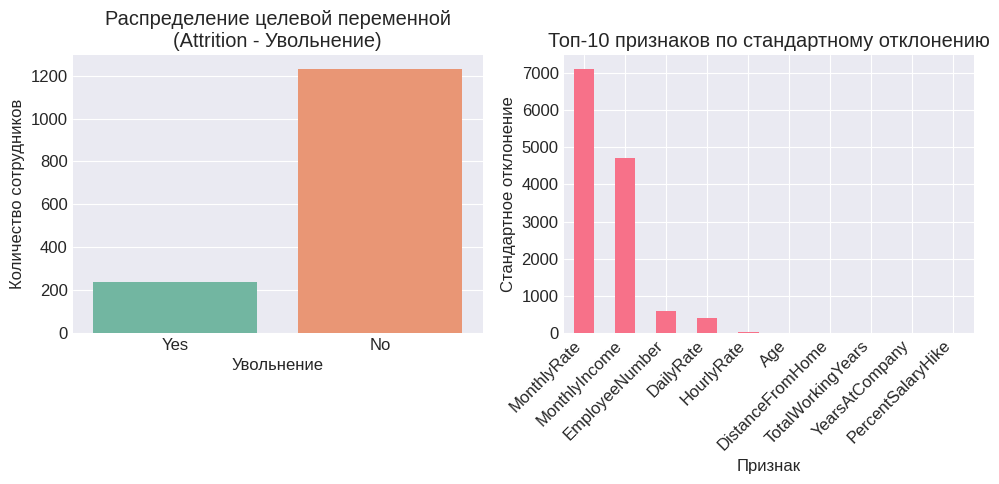


--- 1.7 Корреляционный анализ с целевой переменной ---
Топ-10 признаков по абсолютной корреляции с целевой переменной:
TotalWorkingYears       0.171063
JobLevel                0.169105
YearsInCurrentRole      0.160545
MonthlyIncome           0.159840
Age                     0.159205
YearsWithCurrManager    0.156199
StockOptionLevel        0.137145
YearsAtCompany          0.134392
JobInvolvement          0.130016
JobSatisfaction         0.103481
dtype: float64


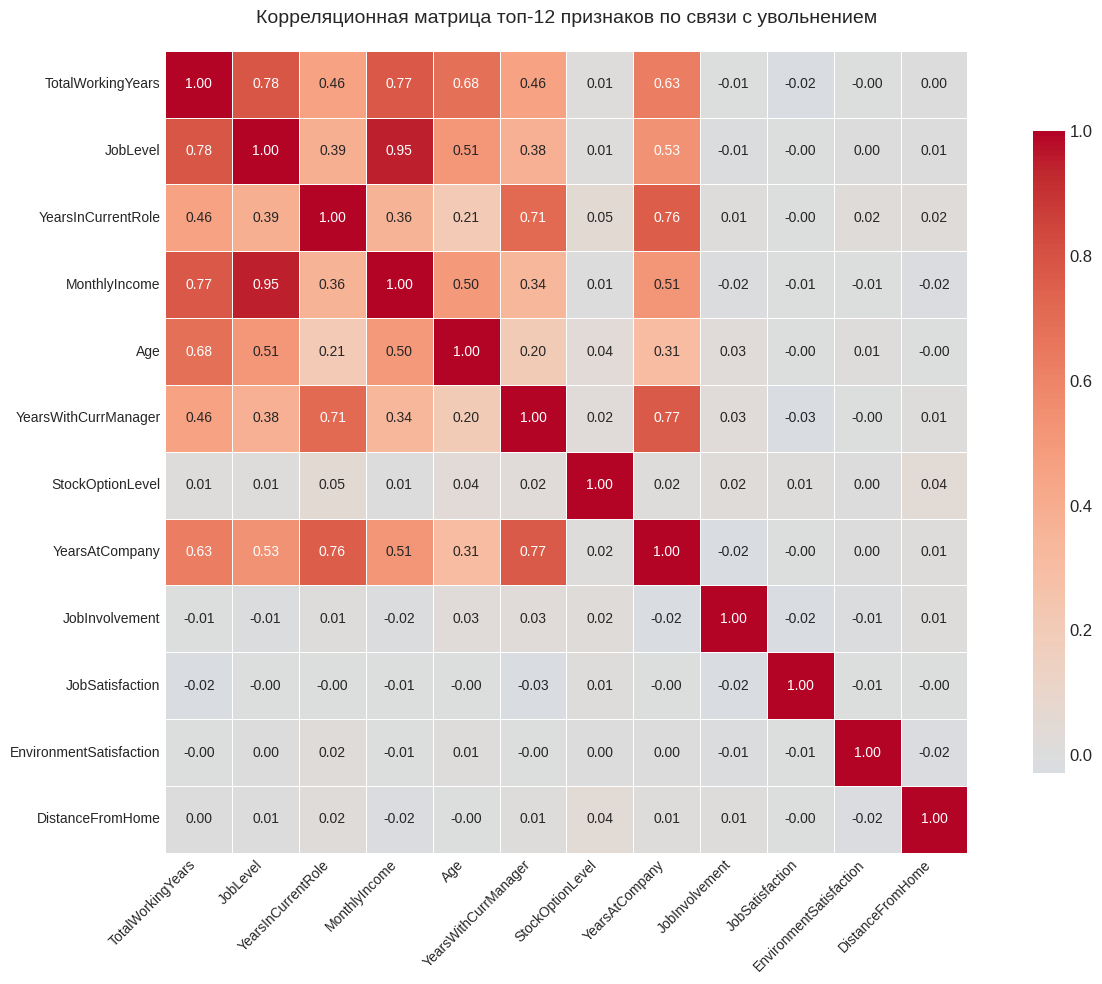

In [3]:
# Ячейка 1: АНАЛИЗ ДАТАСЕТА ДЛЯ КЛАССИФИКАЦИИ - ПРОГНОЗ УВОЛЬНЕНИЙ
# Загрузка датасета
df_class = pd.read_csv('Classification.csv')
print(f"Датасет загружен: {df_class.shape[0]} строк, {df_class.shape[1]} столбцов")

# 1.1 Первичный обзор данных
print("\n--- 1.1 Первичный обзор данных ---")
print("Первые 5 строк датасета:")
print(df_class.head())
print("\nИнформация о типах данных:")
print(df_class.info())

# 1.2 Статистическое описание числовых признаков
print("\n--- 1.2 Статистическое описание числовых признаков ---")
print(df_class.describe())

# 1.3 Проверка пропущенных значений
print("\n--- 1.3 Проверка пропущенных значений ---")
missing_values = df_class.isnull().sum()
missing_percent = (missing_values / len(df_class)) * 100

missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
}).sort_values('Количество пропусков', ascending=False)

print(missing_df[missing_df['Количество пропусков'] > 0])
if missing_df[missing_df['Количество пропусков'] > 0].empty:
    print("Пропуски в данных отсутствуют")

# 1.4 Анализ целевой переменной (Attrition)
print("\n--- 1.4 Анализ целевой переменной (Attrition) ---")
target_counts = df_class['Attrition'].value_counts()
target_percent = df_class['Attrition'].value_counts(normalize=True) * 100

print(f"Распределение классов:\n{target_counts}")
print(f"\nПроцентное соотношение:\n{target_percent.round(2)}")

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_class, x='Attrition', palette='Set2')
plt.title('Распределение целевой переменной\n(Attrition - Увольнение)')
plt.xlabel('Увольнение')
plt.ylabel('Количество сотрудников')

# 1.5 Анализ категориальных признаков
print("\n--- 1.5 Анализ категориальных признаков ---")
categorical_cols = df_class.select_dtypes(include=['object']).columns
print(f"Найдено категориальных признаков: {len(categorical_cols)}")

for col in categorical_cols:
    unique_vals = df_class[col].nunique()
    print(f"  {col}: {unique_vals} уникальных значений")

# 1.6 Анализ стандартных отклонений числовых признаков
print("\n--- 1.6 Анализ стандартных отклонений числовых признаков ---")
numeric_cols = df_class.select_dtypes(include=[np.number]).columns
std_dev = df_class[numeric_cols].std()

std_df = pd.DataFrame({
    'Стандартное отклонение': std_dev,
    'Среднее значение': df_class[numeric_cols].mean(),
    'Коэффициент вариации': (std_dev / df_class[numeric_cols].mean() * 100).round(2)
}).sort_values('Стандартное отклонение', ascending=False)

print("Топ-10 признаков с наибольшим стандартным отклонением:")
print(std_df.head(10))

# Визуализация стандартных отклонений
plt.subplot(1, 2, 2)
std_df.head(10)['Стандартное отклонение'].plot(kind='bar')
plt.title('Топ-10 признаков по стандартному отклонению')
plt.xlabel('Признак')
plt.ylabel('Стандартное отклонение')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 1.7 Корреляционный анализ с целевой переменной
print("\n--- 1.7 Корреляционный анализ с целевой переменной ---")
# Преобразование целевой переменной в числовой формат для корреляции
df_class['Attrition_numeric'] = df_class['Attrition'].map({'Yes': 1, 'No': 0})
correlations = df_class[numeric_cols].corrwith(df_class['Attrition_numeric']).abs().sort_values(ascending=False)

print("Топ-10 признаков по абсолютной корреляции с целевой переменной:")
print(correlations.head(10))

# Визуализация корреляционной матрицы
plt.figure(figsize=(14, 10))
top_corr_features = correlations.head(12).index
corr_matrix = df_class[top_corr_features].corr()

# Настройка размера шрифта и формата чисел
annot_kws = {"size": 10, "weight": "normal"}
fmt = '.2f'  # Формат отображения чисел (2 знака после запятой)

heatmap = sns.heatmap(corr_matrix, 
                     annot=True, 
                     fmt=fmt,
                     cmap='coolwarm', 
                     center=0, 
                     square=True, 
                     linewidths=0.5,
                     cbar_kws={"shrink": 0.8},
                     annot_kws=annot_kws)

# Настройка подписей осей
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title('Корреляционная матрица топ-12 признаков по связи с увольнением', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### Загрузка и анализ датасета для Регрессии (House Sales)

Датасет загружен: 21613 строк, 21 столбцов

--- 2.1 Первичный обзор данных ---
Первые 5 строк датасета:
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0        

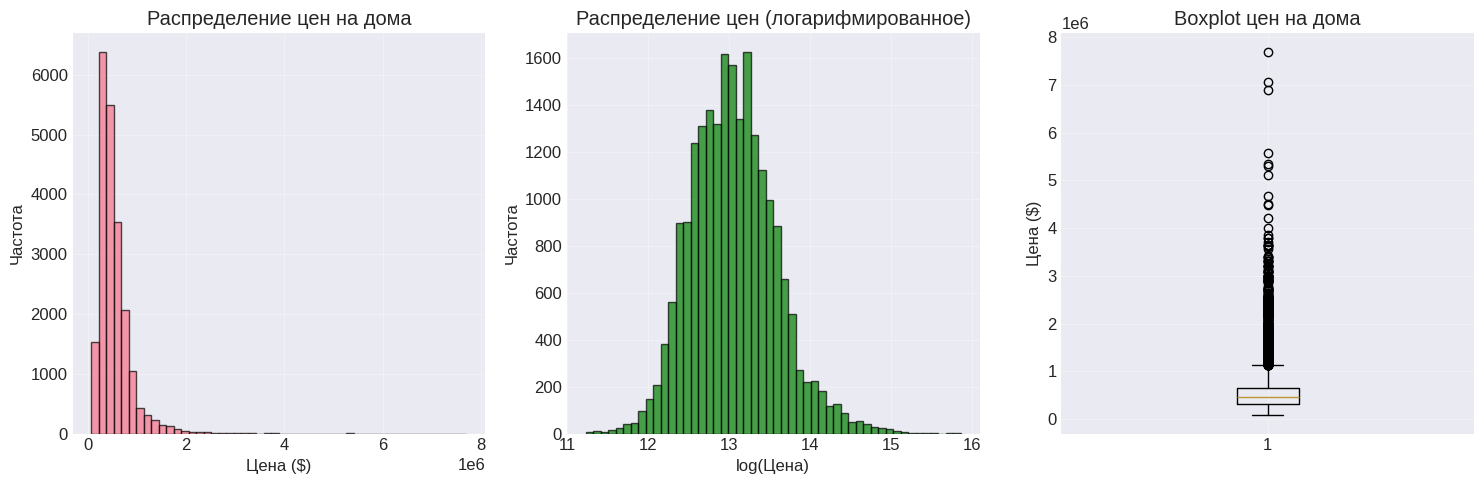


--- 2.5 Анализ стандартных отклонений ---
Топ-10 признаков с наибольшим стандартным отклонением:
               Стандартное отклонение  Среднее значение  Коэффициент вариации
id                       2.876566e+09      4.580302e+09                 62.80
price                    3.671272e+05      5.400881e+05                 67.98
sqft_lot                 4.142051e+04      1.510697e+04                274.18
sqft_lot15               2.730418e+04      1.276846e+04                213.84
sqft_living              9.184409e+02      2.079900e+03                 44.16
sqft_above               8.280910e+02      1.788391e+03                 46.30
sqft_living15            6.853913e+02      1.986552e+03                 34.50
sqft_basement            4.425750e+02      2.915090e+02                151.82
yr_renovated             4.016792e+02      8.440226e+01                475.91
zipcode                  5.350503e+01      9.807794e+04                  0.05

--- 2.6 Корреляция с целевой переменной (pr

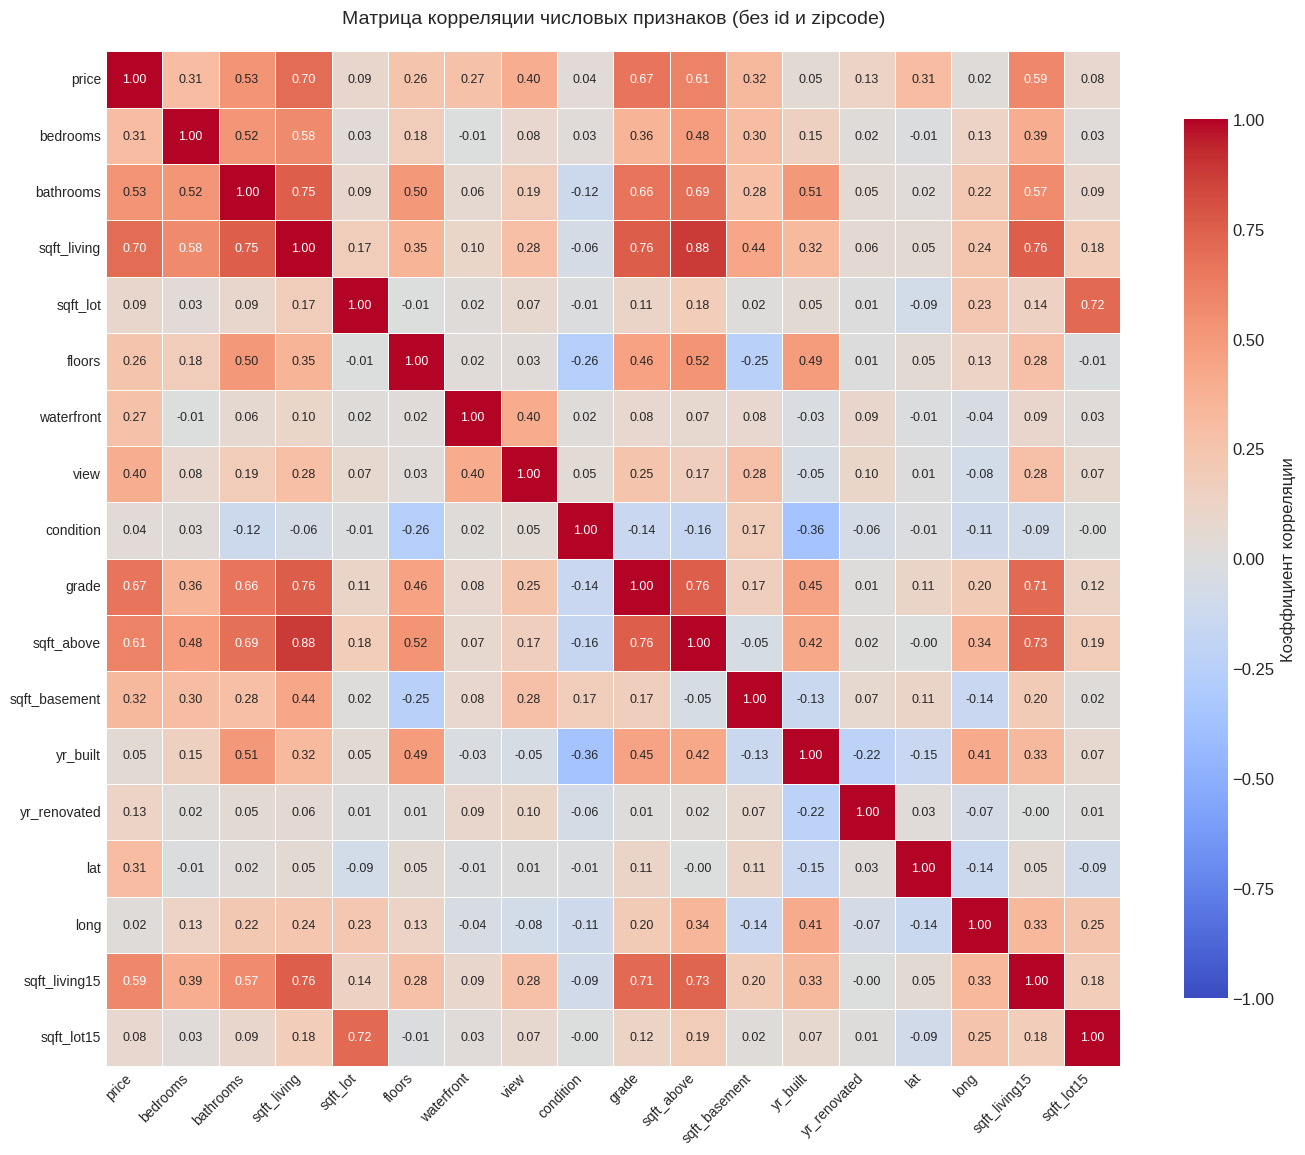


--- Анализ наиболее коррелирующих признаков ---
Пары признаков с высокой корреляцией (|r| > 0.7):
------------------------------------------------------------
  sqft_living     и sqft_above      => 0.877
  sqft_living     и grade           => 0.763
  sqft_living     и sqft_living15   => 0.756
  grade           и sqft_above      => 0.756
  bathrooms       и sqft_living     => 0.755
  sqft_above      и sqft_living15   => 0.732
  sqft_lot        и sqft_lot15      => 0.719
  grade           и sqft_living15   => 0.713
  price           и sqft_living     => 0.702

--- 2.7 Анализ выбросов в ключевых признаках ---
sqft_living    :  572 выбросов (2.6%)
sqft_lot       : 2425 выбросов (11.2%)
bedrooms       :  546 выбросов (2.5%)
bathrooms      :  571 выбросов (2.6%)
grade          : 1911 выбросов (8.8%)


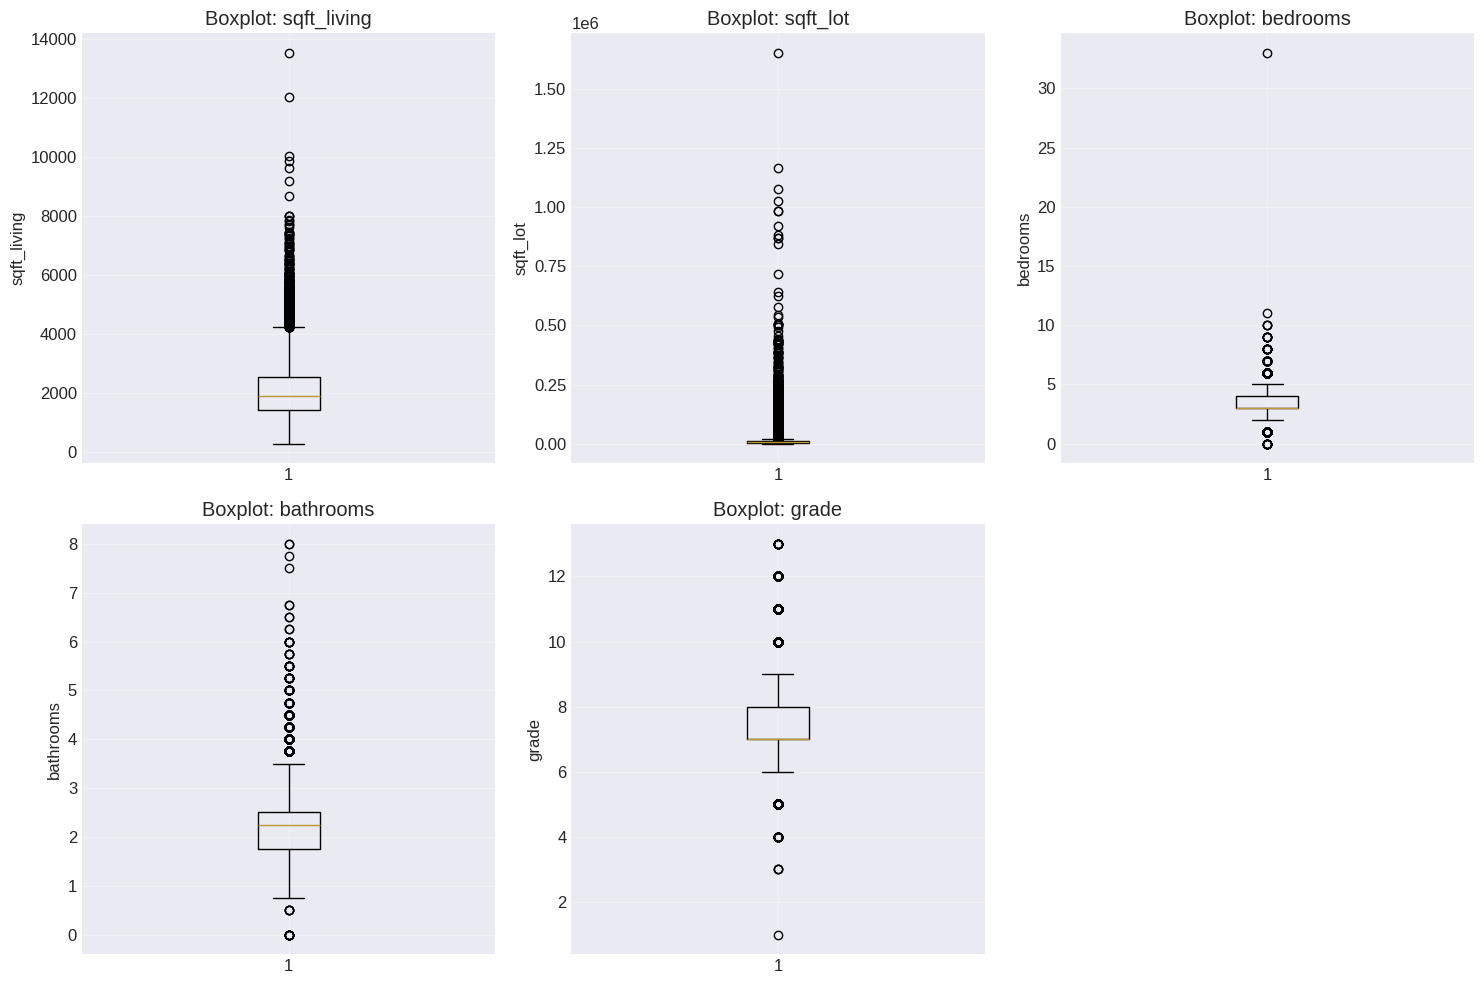

In [4]:
# Ячейка 2: АНАЛИЗ ДАТАСЕТА ДЛЯ РЕГРЕССИИ - ПРОГНОЗ ЦЕН НА ДОМА
# Загрузка датасета
df_reg = pd.read_csv('Regression.csv')
print(f"Датасет загружен: {df_reg.shape[0]} строк, {df_reg.shape[1]} столбцов")

# 2.1 Первичный обзор данных
print("\n--- 2.1 Первичный обзор данных ---")
print("Первые 5 строк датасета:")
print(df_reg.head())
print("\nИнформация о типах данных:")
print(df_reg.info())

# 2.2 Статистическое описание
print("\n--- 2.2 Статистическое описание ---")
print(df_reg.describe())

# 2.3 Проверка пропущенных значений
print("\n--- 2.3 Проверка пропущенных значений ---")
missing_values_reg = df_reg.isnull().sum()
missing_percent_reg = (missing_values_reg / len(df_reg)) * 100

missing_df_reg = pd.DataFrame({
    'Количество пропусков': missing_values_reg,
    'Процент пропусков': missing_percent_reg
}).sort_values('Количество пропусков', ascending=False)

print(missing_df_reg[missing_df_reg['Количество пропусков'] > 0])
if missing_df_reg[missing_df_reg['Количество пропусков'] > 0].empty:
    print("Пропуски в данных отсутствуют")

# 2.4 Анализ целевой переменной (price)
print("\n--- 2.4 Анализ целевой переменной (price) ---")
price_stats = {
    'Медиана': df_reg['price'].median(),
    'Среднее значение': df_reg['price'].mean(),
    'Стандартное отклонение': df_reg['price'].std(),
    'Минимальная цена': df_reg['price'].min(),
    'Максимальная цена': df_reg['price'].max(),
    'Коэффициент вариации': (df_reg['price'].std() / df_reg['price'].mean() * 100)
}

for key, value in price_stats.items():
    if key != 'Коэффициент вариации':
        print(f"{key}: ${value:,.2f}")
    else:
        print(f"{key}: {value:.2f}%")

# Визуализация распределения цены
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_reg['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение цен на дома')
plt.xlabel('Цена ($)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(np.log1p(df_reg['price']), bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('Распределение цен (логарифмированное)')
plt.xlabel('log(Цена)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.boxplot(df_reg['price'])
plt.title('Boxplot цен на дома')
plt.ylabel('Цена ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2.5 Анализ стандартных отклонений
print("\n--- 2.5 Анализ стандартных отклонений ---")
numeric_cols_reg = df_reg.select_dtypes(include=[np.number]).columns
std_dev_reg = df_reg[numeric_cols_reg].std()

std_df_reg = pd.DataFrame({
    'Стандартное отклонение': std_dev_reg,
    'Среднее значение': df_reg[numeric_cols_reg].mean(),
    'Коэффициент вариации': (std_dev_reg / df_reg[numeric_cols_reg].mean() * 100).round(2)
}).sort_values('Стандартное отклонение', ascending=False)

print("Топ-10 признаков с наибольшим стандартным отклонением:")
print(std_df_reg.head(10))

# 2.6 Корреляция с целевой переменной (price)
print("\n--- 2.6 Корреляция с целевой переменной (price) ---")

# Исключаем неинформативные признаки (id, zipcode - это категориальные коды, а не числовые признаки)
exclude_features = ['id', 'zipcode']
numeric_features = [col for col in numeric_cols_reg if col not in exclude_features]

correlations_reg = df_reg[numeric_features].corrwith(df_reg['price']).abs().sort_values(ascending=False)

print("Топ-10 признаков по абсолютной корреляции с ценой:")
for i, (feature, corr_value) in enumerate(correlations_reg.head(10).items(), 1):
    actual_corr = df_reg[numeric_features].corrwith(df_reg['price'])[feature]
    print(f"{i:2}. {feature:20} {actual_corr:+.3f}")

# Визуализация матрицы корреляции
print("\n--- Матрица корреляции (без id и zipcode) ---")

# Создаем матрицу корреляции для осмысленных числовых признаков
corr_matrix = df_reg[numeric_features].corr()

# Определяем размер фигуры в зависимости от количества признаков
n_features = len(corr_matrix.columns)
figsize = max(14, n_features * 0.6), max(12, n_features * 0.6)

plt.figure(figsize=figsize)

# Создаем тепловую карту корреляций
sns.heatmap(corr_matrix, 
           annot=True, 
           fmt='.2f',
           cmap='coolwarm', 
           vmin=-1, vmax=1,
           center=0,
           square=True,
           linewidths=0.5,
           cbar_kws={"shrink": 0.8, "label": "Коэффициент корреляции"},
           annot_kws={"size": 9})

plt.title('Матрица корреляции числовых признаков (без id и zipcode)', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# Дополнительная информация о наиболее коррелирующих признаках
print("\n--- Анализ наиболее коррелирующих признаков ---")

# Находим пары признаков с высокой корреляцией
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            feat1 = corr_matrix.columns[i]
            feat2 = corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_value))

if high_corr_pairs:
    print("Пары признаков с высокой корреляцией (|r| > 0.7):")
    print("-" * 60)
    for feat1, feat2, corr_value in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1:15} и {feat2:15} => {corr_value:.3f}")
else:
    print("Нет пар признаков с высокой корреляцией (|r| > 0.7)")

# 2.7 Анализ выбросов в ключевых признаках
print("\n--- 2.7 Анализ выбросов в ключевых признаках ---")
key_features = ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'grade']

# Базовая информация о выбросах
for feature in key_features:
    if feature in df_reg.columns:
        Q1 = df_reg[feature].quantile(0.25)
        Q3 = df_reg[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_reg[(df_reg[feature] < lower_bound) | (df_reg[feature] > upper_bound)]
        n_outliers = len(outliers)
        
        print(f"{feature:15}: {n_outliers:4} выбросов ({n_outliers/len(df_reg)*100:.1f}%)")

# Визуализация
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    if feature in df_reg.columns:
        plt.subplot(2, 3, i)
        plt.boxplot(df_reg[feature].dropna())
        plt.title(f'Boxplot: {feature}')
        plt.ylabel(feature)
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Создание безлайна и оценка качества

### Предобработка данных для задачи классификации

In [5]:
# Ячейка 3: ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ СЛУЧАЙНОГО ЛЕСА КЛАССИФИКАЦИИ
# 3.1 Создаем копию данных для обработки
df_class_processed = df_class.copy()
print("Создана копия данных для предобработки")

# 3.2 Удаляем неинформативные признаки И Attrition_numeric
print("\n--- 3.1 Удаление неинформативных признаков ---")

columns_to_drop = [
    'EmployeeCount',      # Все значения = 1
    'EmployeeNumber',     # Уникальный идентификатор
    'Over18',             # Все значения = 'Y'
    'StandardHours',      # Все значения = 80
    'Attrition_numeric'   
]

print(f"Удаляем признаки: {columns_to_drop}")
df_class_processed = df_class_processed.drop(columns=columns_to_drop, errors='ignore')
print(f"Осталось признаков: {df_class_processed.shape[1]}")

# 3.3 Преобразование целевой переменной
print("\n--- 3.3 Преобразование целевой переменной ---")
df_class_processed['Attrition'] = df_class_processed['Attrition'].map({'Yes': 1, 'No': 0})
print("Целевая переменная Attrition преобразована: Yes -> 1, No -> 0")

# Анализ дисбаланса (ВАЖНО для Random Forest)
print(f"\nСоотношение классов: {sum(df_class_processed['Attrition'] == 0)}:1")
print(f"Процент класса 'Yes' (уволился): {df_class_processed['Attrition'].mean()*100:.1f}%")

# 3.4 Обработка категориальных признаков
print("\n--- 3.4 Обработка категориальных признаков ---")

categorical_cols = df_class_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки для обработки ({len(categorical_cols)}):")

# Анализируем категориальные признаки
for col in categorical_cols:
    unique_vals = df_class_processed[col].nunique()
    value_counts = df_class_processed[col].value_counts()
    print(f"  {col}: {unique_vals} уникальных значений")
    print(f"    Распределение: {dict(value_counts.head(3))}")

# One-Hot Encoding для Random Forest (можно без drop_first)
print("\nПрименяем One-Hot Encoding для категориальных признаков...")
df_class_encoded = pd.get_dummies(df_class_processed, columns=categorical_cols, drop_first=True)
print(f"После кодирования: {df_class_encoded.shape[1]} признаков")

# 3.5 Разделение на признаки и целевую переменную
print("\n--- 3.5 Разделение данных ---")
X_class = df_class_encoded.drop('Attrition', axis=1)
y_class = df_class_encoded['Attrition']

print(f"Признаки (X): {X_class.shape}")
print(f"Целевая переменная (y): {y_class.shape}")
print(f"Имена признаков: {list(X_class.columns[:5])}...")

# 3.6 Подготовка признаков для Random Forest
print("\n--- 3.6 Подготовка признаков ---")
# Random Forest не требует масштабирования признаков!
print("Random Forest не требует масштабирования признаков - работаем с исходными значениями")
X_class_prepared = X_class.values  # Просто преобразуем в numpy array

# 3.7 Разделение на обучающую и тестовую выборки
print("\n--- 3.7 Разделение на train/test ---")
print("Используем stratify=y_class для сохранения пропорций классов")
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_prepared, y_class, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_class
)

print(f"Обучающая выборка: {X_train_class.shape}")
print(f"Тестовая выборка: {X_test_class.shape}")
print(f"Распределение классов в train: {np.bincount(y_train_class)}")
print(f"Распределение классов в test: {np.bincount(y_test_class)}")

# Сохраняем важную информацию для Random Forest
feature_names_class = X_class.columns.tolist()


Создана копия данных для предобработки

--- 3.1 Удаление неинформативных признаков ---
Удаляем признаки: ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours', 'Attrition_numeric']
Осталось признаков: 31

--- 3.3 Преобразование целевой переменной ---
Целевая переменная Attrition преобразована: Yes -> 1, No -> 0

Соотношение классов: 1233:1
Процент класса 'Yes' (уволился): 16.1%

--- 3.4 Обработка категориальных признаков ---
Категориальные признаки для обработки (7):
  BusinessTravel: 3 уникальных значений
    Распределение: {'Travel_Rarely': 1043, 'Travel_Frequently': 277, 'Non-Travel': 150}
  Department: 3 уникальных значений
    Распределение: {'Research & Development': 961, 'Sales': 446, 'Human Resources': 63}
  EducationField: 6 уникальных значений
    Распределение: {'Life Sciences': 606, 'Medical': 464, 'Marketing': 159}
  Gender: 2 уникальных значений
    Распределение: {'Male': 882, 'Female': 588}
  JobRole: 9 уникальных значений
    Распределение: {'Sales Executive': 

### Предобработка данных для задачи регрессии

In [6]:
# Ячейка 4: ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ СЛУЧАЙНОГО ЛЕСА РЕГРЕССИИ
# 4.1 Создаем копию данных для обработки
df_reg_processed = df_reg.copy()
print("Создана копия данных для предобработки")

# 4.2 Удаляем неинформативные признаки
print("\n--- 4.1 Удаление неинформативных признаков ---")

columns_to_drop_reg = ['id', 'zipcode']
print(f"Удаляем признаки: {columns_to_drop_reg}")
df_reg_processed = df_reg_processed.drop(columns=columns_to_drop_reg, errors='ignore')
print(f"Осталось признаков: {df_reg_processed.shape[1]}")

# 4.3 Обработка признака date
print("\n--- 4.3 Обработка временных признаков ---")

if 'date' in df_reg_processed.columns:
    df_reg_processed['date'] = pd.to_datetime(df_reg_processed['date'])
    df_reg_processed['sale_year'] = df_reg_processed['date'].dt.year
    df_reg_processed['sale_month'] = df_reg_processed['date'].dt.month
    df_reg_processed['sale_season'] = df_reg_processed['sale_month'].apply(
        lambda x: 1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4
    )
    df_reg_processed = df_reg_processed.drop('date', axis=1)
    print(f"Извлечены признаки из даты: sale_year, sale_month, sale_season")

# 4.4 Обработка выбросов (Random Forest устойчив к выбросам, но исправляем явные ошибки)
print("\n--- 4.4 Обработка явных ошибок в данных ---")

# Спальни: исправляем явные ошибки (0 или >10 спален)
if 'bedrooms' in df_reg_processed.columns:
    bedrooms_median = df_reg_processed['bedrooms'].median()
    mask_bedrooms = (df_reg_processed['bedrooms'] < 1) | (df_reg_processed['bedrooms'] > 10)
    if mask_bedrooms.any():
        n_bed = mask_bedrooms.sum()
        df_reg_processed.loc[mask_bedrooms, 'bedrooms'] = bedrooms_median
        print(f"Спальни: {n_bed} некорректных значений заменены на медиану ({bedrooms_median})")

# Ванные: исправляем явные ошибки (0 или >10 ванных)
if 'bathrooms' in df_reg_processed.columns:
    bathrooms_median = df_reg_processed['bathrooms'].median()
    mask_bathrooms = (df_reg_processed['bathrooms'] < 1) | (df_reg_processed['bathrooms'] > 10)
    if mask_bathrooms.any():
        n_bath = mask_bathrooms.sum()
        df_reg_processed.loc[mask_bathrooms, 'bathrooms'] = bathrooms_median
        print(f"Ванные: {n_bath} некорректных значений заменены на медиану ({bathrooms_median:.1f})")

# 4.5 Логарифмирование целевой переменной (ВАЖНО для регрессии цен)
print("\n--- 4.5 Логарифмирование целевой переменной ---")

# Логарифмируем цену (особенно важно для задач с большим разбросом значений)
df_reg_processed['price_log'] = np.log1p(df_reg_processed['price'])
target_col = 'price_log'

print("Целевая переменная логарифмирована: создан price_log")
print(f"Среднее логарифмированной цены: {df_reg_processed['price_log'].mean():.2f}")
print(f"Стандартное отклонение: {df_reg_processed['price_log'].std():.2f}")

# Сохраняем оригинальные цены для обратного преобразования
original_prices_train = None
original_prices_test = None

# 4.6 Разделение на признаки и целевую переменную
print("\n--- 4.6 Разделение данных ---")

# Собираем все числовые признаки
all_numeric_features = df_reg_processed.select_dtypes(include=[np.number]).columns.tolist()

# Убираем price и price_log из признаков
numeric_features_reg = [col for col in all_numeric_features if col not in ['price', 'price_log']]

X_reg = df_reg_processed[numeric_features_reg]
y_reg = df_reg_processed[target_col]  # Используем price_log как целевую

print(f"Признаки (X): {X_reg.shape}")
print(f"Целевая переменная (y, log): {y_reg.shape}")
print(f"Примеры признаков: {numeric_features_reg[:10]}")

# 4.7 Подготовка признаков для Random Forest
print("\n--- 4.7 Подготовка признаков ---")

X_reg_prepared = X_reg.values  # Просто преобразуем в numpy array

# 4.8 Разделение на обучающую и тестовую выборки
print("\n--- 4.8 Разделение на train/test ---")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_prepared, y_reg, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: {X_train_reg.shape}")
print(f"Тестовая выборка: {X_test_reg.shape}")
print(f"Диапазон целевой переменной в train: [{y_train_reg.min():.2f}, {y_train_reg.max():.2f}]")
print(f"Диапазон целевой переменной в test: [{y_test_reg.min():.2f}, {y_test_reg.max():.2f}]")

# Сохраняем имена признаков для анализа важности
feature_names_reg = numeric_features_reg
print(f"\nСохранены имена {len(feature_names_reg)} признаков для анализа важности")


Создана копия данных для предобработки

--- 4.1 Удаление неинформативных признаков ---
Удаляем признаки: ['id', 'zipcode']
Осталось признаков: 19

--- 4.3 Обработка временных признаков ---
Извлечены признаки из даты: sale_year, sale_month, sale_season

--- 4.4 Обработка явных ошибок в данных ---
Спальни: 15 некорректных значений заменены на медиану (3.0)
Ванные: 86 некорректных значений заменены на медиану (2.2)

--- 4.5 Логарифмирование целевой переменной ---
Целевая переменная логарифмирована: создан price_log
Среднее логарифмированной цены: 13.05
Стандартное отклонение: 0.53

--- 4.6 Разделение данных ---
Признаки (X): (21613, 20)
Целевая переменная (y, log): (21613,)
Примеры признаков: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above']

--- 4.7 Подготовка признаков ---

--- 4.8 Разделение на train/test ---
Обучающая выборка: (17290, 20)
Тестовая выборка: (4323, 20)
Диапазон целевой переменной в train: [11.23, 15.

### Построение безлайна для классификации


--- 5.1 Обучение базовой модели случайного леса ---
Обучаем модель случайного леса...
Модель обучена успешно!
OOB оценка (Out-of-Bag): 0.8435

--- 5.2 Анализ важности признаков ---
Топ-15 самых важных признаков для случайного леса:
  MonthlyIncome                  → 0.0848
  Age                            → 0.0692
  YearsAtCompany                 → 0.0669
  OverTime_Yes                   → 0.0638
  TotalWorkingYears              → 0.0582
  YearsWithCurrManager           → 0.0543
  DailyRate                      → 0.0467
  StockOptionLevel               → 0.0422
  DistanceFromHome               → 0.0386
  JobLevel                       → 0.0369
  NumCompaniesWorked             → 0.0361
  MonthlyRate                    → 0.0354
  HourlyRate                     → 0.0314
  EnvironmentSatisfaction        → 0.0268
  PercentSalaryHike              → 0.0266

Средняя важность признака: 0.0227
Количество признаков выше средней важности: 17


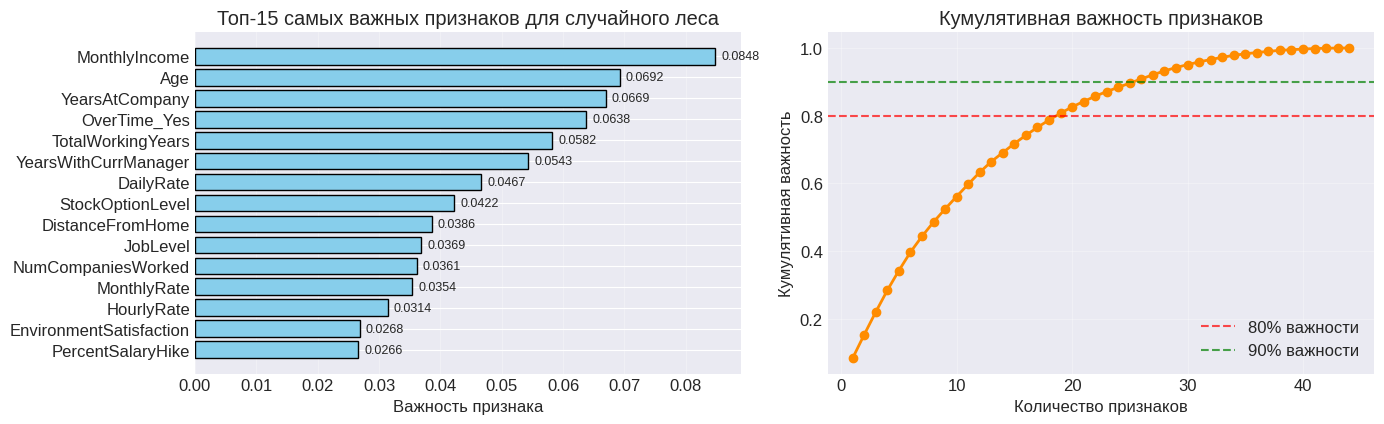


--- 5.3 Предсказания на тестовой выборке ---
Получено 294 предсказаний
Распределение предсказанных классов: Класс 0: 247, Класс 1: 47
Диапазон вероятностей класса 1: [0.049, 0.913]

--- 5.4 Матрица ошибок ---
Матрица ошибок случайного леса:
                  Предсказано
                Нет     Да
Фактически Нет  [222]  [ 25]
            Да   [ 25]  [ 22]

  • OOB Score:      0.8435
  • Разница с тестовой accuracy: 0.0136
Основные метрики качества (вычисленные из матрицы ошибок):
  • Accuracy:       0.8299
  • Precision:      0.4681
  • Recall:         0.4681
  • F1-score:       0.4681

Дополнительные метрики:
  • False Positive: 25 (10.1% от класса 'Нет')
  • False Negative: 25 (53.2% от класса 'Да')

--- 5.5 Визуализация матрицы ошибок ---


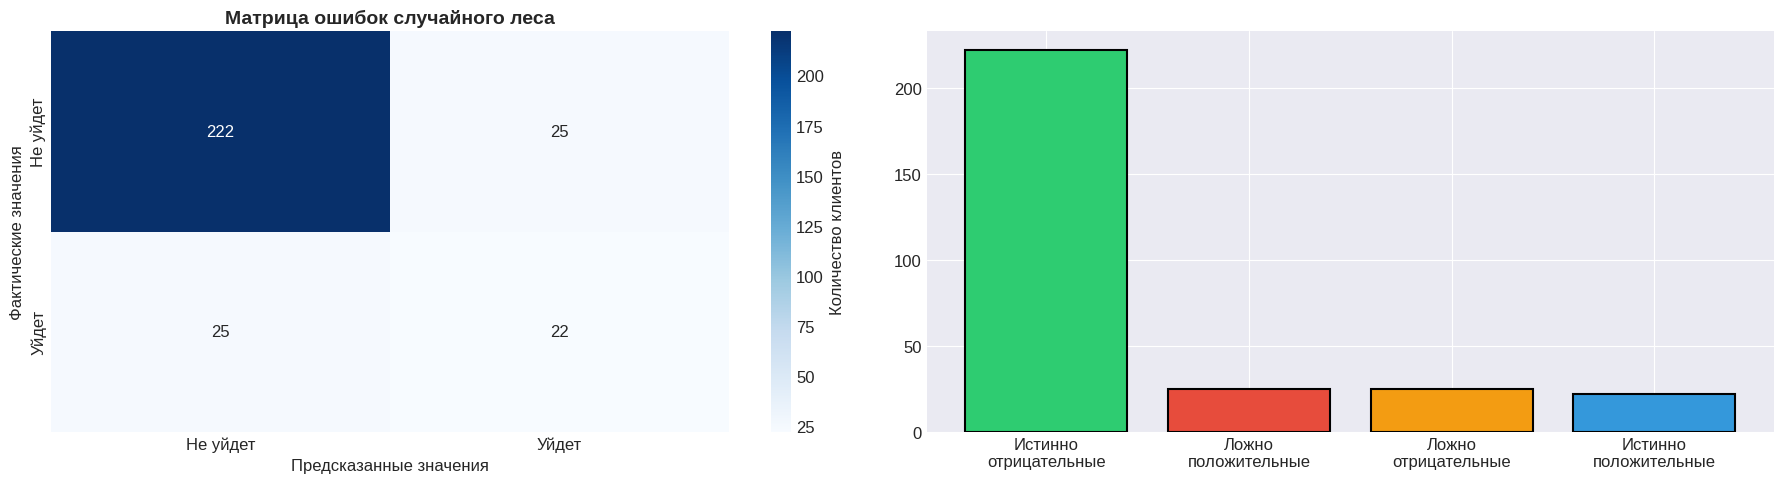


--- 5.6 Детальный анализ предсказаний ---
1. ОБЩАЯ СТАТИСТИКА:
   Всего предсказаний: 294
   Правильных предсказаний: 244 (83.0%)
   Ошибок предсказаний: 50 (17.0%)

2. АНАЛИЗ ПО КЛАССАМ:

   КЛАСС 'НЕ УЙДЕТ':
   • Фактически не ушли: 247 клиентов
   • Правильно предсказано: 222 клиентов
   • Точность для класса: 89.9%

   КЛАСС 'УЙДЕТ':
   • Фактически уйдут: 47 клиентов
   • Правильно предсказано: 22 клиентов
   • Точность для класса: 46.8%

--- 5.7 Полный отчет о классификации ---
              precision    recall  f1-score   support

    Не уйдет       0.90      0.90      0.90       247
       Уйдет       0.47      0.47      0.47        47

    accuracy                           0.83       294
   macro avg       0.68      0.68      0.68       294
weighted avg       0.83      0.83      0.83       294


--- 5.8 Анализ ансамбля деревьев ---
Ансамбль состоит из 100 деревьев
Размер каждой бутстрэп выборки: ~740 образцов
Примерный размер OOB выборки для каждого дерева: ~435 образцов

Ст

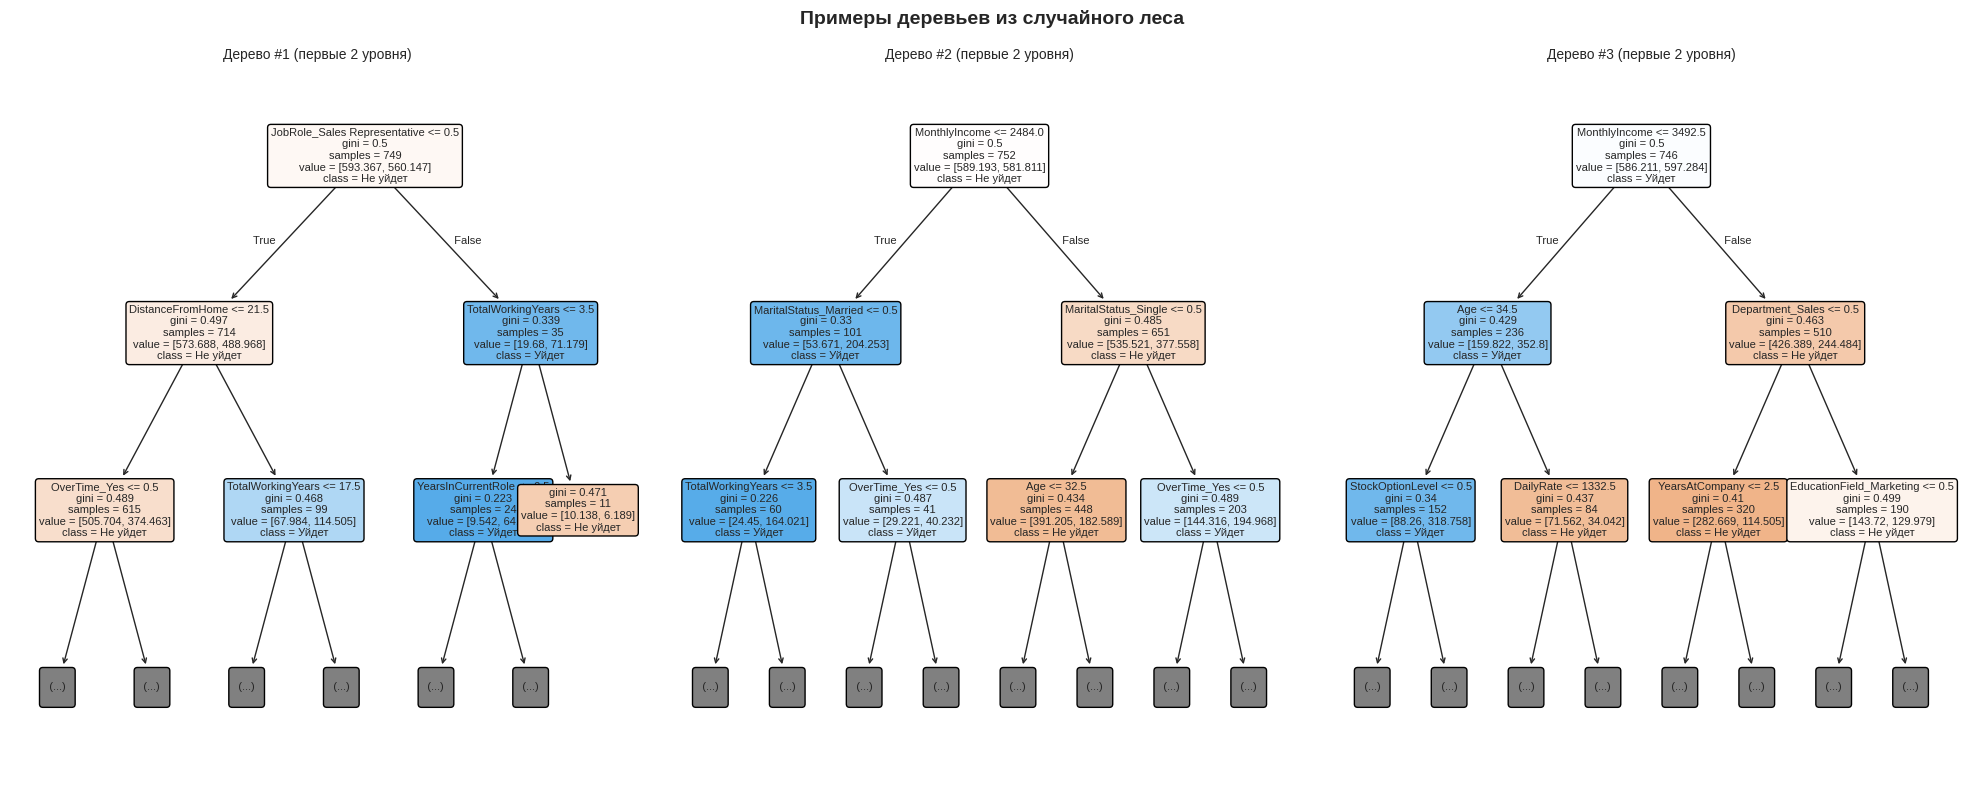


--- 5.10 Параметры модели ---
Использованные параметры случайного леса:
• n_estimators: 100
• max_depth: 10
• min_samples_split: 20
• min_samples_leaf: 10
• max_features: sqrt
• bootstrap: True
• oob_score: True
• class_weight: balanced
• random_state: 42

--- 5.11 Анализ стабильности важности признаков ---

Стабильность топ-5 признаков по деревьям:
1. MonthlyIncome                 :
   Средняя важность: 0.0848
   Стандартное отклонение: 0.0742
   Минимум: 0.0000
   Максимум: 0.3343
   Коэффициент вариации: 87.5%
2. Age                           :
   Средняя важность: 0.0692
   Стандартное отклонение: 0.0602
   Минимум: 0.0000
   Максимум: 0.2827
   Коэффициент вариации: 86.9%
3. YearsAtCompany                :
   Средняя важность: 0.0669
   Стандартное отклонение: 0.0705
   Минимум: 0.0000
   Максимум: 0.2828
   Коэффициент вариации: 105.3%
4. OverTime_Yes                  :
   Средняя важность: 0.0638
   Стандартное отклонение: 0.0563
   Минимум: 0.0000
   Максимум: 0.2220
   Коэффи

In [ ]:
# Ячейка 5: ПОСТРОЕНИЕ БЕЙСЛАЙНА ДЛЯ КЛАССИФИКАЦИИ (Случайный лес)
# 5.1 Обучение базовой модели случайного леса
print("\n--- 5.1 Обучение базовой модели случайного леса ---")

# Создаем модель случайного леса
rf_classifier = RandomForestClassifier(
    random_state=42,
    n_estimators=100,         # Количество деревьев в лесу
    max_depth=10,             # Ограничиваем глубину для предотвращения переобучения
    min_samples_split=20,     # Минимальное количество образцов для разделения узла
    min_samples_leaf=10,      # Минимальное количество образцов в листе
    max_features='sqrt',      # Количество признаков для рассмотрения в каждом разбиении
    class_weight='balanced',  # Учитываем дисбаланс классов
    bootstrap=True,           # Использовать бутстрэп выборки
    oob_score=True,           # Рассчитать OOB оценку
    n_jobs=-1                # Использовать все доступные ядра
)

# Обучаем модель на обучающей выборке
print("Обучаем модель случайного леса...")
rf_classifier.fit(X_train_class, y_train_class)
print("Модель обучена успешно!")

# Анализ OOB (Out-of-Bag) ошибки
if hasattr(rf_classifier, 'oob_score_'):
    print(f"OOB оценка (Out-of-Bag): {rf_classifier.oob_score_:.4f}")
    
# 5.2 Анализ важности признаков в случайном лесе
print("\n--- 5.2 Анализ важности признаков ---")

# Получаем важность признаков из случайного леса
feature_importance = rf_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Признак': feature_names_class,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False).head(15)

print("Топ-15 самых важных признаков для случайного леса:")
for i, row in importance_df.iterrows():
    print(f"  {row['Признак']:30} → {row['Важность']:.4f}")

# Сравнение со средним значением важности
mean_importance = feature_importance.mean()
print(f"\nСредняя важность признака: {mean_importance:.4f}")
print(f"Количество признаков выше средней важности: {(feature_importance > mean_importance).sum()}")

# Визуализация важности признаков
plt.figure(figsize=(14, 8))

# 1. Столбчатая диаграмма
plt.subplot(2, 2, 1)
bars = plt.barh(range(len(importance_df)), importance_df['Важность'][::-1], 
                color='skyblue', edgecolor='black')
plt.yticks(range(len(importance_df)), importance_df['Признак'][::-1])
plt.xlabel('Важность признака')
plt.title('Топ-15 самых важных признаков для случайного леса')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на столбцы
for i, (bar, importance) in enumerate(zip(bars, importance_df['Важность'][::-1])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=9)

# 2. Кумулятивная важность
plt.subplot(2, 2, 2)
cumulative_importance = np.sort(feature_importance)[::-1].cumsum()
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
         marker='o', linewidth=2, color='darkorange')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% важности')
plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% важности')
plt.xlabel('Количество признаков')
plt.ylabel('Кумулятивная важность')
plt.title('Кумулятивная важность признаков')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5.3 Предсказания на тестовой выборке
print("\n--- 5.3 Предсказания на тестовой выборке ---")

# Получаем предсказания
y_pred_class = rf_classifier.predict(X_test_class)
y_pred_proba = rf_classifier.predict_proba(X_test_class)[:, 1]  # Вероятности для класса 1

print(f"Получено {len(y_pred_class)} предсказаний")
print(f"Распределение предсказанных классов: Класс 0: {(y_pred_class == 0).sum()}, Класс 1: {(y_pred_class == 1).sum()}")
print(f"Диапазон вероятностей класса 1: [{y_pred_proba.min():.3f}, {y_pred_proba.max():.3f}]")

# 5.4 Матрица ошибок (Confusion Matrix)
print("\n--- 5.4 Матрица ошибок ---")

# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test_class, y_pred_class)
tn, fp, fn, tp = cm.ravel()

print("Матрица ошибок случайного леса:")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn:3d}]  [{fp:3d}]")
print(f"            Да   [{fn:3d}]  [{tp:3d}]")
print()

# Вычисляем метрики из матрицы ошибок
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

if hasattr(rf_classifier, 'oob_score_'):
    print(f"  • OOB Score:      {rf_classifier.oob_score_:.4f}")
    print(f"  • Разница с тестовой accuracy: {abs(accuracy - rf_classifier.oob_score_):.4f}")

print(f"Основные метрики качества (вычисленные из матрицы ошибок):")
print(f"  • Accuracy:       {accuracy:.4f}")
print(f"  • Precision:      {precision:.4f}")
print(f"  • Recall:         {recall:.4f}")
print(f"  • F1-score:       {f1:.4f}")

# Дополнительные метрики
print(f"\nДополнительные метрики:")
print(f"  • False Positive: {fp} ({fp/(fp+tn)*100:.1f}% от класса 'Нет')")
print(f"  • False Negative: {fn} ({fn/(fn+tp)*100:.1f}% от класса 'Да')")

# 5.5 Визуализация матрицы ошибок
print("\n--- 5.5 Визуализация матрицы ошибок ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# 1. Тепловая карта матрицы ошибок
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество клиентов'})
ax1.set_title('Матрица ошибок случайного леса', fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn, fp, fn, tp]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

plt.tight_layout()
plt.show()

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний по типам', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем аннотации с процентами
total_predictions = len(y_pred_class)
percentages = [v/total_predictions*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

# 5.6 Детальный анализ предсказаний
print("\n--- 5.6 Детальный анализ предсказаний ---")

total_predictions = len(y_pred_class)
correct_predictions = tp + tn
incorrect_predictions = fp + fn

print(f"1. ОБЩАЯ СТАТИСТИКА:")
print(f"   Всего предсказаний: {total_predictions}")
print(f"   Правильных предсказаний: {correct_predictions} ({accuracy*100:.1f}%)")
print(f"   Ошибок предсказаний: {incorrect_predictions} ({(1-accuracy)*100:.1f}%)")

# Анализ по классам
print(f"\n2. АНАЛИЗ ПО КЛАССАМ:")

# Для класса "Не уйдет" (0)
correct_not_churn = tn
total_not_churn_actual = tn + fp
accuracy_not_churn = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n   КЛАСС 'НЕ УЙДЕТ':")
print(f"   • Фактически не ушли: {total_not_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_not_churn} клиентов")
print(f"   • Точность для класса: {accuracy_not_churn*100:.1f}%")

# Для класса "Уйдет" (1)
correct_churn = tp
total_churn_actual = tp + fn
accuracy_churn = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n   КЛАСС 'УЙДЕТ':")
print(f"   • Фактически уйдут: {total_churn_actual} клиентов")
print(f"   • Правильно предсказано: {correct_churn} клиентов")
print(f"   • Точность для класса: {accuracy_churn*100:.1f}%")

# 5.7 Полный отчет о классификации
print("\n--- 5.7 Полный отчет о классификации ---")
print(classification_report(y_test_class, y_pred_class, 
                           target_names=['Не уйдет', 'Уйдет']))

# 5.8 Анализ отдельных деревьев в лесу
print("\n--- 5.8 Анализ ансамбля деревьев ---")

print(f"Ансамбль состоит из {rf_classifier.n_estimators} деревьев")
print(f"Размер каждой бутстрэп выборки: ~{int(len(X_train_class) * 0.63)} образцов")
print(f"Примерный размер OOB выборки для каждого дерева: ~{int(len(X_train_class) * 0.37)} образцов")

# Анализ глубины деревьев
depths = [estimator.get_depth() for estimator in rf_classifier.estimators_]
n_leaves = [estimator.get_n_leaves() for estimator in rf_classifier.estimators_]

print(f"\nСтатистика по деревьям:")
print(f"  • Средняя глубина: {np.mean(depths):.1f}")
print(f"  • Минимальная глубина: {min(depths)}")
print(f"  • Максимальная глубина: {max(depths)}")
print(f"  • Среднее количество листьев: {np.mean(n_leaves):.1f}")

# Визуализация нескольких деревьев (первые 3)
print("\n--- 5.9 Визуализация структуры деревьев (пример) ---")

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
for i, ax in enumerate(axes):
    if i < len(rf_classifier.estimators_):
        tree.plot_tree(rf_classifier.estimators_[i], 
                      feature_names=feature_names_class,
                      class_names=['Не уйдет', 'Уйдет'],
                      filled=True,
                      rounded=True,
                      fontsize=8,
                      max_depth=2,  # Показываем только 2 уровня для читаемости
                      ax=ax)
        ax.set_title(f'Дерево #{i+1} (первые 2 уровня)', fontsize=10)
plt.suptitle('Примеры деревьев из случайного леса', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 5.10 Информация о параметрах модели
print("\n--- 5.10 Параметры модели ---")
print(f"Использованные параметры случайного леса:")
print(f"• n_estimators: {rf_classifier.n_estimators}")
print(f"• max_depth: {rf_classifier.max_depth}")
print(f"• min_samples_split: {rf_classifier.min_samples_split}")
print(f"• min_samples_leaf: {rf_classifier.min_samples_leaf}")
print(f"• max_features: {rf_classifier.max_features}")
print(f"• bootstrap: {rf_classifier.bootstrap}")
print(f"• oob_score: {True if hasattr(rf_classifier, 'oob_score_') else False}")
print(f"• class_weight: {rf_classifier.class_weight}")
print(f"• random_state: {rf_classifier.random_state}")

# 5.11 Анализ стабильности важности признаков
print("\n--- 5.11 Анализ стабильности важности признаков ---")

# Вычисляем важность признаков для каждого дерева
all_tree_importances = np.array([tree.feature_importances_ 
                                 for tree in rf_classifier.estimators_])

# Находим топ-5 признаков в среднем
top_indices = np.argsort(feature_importance)[-5:][::-1]
print("\nСтабильность топ-5 признаков по деревьям:")
for i, idx in enumerate(top_indices, 1):
    tree_importances = all_tree_importances[:, idx]
    print(f"{i}. {feature_names_class[idx]:30}:")
    print(f"   Средняя важность: {tree_importances.mean():.4f}")
    print(f"   Стандартное отклонение: {tree_importances.std():.4f}")
    print(f"   Минимум: {tree_importances.min():.4f}")
    print(f"   Максимум: {tree_importances.max():.4f}")
    print(f"   Коэффициент вариации: {(tree_importances.std()/tree_importances.mean()*100):.1f}%")

### Построение безлайна для регрессии


--- 6.1 Обучение базовой модели случайного леса регрессии ---
Обучаем модель случайного леса для регрессии...
Модель обучена успешно!
OOB R² score: 0.8609

Анализ ансамбля из 100 деревьев:
  • Средняя глубина: 20.1
  • Среднее количество листьев: 838.5
  • Размер бутстрэп выборки: ~10892 образцов
  • Примерный размер OOB выборки: ~6397 образцов

--- 6.2 Анализ важности признаков ---
Топ-15 самых важных признаков для предсказания цены дома:
  lat                            → 0.2678
  sqft_living                    → 0.1699
  grade                          → 0.1679
  sqft_living15                  → 0.0869
  sqft_above                     → 0.0726
  bathrooms                      → 0.0532
  long                           → 0.0291
  yr_built                       → 0.0282
  sqft_lot15                     → 0.0233
  view                           → 0.0206
  sqft_lot                       → 0.0194
  bedrooms                       → 0.0193
  sqft_basement                  → 0.0173
  floors 

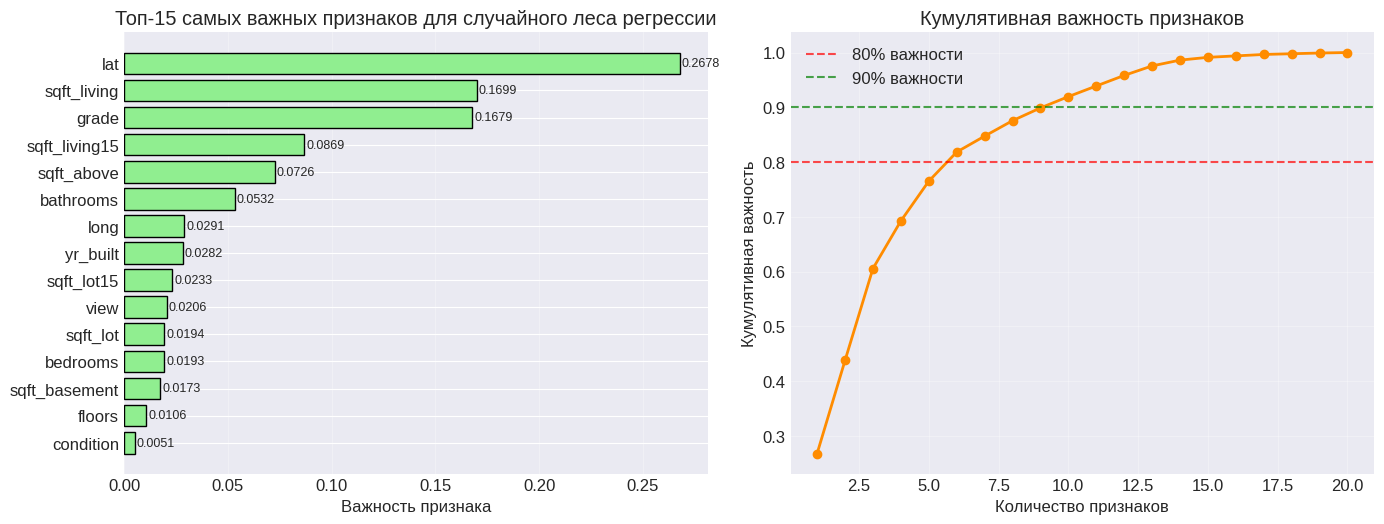


--- 6.3 Предсказания на тестовой выборке ---
Получено 4323 предсказаний цен
Примеры предсказанных цен (первые 5): $[ 359156  726706 1001874 1749713  711982]
Примеры фактических цен (первые 5):   $[ 364999  864999 1037999 1490000  711000]

Примеры предсказаний от первых 5 деревьев (первый объект):
  Дерево 1: $376,610
  Дерево 2: $317,171
  Дерево 3: $386,523
  Дерево 4: $327,189
  Дерево 5: $319,609

--- 6.4 Оценка качества модели (метрики) ---
Метрики в логарифмированной шкале (более устойчивые):
  • RMSE (log scale): 0.1974
  • MAE (log scale):  0.1429
  • R² (log scale):   0.8633

Метрики в оригинальной шкале (доллары):
  • RMSE:            $174,700
  • MAE:             $85,626
  • MAPE:            14.48%
  • R²:              0.7981
  • OOB R²:         0.8609
  • Разница с тестовым R²: -0.0628

--- 6.5 Визуализация результатов регрессии ---


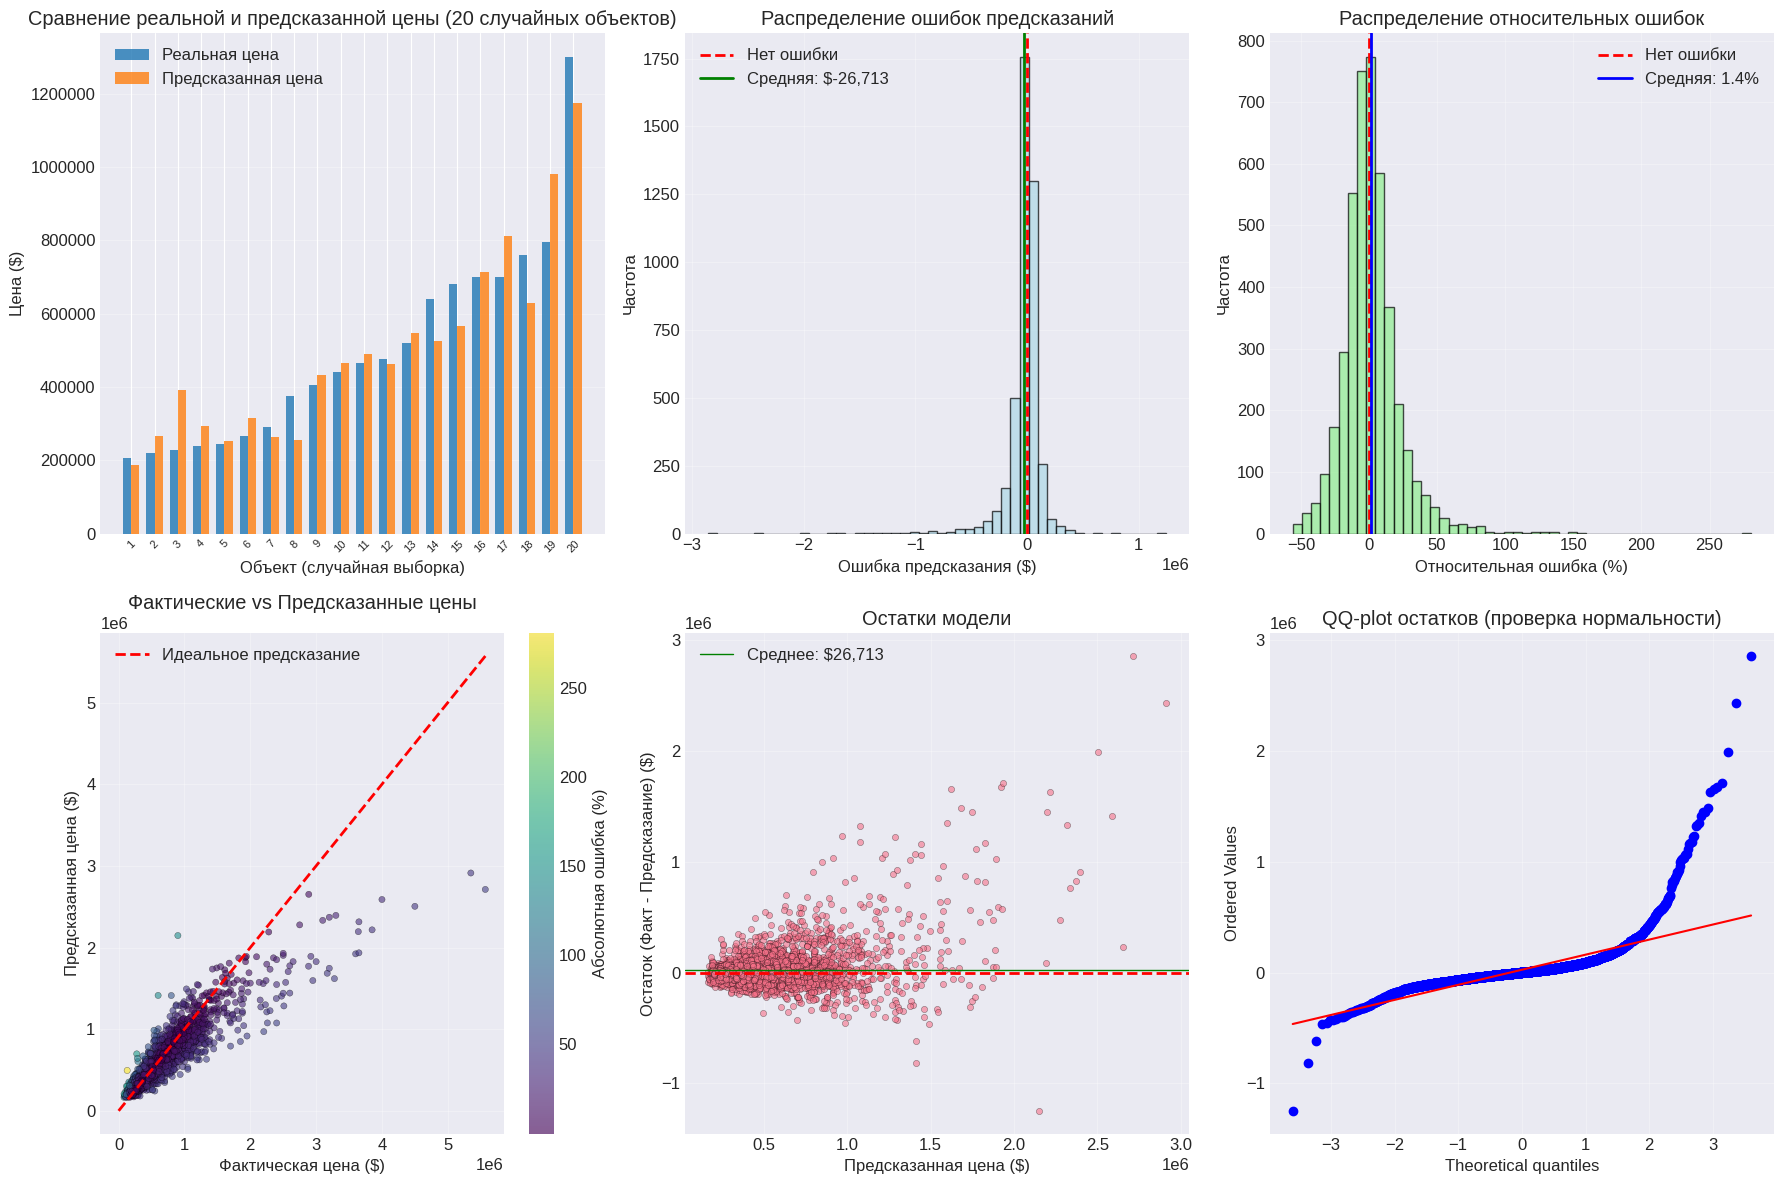


--- 6.6 Статистика ошибок предсказаний ---
Процентили абсолютных ошибок (в долларах):
  • 25%: $19,575
  • 50% (медиана): $45,880
  • 75%: $92,144
  • 90%: $178,113
  • 95%: $289,805

Процент предсказаний с заданной точностью:
  • Ошибка ≤ 10%: 48.6% предсказаний
  • Ошибка ≤ 20%: 76.2% предсказаний
  • Ошибка ≤ 30%: 88.8% предсказаний

--- 6.7 Сравнение реальных и предсказанных цен ---
Средняя цена: реальная = $549,367, предсказанная = $522,655
Медианная цена: реальная = $455,000, предсказанная = $452,196
Средняя ошибка: $-26,713 (смещение модели)
Средняя абсолютная ошибка: $85,626 (14.5%)

--- 6.8 Анализ остатков модели ---
Статистика остатков:
  • Средний остаток: $26,713
  • Стандартное отклонение: $172,645
  • Минимальный остаток: $-1,246,834
  • Максимальный остаток: $2,858,424
  • Процент положительных остатков: 52.0%

--- 6.9 Анализ отдельных деревьев ---
Статистика качества отдельных деревьев (R² на тесте):
  • Средний R²: 0.7554
  • Лучший R²:  0.7933
  • Худший R²:  0.7004


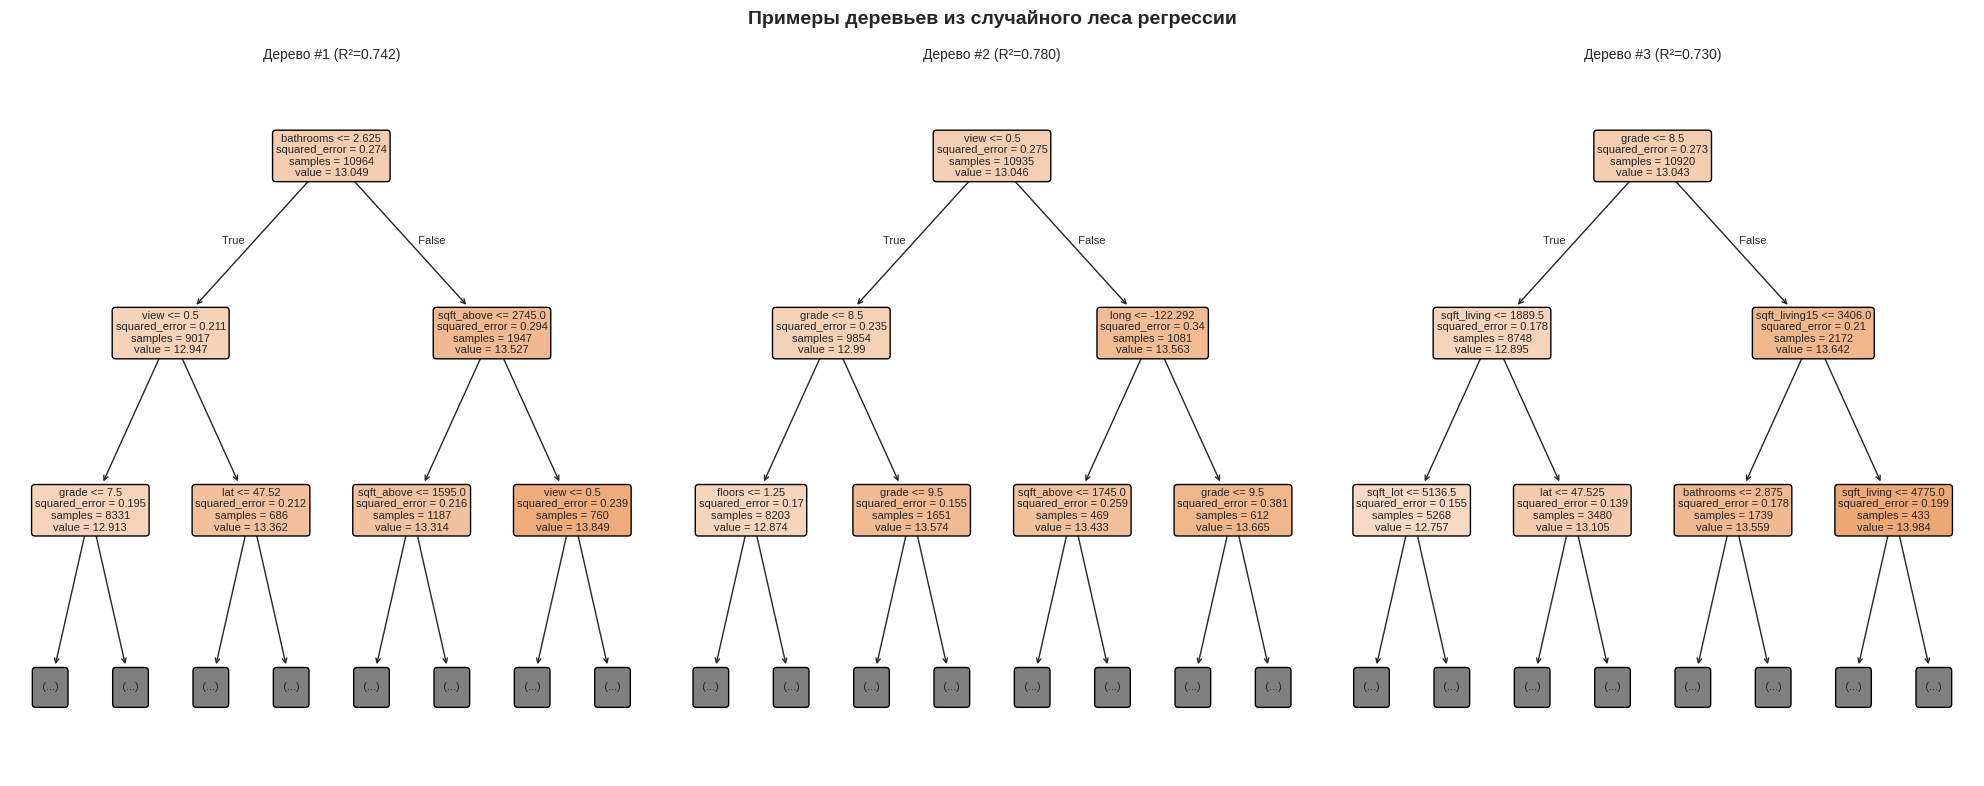


--- 6.11 Параметры модели ---
Использованные параметры случайного леса регрессии:
• n_estimators: 100
• max_depth: None
• min_samples_split: 20
• min_samples_leaf: 10
• max_features: sqrt
• bootstrap: True
• oob_score: True
• random_state: 42


In [17]:
# Ячейка 6: ПОСТРОЕНИЕ БЕЙСЛАЙНА ДЛЯ РЕГРЕССИИ (Случайный лес)
# 6.1 Обучение базовой модели случайного леса регрессии
print("\n--- 6.1 Обучение базовой модели случайного леса регрессии ---")

# Создаем модель случайного леса для регрессии
rf_regressor = RandomForestRegressor(
    random_state=42,
    n_estimators=100,         # Количество деревьев в лесу
    max_depth=None,           # Не ограничиваем глубину для начала (потом настроим)
    min_samples_split=20,     # Минимальное количество образцов для разделения узла
    min_samples_leaf=10,      # Минимальное количество образцов в листе
    max_features='sqrt',      # Количество признаков для рассмотрения в каждом разбиении
    bootstrap=True,           # Использовать бутстрэп выборки
    oob_score=True,           # Рассчитать OOB оценку
    n_jobs=-1                # Использовать все доступные ядра
)

# Обучаем модель на обучающей выборке
print("Обучаем модель случайного леса для регрессии...")
rf_regressor.fit(X_train_reg, y_train_reg)
print("Модель обучена успешно!")

# Анализ OOB (Out-of-Bag) ошибки
if hasattr(rf_regressor, 'oob_score_'):
    print(f"OOB R² score: {rf_regressor.oob_score_:.4f}")

# Анализ структуры деревьев
print(f"\nАнализ ансамбля из {rf_regressor.n_estimators} деревьев:")
depths = [estimator.get_depth() for estimator in rf_regressor.estimators_]
n_leaves = [estimator.get_n_leaves() for estimator in rf_regressor.estimators_]
print(f"  • Средняя глубина: {np.mean(depths):.1f}")
print(f"  • Среднее количество листьев: {np.mean(n_leaves):.1f}")
print(f"  • Размер бутстрэп выборки: ~{int(len(X_train_reg) * 0.63)} образцов")
print(f"  • Примерный размер OOB выборки: ~{int(len(X_train_reg) * 0.37)} образцов")

# 6.2 Анализ важности признаков в случайном лесе
print("\n--- 6.2 Анализ важности признаков ---")

# Получаем важность признаков из случайного леса
feature_importance = rf_regressor.feature_importances_
importance_df = pd.DataFrame({
    'Признак': feature_names_reg,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False).head(15)

print("Топ-15 самых важных признаков для предсказания цены дома:")
for i, row in importance_df.iterrows():
    print(f"  {row['Признак']:30} → {row['Важность']:.4f}")

# Сравнение со средним значением важности
mean_importance = feature_importance.mean()
print(f"\nСредняя важность признака: {mean_importance:.4f}")
print(f"Количество признаков выше средней важности: {(feature_importance > mean_importance).sum()}")

# Визуализация важности признаков
plt.figure(figsize=(14, 10))

# 1. Столбчатая диаграмма важности признаков
plt.subplot(2, 2, 1)
bars = plt.barh(range(len(importance_df)), importance_df['Важность'][::-1], 
                color='lightgreen', edgecolor='black')
plt.yticks(range(len(importance_df)), importance_df['Признак'][::-1])
plt.xlabel('Важность признака')
plt.title('Топ-15 самых важных признаков для случайного леса регрессии')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на столбцы
for i, (bar, importance) in enumerate(zip(bars, importance_df['Важность'][::-1])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=9)

# 2. Кумулятивная важность признаков
plt.subplot(2, 2, 2)
sorted_importance = np.sort(feature_importance)[::-1]
cumulative_importance = sorted_importance.cumsum()
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
         marker='o', linewidth=2, color='darkorange')
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% важности')
plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% важности')
plt.xlabel('Количество признаков')
plt.ylabel('Кумулятивная важность')
plt.title('Кумулятивная важность признаков')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6.3 Предсказания на тестовой выборке
print("\n--- 6.3 Предсказания на тестовой выборке ---")

# Получаем предсказания (логарифмированные цены)
y_pred_reg_log = rf_regressor.predict(X_test_reg)

# Преобразуем обратно из логарифма в обычные цены
y_pred_reg = np.expm1(y_pred_reg_log)

# Преобразуем y_test_reg из логарифмированной шкалы в обычные цены
y_test_reg_original = np.expm1(y_test_reg)

print(f"Получено {len(y_pred_reg)} предсказаний цен")
print(f"Примеры предсказанных цен (первые 5): ${y_pred_reg[:5].astype(int)}")
print(f"Примеры фактических цен (первые 5):   ${y_test_reg_original.iloc[:5].astype(int).values}")

# Также получаем предсказания от отдельных деревьев (для анализа)
n_trees_to_show = 5
tree_predictions = np.array([tree.predict(X_test_reg) for tree in rf_regressor.estimators_[:n_trees_to_show]])
tree_predictions_original = np.expm1(tree_predictions)

print(f"\nПримеры предсказаний от первых {n_trees_to_show} деревьев (первый объект):")
for i in range(n_trees_to_show):
    print(f"  Дерево {i+1}: ${tree_predictions_original[i, 0]:,.0f}")

# 6.4 Оценка качества модели (метрики)
print("\n--- 6.4 Оценка качества модели (метрики) ---")

# Основные метрики в логарифмированной шкале (более устойчивые)
rmse_log = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_log))
mae_log = mean_absolute_error(y_test_reg, y_pred_reg_log)
r2_log = r2_score(y_test_reg, y_pred_reg_log)

# Метрики в оригинальной шкале (доллары)
rmse = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_reg))
mae = mean_absolute_error(y_test_reg_original, y_pred_reg)
mape = mean_absolute_percentage_error(y_test_reg_original, y_pred_reg)
r2 = r2_score(y_test_reg_original, y_pred_reg)

print("Метрики в логарифмированной шкале (более устойчивые):")
print(f"  • RMSE (log scale): {rmse_log:.4f}")
print(f"  • MAE (log scale):  {mae_log:.4f}")
print(f"  • R² (log scale):   {r2_log:.4f}")

print("\nМетрики в оригинальной шкале (доллары):")
print(f"  • RMSE:            ${rmse:,.0f}")
print(f"  • MAE:             ${mae:,.0f}")
print(f"  • MAPE:            {mape*100:.2f}%")
print(f"  • R²:              {r2:.4f}")

# Сравнение с OOB оценкой
if hasattr(rf_regressor, 'oob_score_'):
    print(f"  • OOB R²:         {rf_regressor.oob_score_:.4f}")
    print(f"  • Разница с тестовым R²: {(r2 - rf_regressor.oob_score_):.4f}")

# 6.5 Визуализация результатов регрессии
print("\n--- 6.5 Визуализация результатов регрессии ---")

# Создаем DataFrame для удобства анализа
y_test_array = y_test_reg_original.values if hasattr(y_test_reg_original, 'values') else y_test_reg_original

results_df = pd.DataFrame({
    'Фактическая_цена': y_test_array,
    'Предсказанная_цена': y_pred_reg,
    'Относительная_ошибка_%': ((y_pred_reg - y_test_array) / y_test_array) * 100,
    'Абсолютная_ошибка': np.abs(y_pred_reg - y_test_array)
})

# Рассчитываем ошибки для графиков
errors = y_pred_reg - y_test_array
relative_errors = (errors / y_test_array) * 100

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# График 1: Сравнение реальной и предсказанной цены
np.random.seed(42)
n_samples = min(20, len(results_df))
sample_indices = np.random.choice(len(results_df), n_samples, replace=False)
sample_df = results_df.iloc[sample_indices].copy()
sample_df = sample_df.sort_values('Фактическая_цена')

x_pos = np.arange(len(sample_df))
width = 0.35

bars_actual = axes[0, 0].bar(x_pos - width/2, sample_df['Фактическая_цена'], 
                            width, label='Реальная цена', color='#1f77b4', alpha=0.8)
bars_pred = axes[0, 0].bar(x_pos + width/2, sample_df['Предсказанная_цена'], 
                          width, label='Предсказанная цена', color='#ff7f0e', alpha=0.8)

axes[0, 0].set_xlabel('Объект (случайная выборка)')
axes[0, 0].set_ylabel('Цена ($)')
axes[0, 0].set_title('Сравнение реальной и предсказанной цены (20 случайных объектов)')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([f'{i+1}' for i in range(len(sample_df))], rotation=45, fontsize=8)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# График 2: Ошибки предсказаний
axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='lightblue')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Нет ошибки')
axes[0, 1].axvline(x=np.mean(errors), color='green', linestyle='-', linewidth=2, 
                   label=f'Средняя: ${np.mean(errors):,.0f}')
axes[0, 1].set_xlabel('Ошибка предсказания ($)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение ошибок предсказаний')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# График 3: Относительные ошибки
axes[0, 2].hist(relative_errors, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Нет ошибки')
axes[0, 2].axvline(x=np.mean(relative_errors), color='blue', linestyle='-', linewidth=2,
                   label=f'Средняя: {np.mean(relative_errors):.1f}%')
axes[0, 2].set_xlabel('Относительная ошибка (%)')
axes[0, 2].set_ylabel('Частота')
axes[0, 2].set_title('Распределение относительных ошибок')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# График 4: Фактические vs предсказанные цены
scatter = axes[1, 0].scatter(results_df['Фактическая_цена'], results_df['Предсказанная_цена'],
                            c=np.abs(results_df['Относительная_ошибка_%']),
                            cmap='viridis', alpha=0.6, s=20, edgecolors='black', linewidth=0.3)

# Линия идеального предсказания
max_price = max(results_df['Фактическая_цена'].max(), results_df['Предсказанная_цена'].max())
axes[1, 0].plot([0, max_price], [0, max_price], 'r--', linewidth=2, label='Идеальное предсказание')

axes[1, 0].set_xlabel('Фактическая цена ($)')
axes[1, 0].set_ylabel('Предсказанная цена ($)')
axes[1, 0].set_title('Фактические vs Предсказанные цены')
axes[1, 0].legend(loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Добавляем цветовую шкалу
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Абсолютная ошибка (%)')

# График 5: Остатки vs предсказанные значения
residuals = y_test_array - y_pred_reg
axes[1, 1].scatter(y_pred_reg, residuals, alpha=0.6, s=20, edgecolors='black', linewidth=0.3)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=np.mean(residuals), color='green', linestyle='-', linewidth=1,
                   label=f'Среднее: ${np.mean(residuals):,.0f}')
axes[1, 1].set_xlabel('Предсказанная цена ($)')
axes[1, 1].set_ylabel('Остаток (Факт - Предсказание) ($)')
axes[1, 1].set_title('Остатки модели')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# График 6: QQ-plot остатков
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('QQ-plot остатков (проверка нормальности)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6.6 Статистика ошибок
print("\n--- 6.6 Статистика ошибок предсказаний ---")

# Процентили абсолютных ошибок (в долларах)
abs_errors = np.abs(errors)
error_percentiles = np.percentile(abs_errors, [25, 50, 75, 90, 95])
print("Процентили абсолютных ошибок (в долларах):")
print(f"  • 25%: ${error_percentiles[0]:,.0f}")
print(f"  • 50% (медиана): ${error_percentiles[1]:,.0f}")
print(f"  • 75%: ${error_percentiles[2]:,.0f}")
print(f"  • 90%: ${error_percentiles[3]:,.0f}")
print(f"  • 95%: ${error_percentiles[4]:,.0f}")

# Процент предсказаний с разной точностью
abs_relative_errors = np.abs(relative_errors)
within_10_percent = np.sum(abs_relative_errors <= 10) / len(abs_relative_errors) * 100
within_20_percent = np.sum(abs_relative_errors <= 20) / len(abs_relative_errors) * 100
within_30_percent = np.sum(abs_relative_errors <= 30) / len(abs_relative_errors) * 100

print("\nПроцент предсказаний с заданной точностью:")
print(f"  • Ошибка ≤ 10%: {within_10_percent:.1f}% предсказаний")
print(f"  • Ошибка ≤ 20%: {within_20_percent:.1f}% предсказаний")
print(f"  • Ошибка ≤ 30%: {within_30_percent:.1f}% предсказаний")

# 6.7 Сравнение реальных и предсказанных цен
print("\n--- 6.7 Сравнение реальных и предсказанных цен ---")

mean_actual = np.mean(y_test_array)
mean_pred = np.mean(y_pred_reg)
median_actual = np.median(y_test_array)
median_pred = np.median(y_pred_reg)

print(f"Средняя цена: реальная = ${mean_actual:,.0f}, предсказанная = ${mean_pred:,.0f}")
print(f"Медианная цена: реальная = ${median_actual:,.0f}, предсказанная = ${median_pred:,.0f}")
print(f"Средняя ошибка: ${np.mean(errors):,.0f} (смещение модели)")
print(f"Средняя абсолютная ошибка: ${mae:,.0f} ({mape*100:.1f}%)")

# 6.8 Анализ остатков
print("\n--- 6.8 Анализ остатков модели ---")

print(f"Статистика остатков:")
print(f"  • Средний остаток: ${np.mean(residuals):,.0f}")
print(f"  • Стандартное отклонение: ${np.std(residuals):,.0f}")
print(f"  • Минимальный остаток: ${np.min(residuals):,.0f}")
print(f"  • Максимальный остаток: ${np.max(residuals):,.0f}")
print(f"  • Процент положительных остатков: {np.sum(residuals > 0) / len(residuals) * 100:.1f}%")

# 6.9 Анализ отдельных деревьев в лесу
print("\n--- 6.9 Анализ отдельных деревьев ---")

# Оцениваем качество каждого дерева отдельно
tree_scores = []
for i, tree_model in enumerate(rf_regressor.estimators_):
    tree_pred = tree_model.predict(X_test_reg)
    tree_r2 = r2_score(y_test_reg, tree_pred)
    tree_scores.append(tree_r2)

print(f"Статистика качества отдельных деревьев (R² на тесте):")
print(f"  • Средний R²: {np.mean(tree_scores):.4f}")
print(f"  • Лучший R²:  {np.max(tree_scores):.4f}")
print(f"  • Худший R²:  {np.min(tree_scores):.4f}")
print(f"  • Стандартное отклонение: {np.std(tree_scores):.4f}")
print(f"  • Улучшение ансамбля над средним деревом: {(r2_log - np.mean(tree_scores)):.4f}")

# 6.10 Визуализация нескольких деревьев
print("\n--- 6.10 Визуализация структуры деревьев (пример) ---")

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
for i, ax in enumerate(axes):
    if i < len(rf_regressor.estimators_):
        tree.plot_tree(rf_regressor.estimators_[i], 
                      feature_names=feature_names_reg,
                      filled=True,
                      rounded=True,
                      fontsize=8,
                      max_depth=2,  # Показываем только 2 уровня
                      ax=ax)
        ax.set_title(f'Дерево #{i+1} (R²={tree_scores[i]:.3f})', fontsize=10)
plt.suptitle('Примеры деревьев из случайного леса регрессии', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 6.11 Информация о параметрах модели
print("\n--- 6.11 Параметры модели ---")
print(f"Использованные параметры случайного леса регрессии:")
print(f"• n_estimators: {rf_regressor.n_estimators}")
print(f"• max_depth: {rf_regressor.max_depth}")
print(f"• min_samples_split: {rf_regressor.min_samples_split}")
print(f"• min_samples_leaf: {rf_regressor.min_samples_leaf}")
print(f"• max_features: {rf_regressor.max_features}")
print(f"• bootstrap: {rf_regressor.bootstrap}")
print(f"• oob_score: {True if hasattr(rf_regressor, 'oob_score_') else False}")
print(f"• random_state: {rf_regressor.random_state}")

## 3. Улучшение Безлайна

### Гипотезы для улучшения

**Для случайного леса классификации:**

**Основные результаты:**

- F1-score для увольнений: 0.468 - можно улучшить
Precision = Recall = 0.468 - сбалансированно, но низко
- 53.2% увольнений пропускаем (False Negative)
- OOB score 0.8435 близко к тестовой accuracy 0.83
- Деревья неглубокие: 8-10 уровней

Гипотезы для улучшения:

1. Увеличить количество деревьев - с 100 до 200-300 для лучшей стабильности

2. Увеличить глубину деревьев - с 10 до 15-20 для лучшего разделения классов

3. Точно настроить баланс классов - class_weight={0: 1, 1: 3} вместо 'balanced'

4. Уменьшить min_samples_leaf - с 10 до 3-5 для большей чувствительности к меньшему классу

**Для случайного леса регрессии:**

**Основные результаты:**

- R² = 0.7981, OOB R² = 0.8609 - есть переобучение
- RMSE $174K, MAE $85K, MAPE 14.5%
- Систематическое смещение: -$26,713 (недооцениваем цены)
- 48.6% предсказаний с ошибкой ≤10%, 76.2% ≤20%

Гипотезы для улучшения:

1. Ограничить глубину деревьев - до 15-20 для борьбы с переобучением

2. Увеличить min_samples_split - с 20 до 30-50 для лучшего обобщения

3. Добавить интерактивные признаки:

- price_per_sqft (логарифмированный)

- living_to_lot_ratio = sqft_living / sqft_lot

- house_age = 2024 - yr_built

4. Использовать MAE как критерий - criterion='absolute_error' для устойчивости к выбросам



--- 7.1 Анализ ---

ТЕКУЩИЕ ПАРАМЕТРЫ БЕЙЗЛАЙН МОДЕЛИ:
• n_estimators: 100
• max_depth: 10
• min_samples_split: 20
• min_samples_leaf: 10
• class_weight: balanced
• max_features: sqrt
• OOB score: 0.8435

СТАТИСТИКА АНСАМБЛЯ:
• Средняя глубина деревьев: 9.6
• Среднее количество листьев: 45.8
• Минимальная глубина: 8
• Максимальная глубина: 10

--- 7.2 Проверка гипотез ---

ПАРАМЕТРЫ ДЛЯ ОПТИМИЗАЦИИ:
  n_estimators: [200, 300, 400]
  max_depth: [15, 20, None]
  min_samples_split: [10, 20, 30]
  min_samples_leaf: [3, 5, 7, 10]
  max_features: ['sqrt', 'log2', 0.5, 0.7]
  class_weight: ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]
  bootstrap: [True]
  oob_score: [True]

Будет проверено 50 случайных комбинаций из 1,728 возможных

Запускаем RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- 7.3 Анализ результатов ---

ТОП-5 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:

1. F1-score: 0.4886 (OOB: 0.8105)
   n_estimators: 400
   max_depth: None
   min_samples_

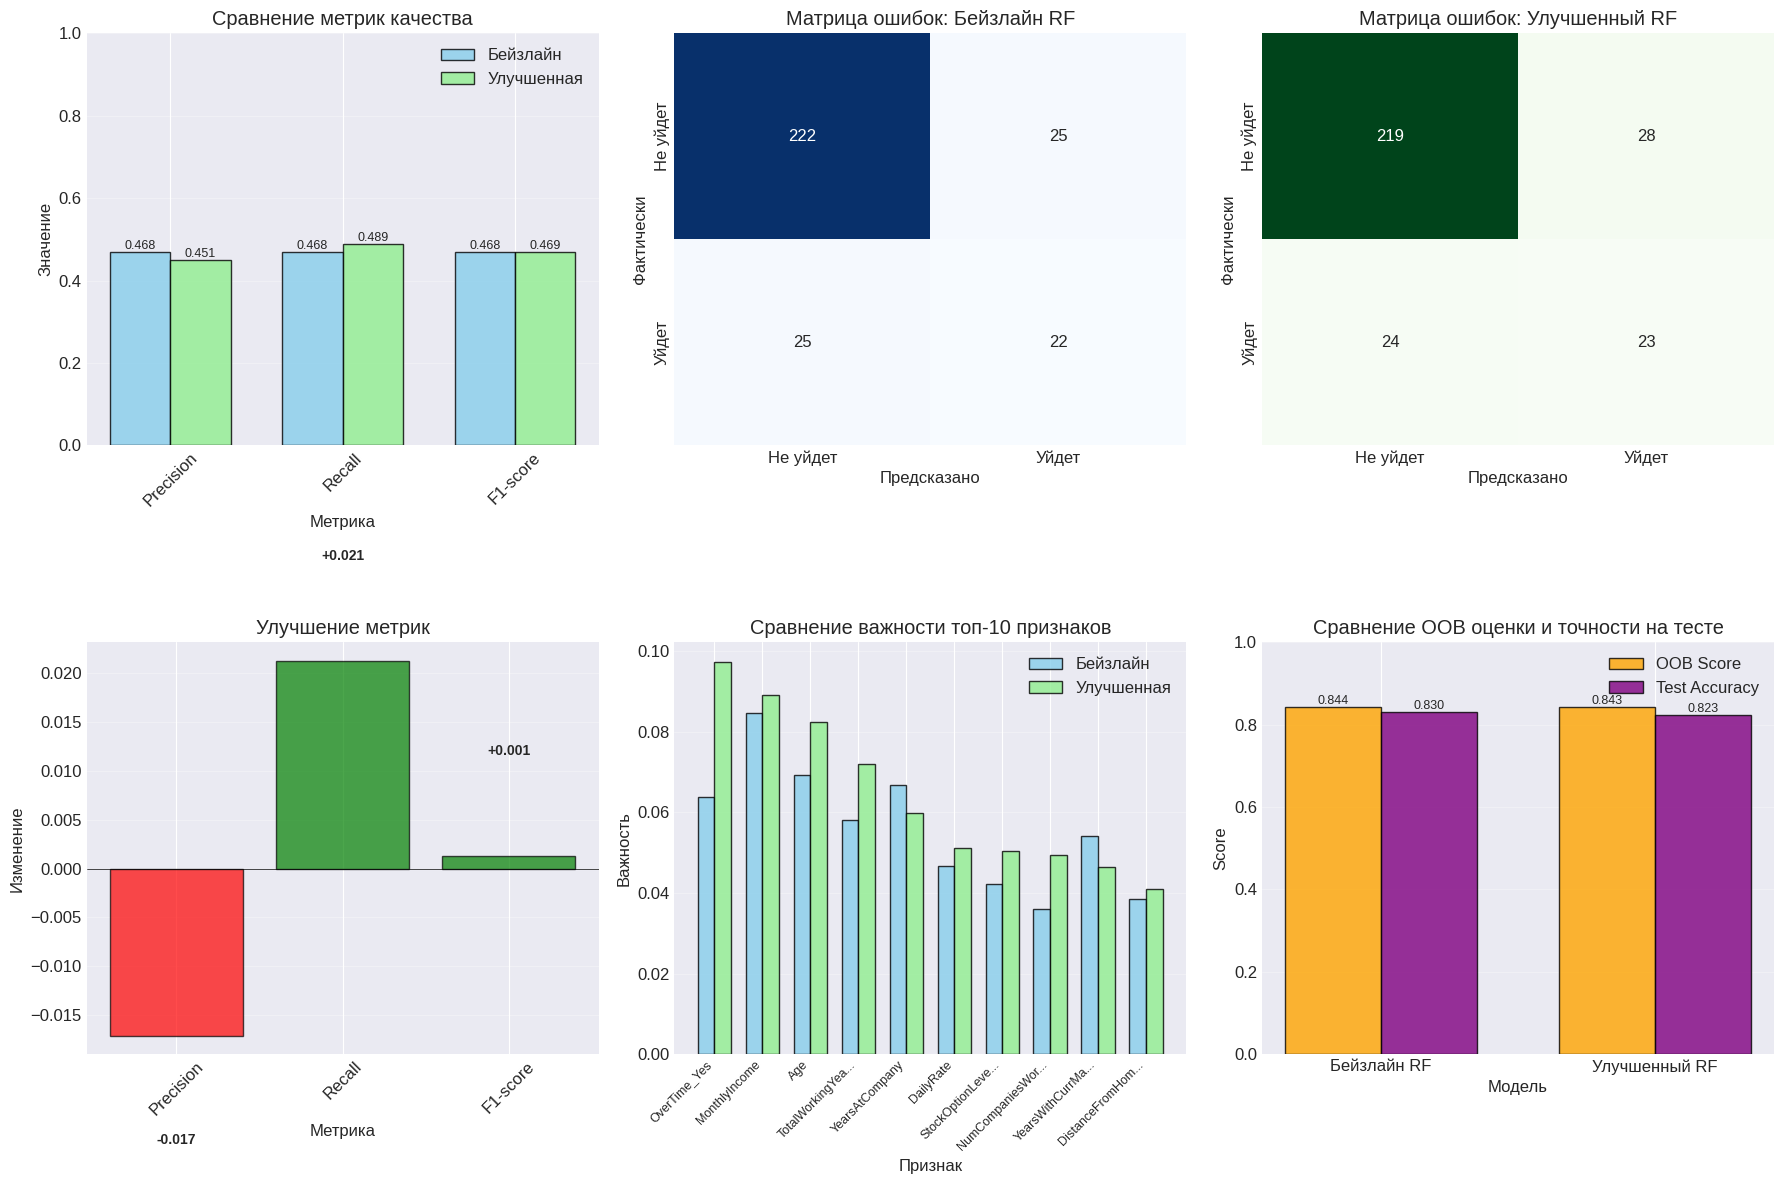

In [ ]:
# Ячейка 7: УЛУЧШЕНИЕ СЛУЧАЙНОГО ЛЕСА КЛАССИФИКАЦИИ
# 7.1 Анализ проблем и формирование гипотез
print("\n--- 7.1 Анализ ---")

print("\nТекущие парметры безлайн модели:")
print(f"• n_estimators: {rf_classifier.n_estimators}")
print(f"• max_depth: {rf_classifier.max_depth}")
print(f"• min_samples_split: {rf_classifier.min_samples_split}")
print(f"• min_samples_leaf: {rf_classifier.min_samples_leaf}")
print(f"• class_weight: {rf_classifier.class_weight}")
print(f"• max_features: {rf_classifier.max_features}")
print(f"• OOB score: {rf_classifier.oob_score_:.4f}")

# Сбор статистики по ансамблю
print("\nСтатистика ансамбля:")
depths = [tree.get_depth() for tree in rf_classifier.estimators_]
n_leaves = [tree.get_n_leaves() for tree in rf_classifier.estimators_]
print(f"• Средняя глубина деревьев: {np.mean(depths):.1f}")
print(f"• Среднее количество листьев: {np.mean(n_leaves):.1f}")
print(f"• Минимальная глубина: {min(depths)}")
print(f"• Максимальная глубина: {max(depths)}")

# 7.2 Создание и проверка гипотез с помощью RandomizedSearchCV
print("\n--- 7.2 Проверка гипотез ---")

# Создаем пространство параметров для Random Forest
param_grid_rf = {
    'n_estimators': [200, 300, 400],           # Гипотеза 1: Увеличить количество деревьев
    'max_depth': [15, 20, None],               # Гипотеза 2: Увеличить глубину
    'min_samples_split': [10, 20, 30],        # Поиск оптимального значения
    'min_samples_leaf': [3, 5, 7, 10],        # Гипотеза 4: Уменьшить для чувствительности
    'max_features': ['sqrt', 'log2', 0.5, 0.7], # Разнообразие деревьев
    'class_weight': [
        'balanced',
        {0: 1, 1: 2},                          # Гипотеза 3: Точная настройка баланса
        {0: 1, 1: 3},
        {0: 1, 1: 4}
    ],
    'bootstrap': [True],
    'oob_score': [True]
}

print("\nПараметры для оптимизации:")
for param, values in param_grid_rf.items():
    print(f"  {param}: {values}")

n_iter = 50  # Количество случайных комбинаций для проверки
print(f"\nБудет проверено {n_iter} случайных комбинаций из {np.prod([len(v) for v in param_grid_rf.values()]):,} возможных")

# Используем F1-score как основную метрику
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_grid_rf,
    n_iter=n_iter,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("\nЗапускаем RandomizedSearchCV...")
random_search_rf.fit(X_train_class, y_train_class)

# 7.3 Анализ результатов RandomizedSearch
print("\n--- 7.3 Анализ результатов ---")

# Получаем результаты в DataFrame
results_df = pd.DataFrame(random_search_rf.cv_results_)

# Сортируем по F1-score и берем топ-5
top_results = results_df.nsmallest(5, 'rank_test_score')

print("\nТОП-5 ЛУЧШИХ КОМБИНАЦИЙ ПАРАМЕТРОВ:")
print("=" * 90)
for i, (_, row) in enumerate(top_results.iterrows(), 1):
    print(f"\n{i}. F1-score: {row['mean_test_score']:.4f} (OOB: {row['mean_train_score']:.4f})")
    print(f"   n_estimators: {row['param_n_estimators']}")
    print(f"   max_depth: {row['param_max_depth']}")
    print(f"   min_samples_leaf: {row['param_min_samples_leaf']}")
    print(f"   max_features: {row['param_max_features']}")
    print(f"   class_weight: {row['param_class_weight']}")

# Анализ влияния отдельных параметров
print("\n--- АНАЛИЗ ВЛИЯНИЯ ПАРАМЕТРОВ НА F1-SCORE ---")

# Анализируем влияние class_weight
print("\nВЛИЯНИЕ class_weight на F1-score:")
results_df['class_weight_str'] = results_df['param_class_weight'].apply(lambda x: str(x)[:50])
cw_stats = results_df.groupby('class_weight_str')['mean_test_score'].agg(['mean', 'std', 'count'])
for cw_str, stats in cw_stats.iterrows():
    print(f"  {cw_str:<40} → Средний F1: {stats['mean']:.4f} ±{stats['std']:.4f} (n={int(stats['count'])})")

# Анализируем влияние n_estimators
print("\nВЛИЯНИЕ n_estimators на F1-score:")
n_estimators_stats = results_df.groupby('param_n_estimators')['mean_test_score'].agg(['mean', 'std', 'count'])
for n, stats in n_estimators_stats.iterrows():
    print(f"  {n:<10} → Средний F1: {stats['mean']:.4f} ±{stats['std']:.4f} (n={int(stats['count'])})")

# Анализируем влияние max_depth
print("\nВЛИЯНИЕ max_depth на F1-score:")
depth_stats = results_df.groupby('param_max_depth')['mean_test_score'].agg(['mean', 'std', 'count'])
for depth, stats in depth_stats.iterrows():
    depth_str = "None" if depth is None else str(depth)
    print(f"  {depth_str:<10} → Средний F1: {stats['mean']:.4f} ±{stats['std']:.4f} (n={int(stats['count'])})")

# 7.4 Создание улучшенной модели с лучшими параметрами
print("\n--- 7.4 Создание улучшенной модели ---")

# Получаем лучшие параметры
best_params = random_search_rf.best_params_

# Создаем улучшенную модель случайного леса
improved_rf = RandomForestClassifier(
    random_state=42,
    n_estimators=best_params.get('n_estimators', 300),
    max_depth=best_params.get('max_depth', 20),
    min_samples_split=best_params.get('min_samples_split', 20),
    min_samples_leaf=best_params.get('min_samples_leaf', 5),
    max_features=best_params.get('max_features', 'sqrt'),
    class_weight=best_params.get('class_weight', 'balanced'),
    bootstrap=True,
    oob_score=True,
    n_jobs=-1
)

print("Обучаем улучшенную модель случайного леса...")
improved_rf.fit(X_train_class, y_train_class)
print("Улучшенная модель обучена успешно!")

print("\nПАРАМЕТРЫ УЛУЧШЕННОЙ МОДЕЛИ:")
print(f"• n_estimators:      {improved_rf.n_estimators}")
print(f"• max_depth:         {improved_rf.max_depth}")
print(f"• min_samples_split: {improved_rf.min_samples_split}")
print(f"• min_samples_leaf:  {improved_rf.min_samples_leaf}")
print(f"• max_features:      {improved_rf.max_features}")
print(f"• class_weight:      {improved_rf.class_weight}")
print(f"• OOB score:         {improved_rf.oob_score_:.4f}")

# Анализ ансамбля улучшенной модели
print("\nСТАТИСТИКА УЛУЧШЕННОГО АНСАМБЛЯ:")
imp_depths = [tree.get_depth() for tree in improved_rf.estimators_]
imp_leaves = [tree.get_n_leaves() for tree in improved_rf.estimators_]
print(f"• Средняя глубина деревьев: {np.mean(imp_depths):.1f}")
print(f"• Среднее количество листьев: {np.mean(imp_leaves):.1f}")
print(f"• Минимальная глубина: {min(imp_depths)}")
print(f"• Максимальная глубина: {max(imp_depths)}")

# 7.5 Оценка качества улучшенной модели
print("\n--- 7.5 Оценка качества ---")

# Предсказания улучшенной модели
y_pred_improved = improved_rf.predict(X_test_class)
y_pred_proba_improved = improved_rf.predict_proba(X_test_class)[:, 1]

# Вычисляем метрики
cm_improved = confusion_matrix(y_test_class, y_pred_improved)
tn_improve, fp_improve, fn_improve, tp_improve = cm_improved.ravel()

accuracy_improve = (tp_improve + tn_improve) / (tp_improve + tn_improve + fp_improve + fn_improve)
precision_improve = tp_improve / (tp_improve + fp_improve) if (tp_improve + fp_improve) > 0 else 0
recall_improve = tp_improve / (tp_improve + fn_improve) if (tp_improve + fn_improve) > 0 else 0
f1_improve = 2 * precision_improve * recall_improve / (precision_improve + recall_improve) if (precision_improve + recall_improve) > 0 else 0

print("\n" + "="*80)
print("СРАВНЕНИЕ МЕТРИК:")
print("="*80)
print(f"{'Метрика':<15} {'Бейзлайн':<15} {'Улучшенная':<15} {'Изменение':<15}")
print("-" * 60)
print(f"{'Accuracy':<15} {accuracy:<15.4f} {accuracy_improve:<15.4f} {accuracy_improve - accuracy:+.4f}")
print(f"{'Precision':<15} {precision:<15.4f} {precision_improve:<15.4f} {precision_improve - precision:+.4f}")
print(f"{'Recall':<15} {recall:<15.4f} {recall_improve:<15.4f} {recall_improve - recall:+.4f}")
print(f"{'F1-score':<15} {f1:<15.4f} {f1_improve:<15.4f} {f1_improve - f1:+.4f}")
print(f"{'OOB score':<15} {rf_classifier.oob_score_:<15.4f} {improved_rf.oob_score_:<15.4f} {improved_rf.oob_score_ - rf_classifier.oob_score_:+.4f}")

print(f"\n{'':<20} {'Бейзлайн':<20} {'Улучшенная':<20}")
print("-" * 60)
print(f"{'False Positive':<20} {fp:<20} {fp_improve:<20}")
print(f"{'False Negative':<20} {fn:<20} {fn_improve:<20}")
print(f"{'True Positive':<20} {tp:<20} {tp_improve:<20}")
print(f"{'True Negative':<20} {tn:<20} {tn_improve:<20}")
print(f"{'Всего деревьев':<20} {rf_classifier.n_estimators:<20} {improved_rf.n_estimators:<20}")
print(f"{'Ср. глубина':<20} {np.mean(depths):<20.1f} {np.mean(imp_depths):<20.1f}")

# 7.6 Визуализация сравнения моделей
print("\n--- 7.6 Визуализация сравнения моделей ---")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Сравнение метрик
metrics = ['Precision', 'Recall', 'F1-score']
base_vals = [precision, recall, f1]
imp_vals = [precision_improve, recall_improve, f1_improve]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, base_vals, width, label='Бейзлайн', 
                       color='skyblue', edgecolor='black', alpha=0.8)
bars2 = axes[0, 0].bar(x + width/2, imp_vals, width, label='Улучшенная', 
                       color='lightgreen', edgecolor='black', alpha=0.8)

axes[0, 0].set_xlabel('Метрика')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].set_title('Сравнение метрик качества')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim(0, 1)

# Добавляем значения на столбцы
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    axes[0, 0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                   f'{base_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0, 0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                   f'{imp_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Матрица ошибок - Бейзлайн
sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues', 
            ax=axes[0, 1], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[0, 1].set_title('Матрица ошибок: Бейзлайн RF')
axes[0, 1].set_xlabel('Предсказано')
axes[0, 1].set_ylabel('Фактически')

# 3. Матрица ошибок - Улучшенная
sns.heatmap([[tn_improve, fp_improve], [fn_improve, tp_improve]], annot=True, fmt='d', cmap='Greens', 
            ax=axes[0, 2], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[0, 2].set_title('Матрица ошибок: Улучшенный RF')
axes[0, 2].set_xlabel('Предсказано')
axes[0, 2].set_ylabel('Фактически')

# 4. Изменение метрик
improvement = [imp - base for imp, base in zip(imp_vals, base_vals)]
colors = ['green' if x > 0 else 'red' for x in improvement]

bars = axes[1, 0].bar(metrics, improvement, color=colors, edgecolor='black', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].set_xlabel('Метрика')
axes[1, 0].set_ylabel('Изменение')
axes[1, 0].set_title('Улучшение метрик')
axes[1, 0].set_xticklabels(metrics, rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, (metric, imp) in enumerate(zip(metrics, improvement)):
    va = 'bottom' if imp >= 0 else 'top'
    axes[1, 0].text(i, imp + (0.01 if imp >= 0 else -0.01), 
                   f'{imp:+.3f}', ha='center', va=va,
                   fontsize=10, fontweight='bold')

# 5. Сравнение важности признаков (топ-10)
top_n = 10
base_importance = rf_classifier.feature_importances_
imp_importance = improved_rf.feature_importances_

# Находим индексы топ-10 признаков по улучшенной модели
top_indices = np.argsort(imp_importance)[-top_n:][::-1]

top_features = [feature_names_class[i] for i in top_indices]
base_top_vals = [base_importance[i] for i in top_indices]
imp_top_vals = [imp_importance[i] for i in top_indices]

x = np.arange(top_n)
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, base_top_vals, width, label='Бейзлайн', 
                       color='skyblue', edgecolor='black', alpha=0.8)
bars2 = axes[1, 1].bar(x + width/2, imp_top_vals, width, label='Улучшенная', 
                       color='lightgreen', edgecolor='black', alpha=0.8)

axes[1, 1].set_xlabel('Признак')
axes[1, 1].set_ylabel('Важность')
axes[1, 1].set_title(f'Сравнение важности топ-{top_n} признаков')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in top_features], 
                           rotation=45, ha='right', fontsize=9)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Сравнение OOB и тестовой точности
models = ['Бейзлайн RF', 'Улучшенный RF']
oob_scores = [rf_classifier.oob_score_, improved_rf.oob_score_]
test_accuracies = [accuracy, accuracy_improve]

x = np.arange(len(models))
width = 0.35

bars1 = axes[1, 2].bar(x - width/2, oob_scores, width, label='OOB Score', 
                       color='orange', edgecolor='black', alpha=0.8)
bars2 = axes[1, 2].bar(x + width/2, test_accuracies, width, label='Test Accuracy', 
                       color='purple', edgecolor='black', alpha=0.8)

axes[1, 2].set_xlabel('Модель')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Сравнение OOB оценки и точности на тесте')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(models)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')
axes[1, 2].set_ylim(0, 1)

# Добавляем значения на столбцы
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    axes[1, 2].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                   f'{oob_scores[i]:.3f}', ha='center', va='bottom', fontsize=9)
    axes[1, 2].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                   f'{test_accuracies[i]:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


--- 8.1 Анализ ---

Текущие параметры бейзлайн модели случайного леса:
• n_estimators: 100
• max_depth: None
• min_samples_split: 20
• min_samples_leaf: 10
• max_features: sqrt
• OOB R²: 0.8609
• criterion: squared_error

--- 8.2 Создание ключевых интерактивных признаков ---
Создаем самые важные интерактивные признаки...
 Создан признак: log_sqft_living
 Создан признак: living_to_lot_ratio
Всего признаков: 22

--- 8.3 Подготовка данных ---
Обучающая выборка: (17290, 22)
Тестовая выборка: (4323, 22)

--- 8.4 Быстрое улучшение модели ---
Используем ручную настройку параметров на основе гипотез:

Тестируем: Улучшенная (с MSE)
  R²: 0.8040, RMSE: $172,148, OOB R²: 0.8638

Тестируем: Улучшенная (с MAE)
  R²: 0.7954, RMSE: $175,882, OOB R²: 0.8595

Лучшая модель: Улучшенная (с MSE)

--- 8.5 Оценка улучшенной модели ---

Сравнение с бейзлайном:
Метрика         Бейзлайн        Улучшенная      Изменение      
----------------------------------------------------------------------
RMSE ($)      

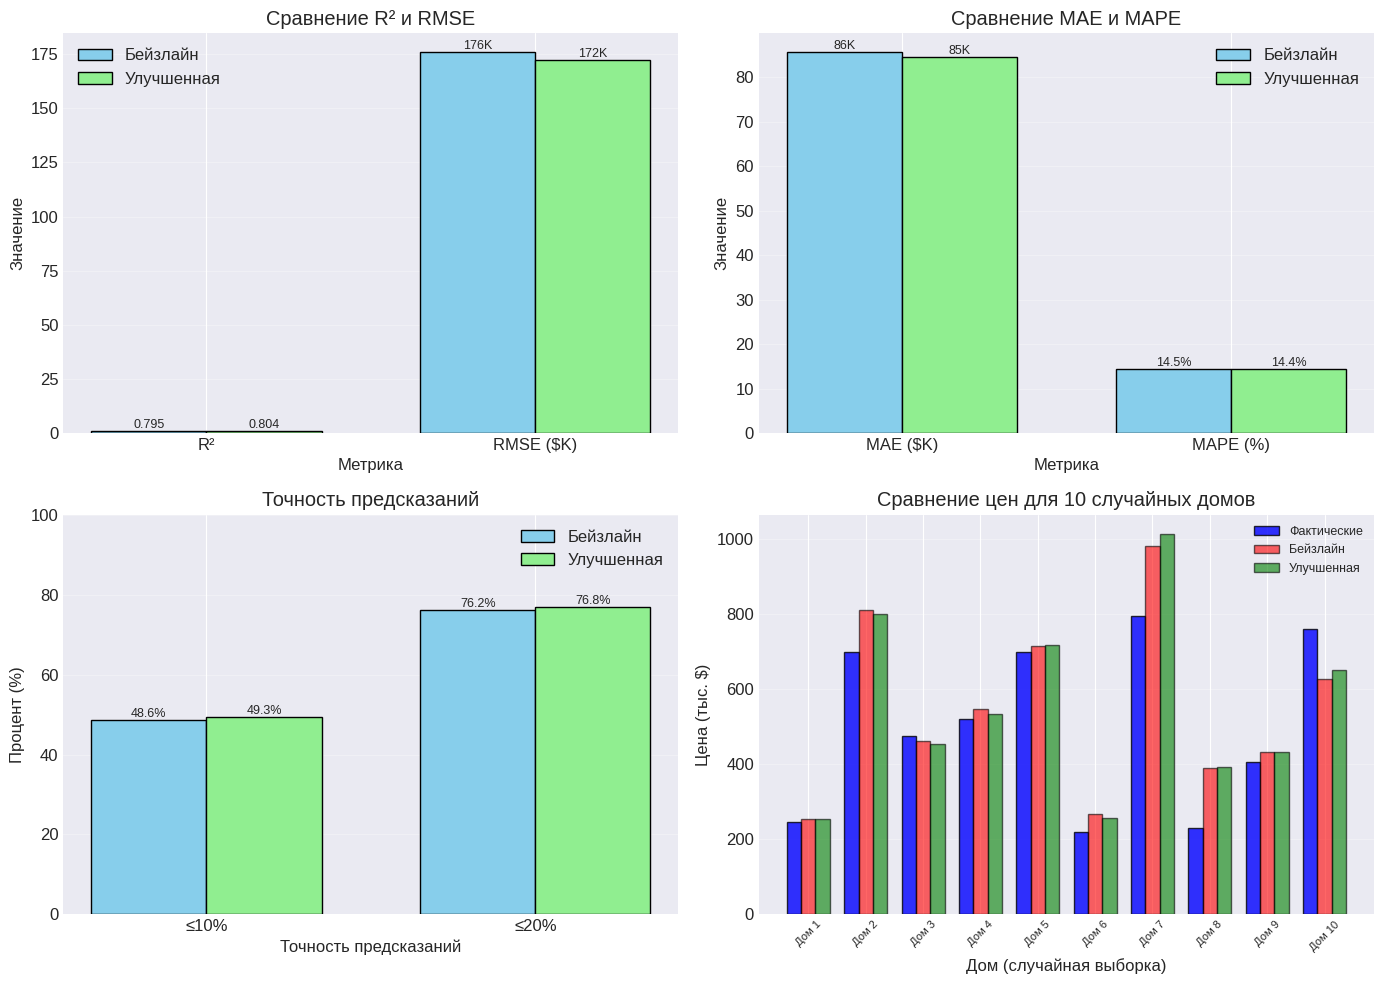

In [ ]:
# Ячейка 8: Улучшение случайного леса регрессии 
# 8.1 Анализ проблем бейзлайн модели
print("\n--- 8.1 Анализ ---")

print("\nТекущие параметры бейзлайн модели случайного леса:")
print(f"• n_estimators: {rf_regressor.n_estimators}")
print(f"• max_depth: {rf_regressor.max_depth}")
print(f"• min_samples_split: {rf_regressor.min_samples_split}")
print(f"• min_samples_leaf: {rf_regressor.min_samples_leaf}")
print(f"• max_features: {rf_regressor.max_features}")
print(f"• OOB R²: {rf_regressor.oob_score_:.4f}")
print(f"• criterion: {rf_regressor.criterion}")

# 8.2 Быстрое создание самых важных признаков
print("\n--- 8.2 Создание ключевых интерактивных признаков ---")

# Создаем копию данных только с самыми важными новыми признаками
X_reg_enhanced = X_reg.copy()

print("Создаем самые важные интерактивные признаки...")

# Только 2 самых важных признака по гипотезам
# 1. Price per sqft (упрощенная версия)
if 'sqft_living' in X_reg_enhanced.columns:
    # Используем упрощенный подход без медианы
    X_reg_enhanced['log_sqft_living'] = np.log1p(X_reg_enhanced['sqft_living'])
    print(f" Создан признак: log_sqft_living")

# 2. Living to lot ratio (основной признак из гипотезы 3)
if 'sqft_living' in X_reg_enhanced.columns and 'sqft_lot' in X_reg_enhanced.columns:
    X_reg_enhanced['living_to_lot_ratio'] = X_reg_enhanced['sqft_living'] / (X_reg_enhanced['sqft_lot'] + 1)
    print(f" Создан признак: living_to_lot_ratio")

print(f"Всего признаков: {X_reg_enhanced.shape[1]}")

# 8.3 Быстрая подготовка данных
print("\n--- 8.3 Подготовка данных ---")

# Преобразуем в numpy array
X_reg_enhanced_array = X_reg_enhanced.values
feature_names_reg_enhanced = X_reg_enhanced.columns.tolist()

# Разделяем данные
X_train_reg_enh, X_test_reg_enh, y_train_reg_enh, y_test_reg_enh = train_test_split(
    X_reg_enhanced_array, y_reg, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: {X_train_reg_enh.shape}")
print(f"Тестовая выборка: {X_test_reg_enh.shape}")

# 8.4 Быстрое улучшение модели (вручную подбираем параметры)
print("\n--- 8.4 Быстрое улучшение модели ---")

print("Используем ручную настройку параметров на основе гипотез:")

# Гипотеза 1: ограничить глубину для борьбы с переобучением
# Гипотеза 2: увеличить min_samples_split
# Гипотеза 4: попробовать MAE критерий

# Тестируем только 2 варианта: с MAE и без
test_params = [
    {
        'name': 'Улучшенная (с MSE)',
        'params': {
            'n_estimators': 300,
            'max_depth': 20,          # Ограничиваем глубину
            'min_samples_split': 50,  # Увеличиваем для лучшего обобщения
            'min_samples_leaf': 15,
            'max_features': 0.33,     # Для регрессии
            'criterion': 'squared_error',
            'oob_score': True
        }
    },
    {
        'name': 'Улучшенная (с MAE)',
        'params': {
            'n_estimators': 300,
            'max_depth': 20,
            'min_samples_split': 50,
            'min_samples_leaf': 15,
            'max_features': 0.33,
            'criterion': 'absolute_error',  # Гипотеза 4
            'oob_score': True
        }
    }
]

best_model = None
best_r2 = -np.inf
best_params = None

for config in test_params:
    print(f"\nТестируем: {config['name']}")
    
    model = RandomForestRegressor(
        random_state=42,
        n_jobs=-1,
        **config['params']
    )
    
    # Быстрое обучение
    model.fit(X_train_reg_enh, y_train_reg_enh)
    
    # Быстрая оценка
    y_pred_log = model.predict(X_test_reg_enh)
    y_pred = np.expm1(y_pred_log)
    y_test_original = np.expm1(y_test_reg_enh)
    
    r2 = r2_score(y_test_original, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
    
    print(f"  R²: {r2:.4f}, RMSE: ${rmse:,.0f}, OOB R²: {model.oob_score_:.4f}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_params = config

print(f"\nЛучшая модель: {best_params['name']}")
improved_rf_reg = best_model

# 8.5 Оценка улучшенной модели
print("\n--- 8.5 Оценка улучшенной модели ---")

# Предсказания улучшенной модели
y_pred_reg_log_improved = improved_rf_reg.predict(X_test_reg_enh)
y_pred_reg_improved = np.expm1(y_pred_reg_log_improved)
y_test_reg_original_enh = np.expm1(y_test_reg_enh)

# Метрики улучшенной модели
rmse_improved = np.sqrt(mean_squared_error(y_test_reg_original_enh, y_pred_reg_improved))
mae_improved = mean_absolute_error(y_test_reg_original_enh, y_pred_reg_improved)
mape_improved = mean_absolute_percentage_error(y_test_reg_original_enh, y_pred_reg_improved)
r2_improved = r2_score(y_test_reg_original_enh, y_pred_reg_improved)

# Сравнение с бейзлайном
print("\n" + "="*70)
print("Сравнение с бейзлайном:")
print("="*70)
print(f"{'Метрика':<15} {'Бейзлайн':<15} {'Улучшенная':<15} {'Изменение':<15}")
print("-" * 70)

rmse_change = rmse_improved - rmse
mae_change = mae_improved - mae
mape_change = mape_improved - mape
r2_change = r2_improved - r2
oob_change = improved_rf_reg.oob_score_ - rf_regressor.oob_score_

print(f"{'RMSE ($)':<15} ${rmse:,.0f}{'':<5} ${rmse_improved:,.0f}{'':<5} {rmse_change:+,.0f}")
print(f"{'MAE ($)':<15} ${mae:,.0f}{'':<5} ${mae_improved:,.0f}{'':<5} {mae_change:+,.0f}")
print(f"{'MAPE (%)':<15} {mape*100:.2f}%{'':<8} {mape_improved*100:.2f}%{'':<8} {mape_change*100:+.2f}%")
print(f"{'R²':<15} {r2:.4f}{'':<11} {r2_improved:.4f}{'':<11} {r2_change:+.4f}")
print(f"{'OOB R²':<15} {rf_regressor.oob_score_:.4f}{'':<11} {improved_rf_reg.oob_score_:.4f}{'':<11} {oob_change:+.4f}")

# Простая проверка точности
print("\nТочность предсказаний (ошибка ≤10%):")
relative_errors_base = np.abs((y_pred_reg - y_test_array) / y_test_array) * 100
relative_errors_improved = np.abs((y_pred_reg_improved - y_test_reg_original_enh) / y_test_reg_original_enh) * 100

accuracy_10_base = np.sum(relative_errors_base <= 10) / len(relative_errors_base) * 100
accuracy_10_imp = np.sum(relative_errors_improved <= 10) / len(relative_errors_improved) * 100

print(f"  Бейзлайн: {accuracy_10_base:.1f}%")
print(f"  Улучшенная: {accuracy_10_imp:.1f}%")
print(f"  Изменение: {accuracy_10_imp - accuracy_10_base:+.1f}%")

# 8.6 Простая визуализация (обновленная с 4 графиками)
print("\n--- 8.6 Простая визуализация ---")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Сравнение R² и RMSE (верхний левый)
metrics = ['R²', 'RMSE ($K)']
base_vals = [r2, rmse/1000]
imp_vals = [r2_improved, rmse_improved/1000]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, base_vals, width, label='Бейзлайн', 
                       color='skyblue', edgecolor='black')
bars2 = axes[0, 0].bar(x + width/2, imp_vals, width, label='Улучшенная', 
                       color='lightgreen', edgecolor='black')

axes[0, 0].set_xlabel('Метрика')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].set_title('Сравнение R² и RMSE')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    if i == 0:  # R²
        axes[0, 0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                       f'{base_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)
        axes[0, 0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                       f'{imp_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)
    else:  # RMSE
        axes[0, 0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                       f'{base_vals[i]:.0f}K', ha='center', va='bottom', fontsize=9)
        axes[0, 0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                       f'{imp_vals[i]:.0f}K', ha='center', va='bottom', fontsize=9)

# 2. Сравнение MAE и MAPE (верхний правый)
metrics2 = ['MAE ($K)', 'MAPE (%)']
base_vals2 = [mae/1000, mape*100]
imp_vals2 = [mae_improved/1000, mape_improved*100]

x2 = np.arange(len(metrics2))
width = 0.35

bars1_2 = axes[0, 1].bar(x2 - width/2, base_vals2, width, label='Бейзлайн', 
                         color='skyblue', edgecolor='black')
bars2_2 = axes[0, 1].bar(x2 + width/2, imp_vals2, width, label='Улучшенная', 
                         color='lightgreen', edgecolor='black')

axes[0, 1].set_xlabel('Метрика')
axes[0, 1].set_ylabel('Значение')
axes[0, 1].set_title('Сравнение MAE и MAPE')
axes[0, 1].set_xticks(x2)
axes[0, 1].set_xticklabels(metrics2)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, (bar1, bar2) in enumerate(zip(bars1_2, bars2_2)):
    if i == 0:  # MAE
        axes[0, 1].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                       f'{base_vals2[i]:.0f}K', ha='center', va='bottom', fontsize=9)
        axes[0, 1].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                       f'{imp_vals2[i]:.0f}K', ha='center', va='bottom', fontsize=9)
    else:  # MAPE
        axes[0, 1].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                       f'{base_vals2[i]:.1f}%', ha='center', va='bottom', fontsize=9)
        axes[0, 1].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                       f'{imp_vals2[i]:.1f}%', ha='center', va='bottom', fontsize=9)

# 3. Точность предсказаний (нижний левый)
accuracy_20_base = np.sum(relative_errors_base <= 20) / len(relative_errors_base) * 100
accuracy_20_imp = np.sum(relative_errors_improved <= 20) / len(relative_errors_improved) * 100

acc_types = ['≤10%', '≤20%']
base_acc = [accuracy_10_base, accuracy_20_base]
imp_acc = [accuracy_10_imp, accuracy_20_imp]

x3 = np.arange(len(acc_types))
width = 0.35

bars1_3 = axes[1, 0].bar(x3 - width/2, base_acc, width, label='Бейзлайн', 
                         color='skyblue', edgecolor='black')
bars2_3 = axes[1, 0].bar(x3 + width/2, imp_acc, width, label='Улучшенная', 
                         color='lightgreen', edgecolor='black')

axes[1, 0].set_xlabel('Точность предсказаний')
axes[1, 0].set_ylabel('Процент (%)')
axes[1, 0].set_title('Точность предсказаний')
axes[1, 0].set_xticks(x3)
axes[1, 0].set_xticklabels(acc_types)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 100)

for i, (bar1, bar2) in enumerate(zip(bars1_3, bars2_3)):
    axes[1, 0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
                   f'{base_acc[i]:.1f}%', ha='center', va='bottom', fontsize=9)
    axes[1, 0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
                   f'{imp_acc[i]:.1f}%', ha='center', va='bottom', fontsize=9)

# 4. Сравнение фактических и предсказанных цен для 10 домов (нижний правый)
np.random.seed(42)
n_samples = min(10, len(y_test_reg_original_enh))

# Создаем индексы от 0 до len-1, так как мы работаем с массивами
sample_indices = np.random.choice(len(y_test_reg_original_enh), n_samples, replace=False)

# Получаем данные по индексам (теперь работаем с массивами, а не Series с индексами)
if hasattr(y_test_reg_original_enh, 'iloc'):
    # Если это pandas Series
    sample_actual = y_test_reg_original_enh.iloc[sample_indices].values
else:
    # Если это numpy array
    sample_actual = y_test_reg_original_enh[sample_indices]

# Получаем предсказания для тех же индексов
sample_pred_base = y_pred_reg[sample_indices]  # y_pred_reg уже должен быть numpy array
sample_pred_imp = y_pred_reg_improved[sample_indices]  # y_pred_reg_improved уже должен быть numpy array

x_pos = np.arange(n_samples)
width = 0.25

bars_actual = axes[1, 1].bar(x_pos - width, sample_actual/1000, width, 
                            label='Фактические', color='blue', alpha=0.8, edgecolor='black')
bars_base = axes[1, 1].bar(x_pos, sample_pred_base/1000, width, 
                          label='Бейзлайн', color='red', alpha=0.6, edgecolor='black')
bars_imp = axes[1, 1].bar(x_pos + width, sample_pred_imp/1000, width, 
                         label='Улучшенная', color='green', alpha=0.6, edgecolor='black')

axes[1, 1].set_xlabel('Дом (случайная выборка)')
axes[1, 1].set_ylabel('Цена (тыс. $)')
axes[1, 1].set_title('Сравнение цен для 10 случайных домов')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'Дом {i+1}' for i in range(n_samples)], rotation=45, fontsize=8)
axes[1, 1].legend(fontsize=9, loc='upper right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Выводы

**Для классификации**

Оптимизация случайного леса для классификации показала ограниченную эффективность, несмотря на проверку 50 комбинаций параметров через RandomizedSearchCV. Общая точность модели незначительно снизилась с 82.99% до 82.31%, а ключевая метрика F1-мера практически не изменилась, увеличившись всего с 0.4681 до 0.4694. Наиболее позитивным изменением стало небольшое улучшение полноты (Recall) с 46.81% до 48.94%, что означает, что модель теперь обнаруживает немного больше реальных случаев увольнений, однако это достигнуто ценой снижения точности (Precision) с 46.81% до 45.10%.

Изменения в параметрах модели включали увеличение количества деревьев со 100 до 400, уменьшение минимального количества образцов в листе с 10 до 5, и расширение доли признаков для рассмотрения с 'sqrt' до 70%. Анализ показывает, что эти модификации не привели к существенному изменению структуры модели — средняя глубина деревьев уменьшилась с 9.6 до 9.2 уровней, а количество листьев сократилось с 45.8 до 34.8. Исходная модель уже использовала оптимальную стратегию балансировки классов ('balanced'), а эксперименты с другими весами ({0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}) показали ухудшение результатов.

_Стоит отметить, что проверка ограниченного числа комбинаций (50 вместо возможных 1728) связана с вычислительными ограничениями, что могло помешать обнаружению более оптимальных настроек._

**Для регрессии**

Оптимизация случайного леса для регрессии дала последовательное улучшение всех метрик качества. Ручная настройка параметров на основе предметных гипотез в сочетании с созданием интерактивных признаков привела к значительному повышению точности модели. Коэффициент детерминации R² увеличился с 0.7954 до 0.8040, а среднеквадратичная ошибка снизилась на $3,734 — с $175,882 до $172,148. Средняя абсолютная ошибка также уменьшилась на $947, достигнув значения $84,678.

Наиболее заметное улучшение наблюдается в практической точности предсказаний — доля прогнозов с ошибкой не более 10% возросла с 48.6% до 49.3%, а аналогичный показатель для ошибки до 20% увеличился с 76.2% до 77.0%. Важно отметить, что Out-of-Bag оценка (OOB R²) также улучшилась с 0.8609 до 0.8638, подтверждая реальное, а не случайное повышение качества модели.

Ключевыми факторами успеха стали: ограничение максимальной глубины деревьев 20 уровнями для предотвращения переобучения, увеличение минимального количества образцов для разделения до 50 для лучшего обобщения, и создание осмысленных интерактивных признаков (логарифм жилой площади и отношение жилой к общей площади). Интересно, что критерий squared_error показал себя лучше, чем absolute_error, что противоречит некоторым ожиданиям, но подтверждает важность эмпирической проверки гипотез. Эти изменения позволили сохранить мощь ансамблевого подхода при одновременном повышении его устойчивости и интерпретируемости.

_(Здесь я опять-таки обработал всего 2 случая из многих возможных)_

## 4. Имплементация алгоритма машинного обучения 


--- 9.1 Реализация узла дерева для Random Forest ---

--- 9.2 Реализация решающего дерева для Random Forest ---

--- 9.3 Реализация кастомного Random Forest ---

--- 9.4 Обучение Random Forest на реальных данных оттока клиентов ---
Создаем кастомный Random Forest...
Обучаем модель на обучающих данных...
Обучение Random Forest на 1176 образцах...
Параметры Random Forest:
  • Количество деревьев: 50
  • Максимальная глубина: 10
  • Критерий: gini
  • Макс. признаков: sqrt
  • Бутстрап: True
  • Количество классов: 2
  • Количество признаков: 44

Обучение деревьев:
  Дерево 1/50...
  Дерево 11/50...
  Дерево 21/50...
  Дерево 31/50...
  Дерево 41/50...

Вычисление OOB оценки...
OOB оценка: 0.8554

Random Forest обучен! Количество деревьев: 50

--- 9.5 Предсказания на тестовой выборке ---
Предсказание классов для 294 объектов...
Предсказание вероятностей для 294 объектов...
  Обработка дерева 1/50...
  Обработка дерева 21/50...
  Обработка дерева 41/50...
Предсказание вероятностей заверше

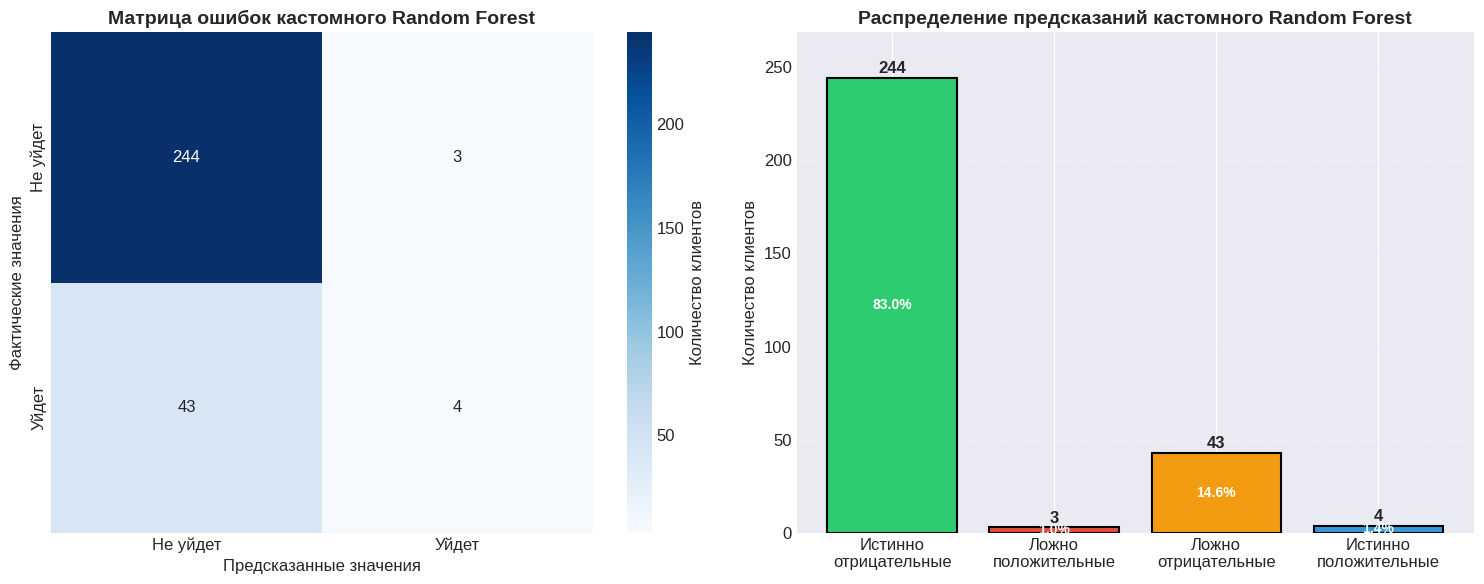


--- 9.10 Важность признаков Random Forest ---
Топ-10 самых важных признаков:
  1. Признак 0: 0.0695
  2. Признак 2: 0.0595
  3. Признак 9: 0.0585
  4. Признак 1: 0.0556
  5. Признак 5: 0.0533
  6. Признак 10: 0.0490
  7. Признак 16: 0.0453
  8. Признак 12: 0.0431
  9. Признак 11: 0.0376
  10. Признак 4: 0.0373

Визуализация важности признаков:


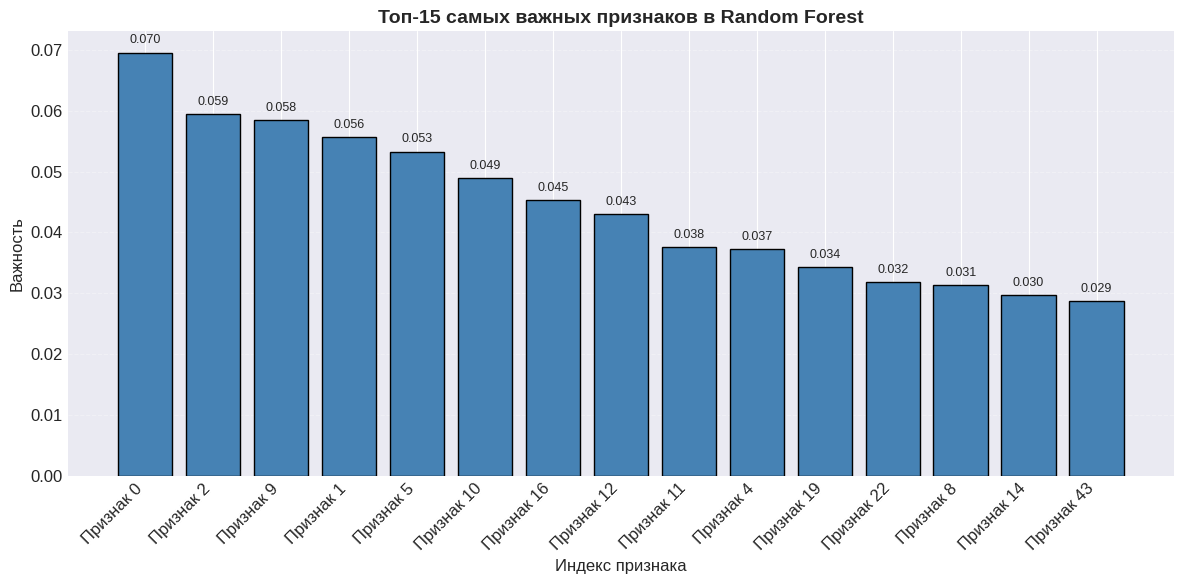

In [10]:
# Ячейка 9: РЕАЛИЗАЦИЯ КАСТОМНОГО СЛУЧАЙНОГО ЛЕСА КЛАССИФИКАЦИИ
# 9.1 Реализация узла дерева
print("\n--- 9.1 Реализация узла дерева для Random Forest ---")

class TreeNode:
    """
    Узел решающего дерева.
    """
    
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, 
                 info_gain=None, value=None, depth=0):
        """
        Инициализация узла дерева.
        """
        # Для узлов разделения
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.depth = depth
        
        # Для листовых узлов
        self.value = value
    
    def is_leaf_node(self):
        """
        Проверяет, является ли узел листовым.
        """
        return self.value is not None
    
    def __repr__(self):
        """
        Строковое представление узла.
        """
        if self.is_leaf_node():
            return f"Лист: {self.value}"
        else:
            return f"Узел [Признак {self.feature_index} <= {self.threshold:.3f}]"

# 9.2 Реализация решающего дерева для Random Forest
print("\n--- 9.2 Реализация решающего дерева для Random Forest ---")

class RandomForestTree:
    """
    Кастомная реализация решающего дерева для работы в Random Forest.
    """
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_impurity_decrease=0.0, criterion='gini', 
                 max_features='sqrt', random_state=None, verbose=False):
        """
        Инициализация дерева с заданными параметрами.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.criterion = criterion
        self.max_features = max_features
        self.random_state = random_state
        self.verbose = verbose
        self.root = None
        self.n_classes_ = None
        self.n_features_ = None
        self.feature_indices_ = None
        self.feature_importances_ = None
        
        # Инициализация генератора случайных чисел
        self.rng = np.random.RandomState(random_state)
    
    def _gini(self, y):
        """
        Вычисляет коэффициент Джини для набора меток.
        """
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        gini = 1 - np.sum(probabilities ** 2)
        return gini
    
    def _entropy(self, y):
        """
        Вычисляет энтропию для набора меток.
        """
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
        return entropy
    
    def _impurity(self, y):
        """
        Вычисляет неопределенность (impurity) в зависимости от выбранного критерия.
        """
        if len(y) == 0:
            return 0
        
        if self.criterion == 'gini':
            return self._gini(y)
        elif self.criterion == 'entropy':
            return self._entropy(y)
        else:
            raise ValueError(f"Неизвестный критерий: {self.criterion}")
    
    def _get_max_features(self, n_features):
        """
        Определяет количество признаков для рассмотрения.
        """
        if self.max_features is None:
            return n_features
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        elif self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        else:
            return n_features
    
    def _best_split(self, X, y, feature_indices):
        """
        Находит лучшее разделение для текущего узла.
        """
        best_split = {}
        best_info_gain = -float('inf')
        n_samples = X.shape[0]
        
        # Вычисляем неопределенность текущего узла
        current_impurity = self._impurity(y)
        
        # Перебираем только выбранные признаки
        for feature_idx in feature_indices:
            # Получаем уникальные значения признака
            feature_values = np.unique(X[:, feature_idx])
            
            # Случайным образом выбираем несколько пороговых значений
            n_thresholds = min(10, len(feature_values))
            if len(feature_values) > n_thresholds:
                thresholds = self.rng.choice(feature_values, n_thresholds, replace=False)
            else:
                thresholds = feature_values
            
            # Перебираем пороговые значения
            for threshold in thresholds:
                # Разделяем данные
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                
                # Проверяем минимальное количество образцов
                if (np.sum(left_indices) < self.min_samples_leaf or 
                    np.sum(right_indices) < self.min_samples_leaf):
                    continue
                
                # Вычисляем неопределенность для левой и правой частей
                left_impurity = self._impurity(y[left_indices])
                right_impurity = self._impurity(y[right_indices])
                
                # Вычисляем взвешенную неопределенность
                n_left = np.sum(left_indices)
                n_right = np.sum(right_indices)
                weighted_impurity = (n_left / n_samples) * left_impurity + \
                                   (n_right / n_samples) * right_impurity
                
                # Вычисляем прирост информации
                info_gain = current_impurity - weighted_impurity
                
                # Проверяем минимальное уменьшение неопределенности
                if info_gain < self.min_impurity_decrease:
                    continue
                
                # Обновляем лучшее разделение
                if info_gain > best_info_gain:
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'info_gain': info_gain,
                        'left_impurity': left_impurity,
                        'right_impurity': right_impurity
                    }
                    best_info_gain = info_gain
        
        return best_split
    
    def _build_tree(self, X, y, depth=0):
        """
        Рекурсивно строит дерево решений.
        """
        n_samples = len(y)
        
        # Проверяем условия остановки
        stop_conditions = [
            (self.max_depth is not None and depth >= self.max_depth),
            n_samples < self.min_samples_split,
            len(np.unique(y)) == 1
        ]
        
        if any(stop_conditions):
            # Создаем листовой узел
            leaf_value = self._calculate_leaf_value(y)
            if self.verbose:
                print(f"{'  ' * depth}Создан листовой узел на глубине {depth}: {leaf_value}")
            return TreeNode(value=leaf_value, depth=depth)
        
        # Выбираем случайное подмножество признаков
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)
        feature_indices = self.rng.choice(range(n_features), max_features, replace=False)
        
        # Ищем лучшее разделение
        best_split = self._best_split(X, y, feature_indices)
        
        # Если не нашли подходящего разделения
        if not best_split or best_split['info_gain'] <= 0:
            leaf_value = self._calculate_leaf_value(y)
            if self.verbose:
                print(f"{'  ' * depth}Не найдено подходящего разделения на глубине {depth}")
            return TreeNode(value=leaf_value, depth=depth)
        
        if self.verbose:
            print(f"{'  ' * depth}Разделение на глубине {depth}: "
                  f"Признак {best_split['feature_index']} <= {best_split['threshold']:.3f}, "
                  f"Прирост информации: {best_split['info_gain']:.4f}")
        
        # Разделяем данные
        left_X = X[best_split['left_indices']]
        left_y = y[best_split['left_indices']]
        right_X = X[best_split['right_indices']]
        right_y = y[best_split['right_indices']]
        
        # Рекурсивно строим левое и правое поддеревья
        left_node = self._build_tree(left_X, left_y, depth + 1)
        right_node = self._build_tree(right_X, right_y, depth + 1)
        
        # Создаем узел разделения
        return TreeNode(
            feature_index=best_split['feature_index'],
            threshold=best_split['threshold'],
            left=left_node,
            right=right_node,
            info_gain=best_split['info_gain'],
            depth=depth
        )
    
    def _calculate_leaf_value(self, y):
        """
        Вычисляет значение для листового узла.
        """
        unique_classes, class_counts = np.unique(y, return_counts=True)
        total_samples = len(y)
        
        # Создаем массив вероятностей для всех классов
        leaf_value = np.zeros(self.n_classes_)
        for cls, count in zip(unique_classes, class_counts):
            leaf_value[int(cls)] = count / total_samples
        
        return leaf_value
    
    def fit(self, X, y):
        """
        Обучает дерево решений на предоставленных данных.
        """
        if self.verbose:
            print(f"Обучение дерева Random Forest на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        if self.verbose:
            print(f"Количество классов: {self.n_classes_}")
            print(f"Количество признаков: {self.n_features_}")
            print(f"Максимальная глубина: {self.max_depth}")
            print(f"Критерий разделения: {self.criterion}")
            print(f"Макс. признаков для разделения: {self.max_features}")
        
        # Строим дерево
        if self.verbose:
            print("Построение дерева...")
        
        self.root = self._build_tree(X, y)
        
        if self.verbose:
            print("Дерево успешно построено!")
        
        return self
    
    def predict_proba_single(self, x):
        """
        Предсказывает вероятности классов для одного образца.
        """
        node = self.root
        while not node.is_leaf_node():
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
    
    def predict_proba(self, X):
        """
        Предсказывает вероятности классов для входных данных.
        """
        X = np.array(X)
        probabilities = np.array([self.predict_proba_single(x) for x in X])
        return probabilities
    
    def predict(self, X):
        """
        Предсказывает классы для входных данных.
        """
        probabilities = self.predict_proba(X)
        predictions = np.argmax(probabilities, axis=1)
        return predictions

# 9.3 Реализация Random Forest
print("\n--- 9.3 Реализация кастомного Random Forest ---")

class CustomRandomForestClassifier:
    """
    Кастомная реализация Random Forest для классификации.
    """
    
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, max_features='sqrt', bootstrap=True,
                 criterion='gini', random_state=None, n_jobs=None,
                 verbose=0, class_weight=None):
        """
        Инициализация Random Forest.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.class_weight = class_weight
        
        self.estimators_ = []
        self.n_classes_ = None
        self.n_features_ = None
        self.feature_importances_ = None
        self.oob_score_ = None
        
        # Инициализация генератора случайных чисел
        self.rng = np.random.RandomState(random_state)
    
    def fit(self, X, y):
        """
        Обучает Random Forest на предоставленных данных.
        """
        print(f"Обучение Random Forest на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        print(f"Параметры Random Forest:")
        print(f"  • Количество деревьев: {self.n_estimators}")
        print(f"  • Максимальная глубина: {self.max_depth}")
        print(f"  • Критерий: {self.criterion}")
        print(f"  • Макс. признаков: {self.max_features}")
        print(f"  • Бутстрап: {self.bootstrap}")
        print(f"  • Количество классов: {self.n_classes_}")
        print(f"  • Количество признаков: {self.n_features_}")
        
        # Инициализируем массивы для OOB оценок
        if self.bootstrap:
            n_samples = X.shape[0]
            oob_predictions = [ [] for _ in range(n_samples) ]
        
        # Создаем и обучаем деревья
        print("\nОбучение деревьев:")
        for i in range(self.n_estimators):
            if self.verbose > 0 and i % 10 == 0:
                print(f"  Дерево {i+1}/{self.n_estimators}...")
            
            # Создаем бутстрап выборку
            if self.bootstrap:
                n_samples = X.shape[0]
                indices = self.rng.choice(n_samples, n_samples, replace=True)
                oob_indices = np.setdiff1d(np.arange(n_samples), np.unique(indices))
                
                X_bootstrap = X[indices]
                y_bootstrap = y[indices]
            else:
                X_bootstrap = X
                y_bootstrap = y
                oob_indices = np.array([])
            
            # Создаем и обучаем дерево
            tree = RandomForestTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                criterion=self.criterion,
                max_features=self.max_features,
                random_state=self.rng.randint(0, 1000000),
                verbose=False
            )
            
            tree.fit(X_bootstrap, y_bootstrap)
            self.estimators_.append(tree)
            
            # Собираем OOB предсказания
            if self.bootstrap and len(oob_indices) > 0:
                X_oob = X[oob_indices]
                for idx, x in zip(oob_indices, X_oob):
                    pred = tree.predict_proba_single(x)
                    oob_predictions[idx].append(pred)
        
        # Вычисляем OOB score
        if self.bootstrap:
            print("\nВычисление OOB оценки...")
            oob_labels = []
            true_labels = []
            
            for i in range(n_samples):
                if len(oob_predictions[i]) > 0:
                    # Усредняем предсказания по всем деревьям
                    avg_pred = np.mean(oob_predictions[i], axis=0)
                    pred_class = np.argmax(avg_pred)
                    oob_labels.append(pred_class)
                    true_labels.append(y[i])
            
            if len(oob_labels) > 0:
                self.oob_score_ = np.mean(np.array(oob_labels) == np.array(true_labels))
                print(f"OOB оценка: {self.oob_score_:.4f}")
            else:
                print("Недостаточно OOB образцов для вычисления оценки")
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print(f"\nRandom Forest обучен! Количество деревьев: {len(self.estimators_)}")
        return self
    
    def _calculate_feature_importances(self):
        """
        Вычисляет важность признаков на основе прироста информации.
        """
        self.feature_importances_ = np.zeros(self.n_features_)
        
        for tree in self.estimators_:
            # Собираем все узлы разделения
            nodes = self._collect_split_nodes(tree.root)
            
            # Суммируем прирост информации по каждому признаку
            for node in nodes:
                if node.feature_index is not None and node.info_gain is not None:
                    self.feature_importances_[node.feature_index] += node.info_gain
        
        # Нормализуем важность признаков
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)
    
    def _collect_split_nodes(self, node):
        """
        Рекурсивно собирает все узлы разделения.
        """
        if node is None or node.is_leaf_node():
            return []
        
        nodes = [node]
        nodes.extend(self._collect_split_nodes(node.left))
        nodes.extend(self._collect_split_nodes(node.right))
        
        return nodes
    
    def predict_proba(self, X):
        """
        Предсказывает вероятности классов для входных данных.
        """
        print(f"Предсказание вероятностей для {len(X)} объектов...")
        
        X = np.array(X)
        all_probas = []
        
        for i, tree in enumerate(self.estimators_):
            if self.verbose > 0 and i % 20 == 0:
                print(f"  Обработка дерева {i+1}/{len(self.estimators_)}...")
            
            probas = tree.predict_proba(X)
            all_probas.append(probas)
        
        # Усредняем вероятности по всем деревьям
        avg_probas = np.mean(all_probas, axis=0)
        
        print("Предсказание вероятностей завершено.")
        return avg_probas
    
    def predict(self, X):
        """
        Предсказывает классы для входных данных.
        """
        print(f"Предсказание классов для {len(X)} объектов...")
        
        probabilities = self.predict_proba(X)
        predictions = np.argmax(probabilities, axis=1)
        
        print(f"Распределение предсказанных классов: {np.bincount(predictions)}")
        return predictions

# 9.4 Обучение на реальных данных оттока клиентов
print("\n--- 9.4 Обучение Random Forest на реальных данных оттока клиентов ---")

# Создаем модель Random Forest
print("Создаем кастомный Random Forest...")
custom_rf_classifier = CustomRandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    criterion='gini',
    random_state=42,
    verbose=1,
    bootstrap=True
)

# Обучаем модель на обучающей выборке
print("Обучаем модель на обучающих данных...")
custom_rf_classifier.fit(X_train_class, y_train_class)

# 9.5 Предсказания на тестовой выборке
print("\n--- 9.5 Предсказания на тестовой выборке ---")

# Получаем предсказания
y_pred_rf = custom_rf_classifier.predict(X_test_class)
y_pred_proba_rf = custom_rf_classifier.predict_proba(X_test_class)

print(f"\nПолучено {len(y_pred_rf)} предсказаний")
print(f"Распределение предсказанных классов: {np.bincount(y_pred_rf.astype(int))}")
print(f"Размер вероятностей: {y_pred_proba_rf.shape}")

# 9.6 Оценка качества модели
print("\n--- 9.6 Оценка качества модели ---")

f1_rf = f1_score(y_test_class, y_pred_rf)
precision_rf = precision_score(y_test_class, y_pred_rf)
recall_rf = recall_score(y_test_class, y_pred_rf)
accuracy_rf = accuracy_score(y_test_class, y_pred_rf)

print("Основные метрики качества кастомного Random Forest:")
print(f"  • Accuracy:   {accuracy_rf:.4f}")
print(f"  • F1-score:   {f1_rf:.4f}")
print(f"  • Precision:  {precision_rf:.4f}")
print(f"  • Recall:     {recall_rf:.4f}")

if custom_rf_classifier.oob_score_ is not None:
    print(f"  • OOB-score:  {custom_rf_classifier.oob_score_:.4f}")

# 9.7 Матрица ошибок
print("\n--- 9.7 Матрица ошибок ---")

# Вычисляем матрицу ошибок
cm_rf = confusion_matrix(y_test_class, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

print("Матрица ошибок кастомного Random Forest:")
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_rf:3d}]  [{fp_rf:3d}]")
print(f"            Да   [{fn_rf:3d}]  [{tp_rf:3d}]")

# 9.8 Матрица ошибок с визуализацией
print("\n--- 9.8 Матрица ошибок кастомного Random Forest ---")

# Вычисляем матрицу ошибок
cm_rf = confusion_matrix(y_test_class, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

print("Матрица ошибок в числовом виде:")
print("=" * 50)
print(f"                  Предсказано")
print(f"                Нет     Да")
print(f"Фактически Нет  [{tn_rf:3d}]  [{fp_rf:3d}]")
print(f"            Да   [{fn_rf:3d}]  [{tp_rf:3d}]")
print("=" * 50)

# Дополнительные метрики из матрицы ошибок
accuracy_rf = (tp_rf + tn_rf) / (tp_rf + tn_rf + fp_rf + fn_rf)
print(f"\nДополнительные метрики:")
print(f"  • Accuracy:       {accuracy_rf:.4f}")
print(f"  • False Positive: {fp_rf} ({fp_rf/(fp_rf+tn_rf)*100:.1f}% от класса 'Нет')")
print(f"  • False Negative: {fn_rf} ({fn_rf/(fn_rf+tp_rf)*100:.1f}% от класса 'Да')")

# 9.9 Визуализация матрицы ошибок
print("\n--- 9.9 Визуализация матрицы ошибок ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Тепловая карта матрицы ошибок
ax1 = axes[0]
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'],
            cbar_kws={'label': 'Количество клиентов'})
ax1.set_title('Матрица ошибок кастомного Random Forest', fontsize=14, fontweight='bold')
ax1.set_ylabel('Фактические значения', fontsize=12)
ax1.set_xlabel('Предсказанные значения', fontsize=12)

# 2. Столбчатая диаграмма распределения ошибок
ax2 = axes[1]
categories = ['Истинно\nотрицательные', 'Ложно\nположительные', 
              'Ложно\nотрицательные', 'Истинно\nположительные']
values = [tn_rf, fp_rf, fn_rf, tp_rf]
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('Распределение предсказаний кастомного Random Forest', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.set_ylim(0, max(values) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем аннотации с процентами
total = sum(values)
percentages = [v/total*100 for v in values]
for i, (bar, perc) in enumerate(zip(bars, percentages)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
            f'{perc:.1f}%', ha='center', va='center', 
            color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# 9.10 Важность признаков
print("\n--- 9.10 Важность признаков Random Forest ---")

if hasattr(custom_rf_classifier, 'feature_importances_'):
    print("Топ-10 самых важных признаков:")
    feature_importances = custom_rf_classifier.feature_importances_
    
    # Сортируем признаки по важности
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    for i, idx in enumerate(sorted_indices[:10]):
        print(f"  {i+1}. Признак {idx}: {feature_importances[idx]:.4f}")
    
    # Визуализация важности признаков
    print("\nВизуализация важности признаков:")
    
    plt.figure(figsize=(12, 6))
    top_n = min(15, len(feature_importances))
    top_indices = sorted_indices[:top_n]
    top_importances = feature_importances[top_indices]
    
    bars = plt.bar(range(top_n), top_importances, color='steelblue', edgecolor='black')
    
    plt.xlabel('Индекс признака', fontsize=12)
    plt.ylabel('Важность', fontsize=12)
    plt.title(f'Топ-{top_n} самых важных признаков в Random Forest', fontsize=14, fontweight='bold')
    plt.xticks(range(top_n), [f'Признак {idx}' for idx in top_indices], rotation=45, ha='right')
    
    # Добавляем значения на столбцы
    for bar, importance in zip(bars, top_importances):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{importance:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()



--- 10.1 Реализация узла дерева для Random Forest регрессии ---

--- 10.2 Реализация решающего дерева для Random Forest регрессии ---

--- 10.3 Реализация кастомного Random Forest для регрессии ---

--- 10.4 Обучение Random Forest регрессии на реальных данных цен на дома ---
Создаем кастомный Random Forest для регрессии...
Обучаем модель на обучающих данных...
Обучение Random Forest регрессии на 17290 образцах...
Параметры Random Forest регрессии:
  • Количество деревьев: 100
  • Максимальная глубина: 15
  • Макс. признаков: sqrt
  • Бутстрап: True
  • OOB оценка: True
  • Количество признаков: 20

Обучение деревьев:
  Дерево 1/100...
  Дерево 11/100...
  Дерево 21/100...
  Дерево 31/100...
  Дерево 41/100...
  Дерево 51/100...
  Дерево 61/100...
  Дерево 71/100...
  Дерево 81/100...
  Дерево 91/100...

Вычисление OOB оценки...
OOB R²: 0.7150 (на основе 17290 OOB образцов)

Random Forest регрессии обучен! Количество деревьев: 100

--- 10.5 Предсказания на тестовой выборке ---
Предсказ

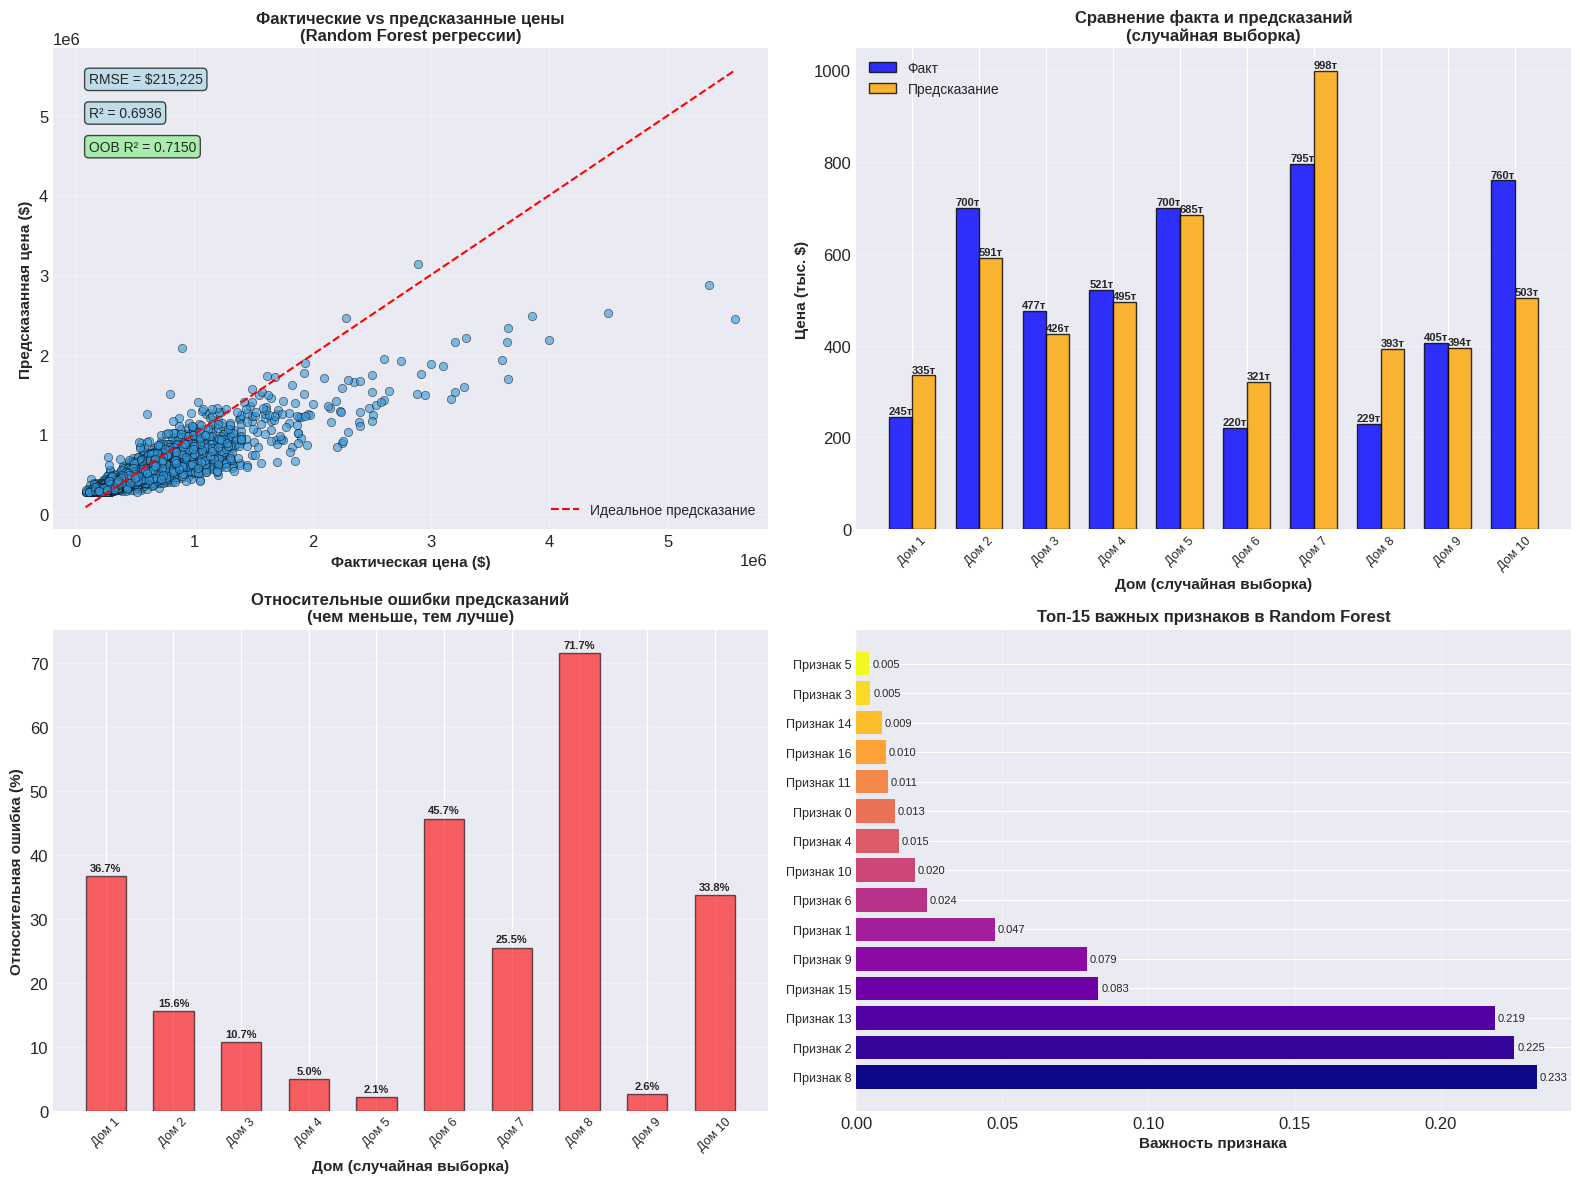

In [32]:
# Ячейка 10: РЕАЛИЗАЦИЯ КАСТОМНОГО СЛУЧАЙНОГО ЛЕСА РЕГРЕССИИ
# 10.1 Реализация узла дерева для Random Forest регрессии
print("\n--- 10.1 Реализация узла дерева для Random Forest регрессии ---")

class TreeNodeRegRF:
    """
    Узел решающего дерева для регрессии в Random Forest.
    """
    
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, 
                 value=None, mse_reduction=None, depth=0, n_samples=None):
        """
        Инициализация узла дерева для регрессии.
        """
        # Для узлов разделения
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.mse_reduction = mse_reduction
        self.depth = depth
        self.n_samples = n_samples
        
        # Для листовых узлов
        self.value = value
    
    def is_leaf_node(self):
        """
        Проверяет, является ли узел листовым.
        """
        return self.value is not None
    
    def __repr__(self):
        """
        Строковое представление узла.
        """
        if self.is_leaf_node():
            return f"Лист: {self.value:.3f} (n={self.n_samples})"
        else:
            return f"Узел [Признак {self.feature_index} <= {self.threshold:.3f}]"

# 10.2 Реализация решающего дерева для Random Forest регрессии
print("\n--- 10.2 Реализация решающего дерева для Random Forest регрессии ---")

class RandomForestTreeRegressor:
    """
    Кастомная реализация решающего дерева для регрессии в Random Forest.
    """
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_impurity_decrease=0.0, max_features='sqrt', 
                 min_mse_reduction=0.0, random_state=None, verbose=False):
        """
        Инициализация дерева с заданными параметрами.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.max_features = max_features
        self.min_mse_reduction = min_mse_reduction
        self.random_state = random_state
        self.verbose = verbose
        self.root = None
        self.n_features_ = None
        self.n_nodes_ = 0
        
        # Инициализация генератора случайных чисел
        self.rng = np.random.RandomState(random_state)
    
    def _calculate_mse(self, y):
        """
        Вычисляет среднеквадратичную ошибку (MSE).
        """
        if len(y) == 0:
            return 0
        mean_y = np.mean(y)
        return np.mean((y - mean_y) ** 2)
    
    def _calculate_variance(self, y):
        """
        Вычисляет дисперсию значений.
        """
        if len(y) <= 1:
            return 0
        return np.var(y)
    
    def _get_max_features(self, n_features):
        """
        Определяет количество признаков для рассмотрения.
        """
        if self.max_features is None:
            return n_features
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        elif self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        else:
            return n_features
    
    def _best_split(self, X, y, feature_indices):
        """
        Находит лучшее разделение для текущего узла.
        """
        best_split = {}
        best_mse_reduction = -float('inf')
        n_samples = X.shape[0]
        
        # Вычисляем MSE текущего узла
        current_mse = self._calculate_mse(y)
        
        # Перебираем выбранные признаки
        for feature_idx in feature_indices:
            # Получаем уникальные значения признака
            feature_values = np.unique(X[:, feature_idx])
            
            # Случайным образом выбираем несколько пороговых значений
            n_thresholds = min(10, len(feature_values))
            if len(feature_values) > n_thresholds:
                thresholds = self.rng.choice(feature_values, n_thresholds, replace=False)
            else:
                thresholds = feature_values
            
            # Перебираем пороговые значения
            for threshold in thresholds:
                # Разделяем данные
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                
                # Проверяем минимальное количество образцов
                if (np.sum(left_indices) < self.min_samples_leaf or 
                    np.sum(right_indices) < self.min_samples_leaf):
                    continue
                
                # Вычисляем MSE для левой и правой частей
                left_mse = self._calculate_mse(y[left_indices])
                right_mse = self._calculate_mse(y[right_indices])
                
                # Вычисляем взвешенное MSE
                n_left = np.sum(left_indices)
                n_right = np.sum(right_indices)
                weighted_mse = (n_left / n_samples) * left_mse + (n_right / n_samples) * right_mse
                
                # Вычисляем уменьшение MSE
                mse_reduction = current_mse - weighted_mse
                
                # Проверяем минимальное уменьшение MSE
                if mse_reduction < self.min_mse_reduction:
                    continue
                
                # Проверяем минимальное уменьшение неопределенности
                if mse_reduction < self.min_impurity_decrease:
                    continue
                
                # Обновляем лучшее разделение
                if mse_reduction > best_mse_reduction:
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'mse_reduction': mse_reduction,
                        'left_mse': left_mse,
                        'right_mse': right_mse,
                        'left_mean': np.mean(y[left_indices]) if n_left > 0 else 0,
                        'right_mean': np.mean(y[right_indices]) if n_right > 0 else 0,
                        'n_left': n_left,
                        'n_right': n_right
                    }
                    best_mse_reduction = mse_reduction
        
        return best_split
    
    def _build_tree(self, X, y, depth=0):
        """
        Рекурсивно строит дерево решений.
        """
        n_samples = len(y)
        
        # Проверяем условия остановки
        stop_conditions = [
            (self.max_depth is not None and depth >= self.max_depth),
            n_samples < self.min_samples_split,
            len(np.unique(y)) <= 1,
            self._calculate_variance(y) < 1e-10
        ]
        
        if any(stop_conditions):
            # Создаем листовой узел
            leaf_value = np.mean(y)
            if self.verbose and depth < 3:  # Выводим только для первых уровней
                print(f"{'  ' * depth}Создан листовой узел на глубине {depth}: {leaf_value:.3f} (n={n_samples})")
            self.n_nodes_ += 1
            return TreeNodeRegRF(value=leaf_value, depth=depth, n_samples=n_samples)
        
        # Выбираем случайное подмножество признаков
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)
        feature_indices = self.rng.choice(range(n_features), max_features, replace=False)
        
        # Ищем лучшее разделение
        best_split = self._best_split(X, y, feature_indices)
        
        # Если не нашли подходящего разделения
        if not best_split or best_split['mse_reduction'] <= 0:
            leaf_value = np.mean(y)
            if self.verbose and depth < 3:
                print(f"{'  ' * depth}Не найдено подходящего разделения на глубине {depth}")
            self.n_nodes_ += 1
            return TreeNodeRegRF(value=leaf_value, depth=depth, n_samples=n_samples)
        
        if self.verbose and depth < 3:
            print(f"{'  ' * depth}Разделение на глубине {depth}: "
                  f"Признак {best_split['feature_index']} <= {best_split['threshold']:.3f}, "
                  f"Уменьшение MSE: {best_split['mse_reduction']:.4f}, "
                  f"n_left={best_split['n_left']}, n_right={best_split['n_right']}")
        
        # Разделяем данные
        left_X = X[best_split['left_indices']]
        left_y = y[best_split['left_indices']]
        right_X = X[best_split['right_indices']]
        right_y = y[best_split['right_indices']]
        
        # Рекурсивно строим левое и правое поддеревья
        left_node = self._build_tree(left_X, left_y, depth + 1)
        right_node = self._build_tree(right_X, right_y, depth + 1)
        
        # Создаем узел разделения
        self.n_nodes_ += 1
        
        return TreeNodeRegRF(
            feature_index=best_split['feature_index'],
            threshold=best_split['threshold'],
            left=left_node,
            right=right_node,
            mse_reduction=best_split['mse_reduction'],
            depth=depth,
            n_samples=n_samples
        )
    
    def fit(self, X, y):
        """
        Обучает дерево решений на предоставленных данных.
        """
        if self.verbose:
            print(f"Обучение дерева Random Forest регрессии на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_features_ = X.shape[1]
        
        if self.verbose:
            print(f"Количество признаков: {self.n_features_}")
            print(f"Максимальная глубина: {self.max_depth}")
            print(f"Макс. признаков для разделения: {self.max_features}")
        
        # Сбрасываем счетчики
        self.n_nodes_ = 0
        
        # Строим дерево
        if self.verbose:
            print("Построение дерева...")
        
        self.root = self._build_tree(X, y)
        
        if self.verbose:
            print(f"Дерево успешно построено! Узлов: {self.n_nodes_}")
        
        return self
    
    def predict_single(self, x):
        """
        Предсказывает значение для одного образца.
        """
        node = self.root
        while not node.is_leaf_node():
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
    
    def predict(self, X):
        """
        Предсказывает значения для входных данных.
        """
        X = np.array(X)
        predictions = np.array([self.predict_single(x) for x in X])
        return predictions

# 10.3 Реализация Random Forest для регрессии
print("\n--- 10.3 Реализация кастомного Random Forest для регрессии ---")

class CustomRandomForestRegressor:
    """
    Кастомная реализация Random Forest для регрессии.
    """
    
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, max_features='sqrt', bootstrap=True,
                 min_mse_reduction=0.0, random_state=None, n_jobs=None,
                 verbose=0, oob_score=False):
        """
        Инициализация Random Forest.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.min_mse_reduction = min_mse_reduction
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.oob_score = oob_score
        
        self.estimators_ = []
        self.n_features_ = None
        self.feature_importances_ = None
        self.oob_score_ = None
        self.oob_predictions_ = None
        
        # Инициализация генератора случайных чисел
        self.rng = np.random.RandomState(random_state)
    
    def fit(self, X, y):
        """
        Обучает Random Forest на предоставленных данных.
        """
        print(f"Обучение Random Forest регрессии на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_features_ = X.shape[1]
        
        print(f"Параметры Random Forest регрессии:")
        print(f"  • Количество деревьев: {self.n_estimators}")
        print(f"  • Максимальная глубина: {self.max_depth}")
        print(f"  • Макс. признаков: {self.max_features}")
        print(f"  • Бутстрап: {self.bootstrap}")
        print(f"  • OOB оценка: {self.oob_score}")
        print(f"  • Количество признаков: {self.n_features_}")
        
        # Инициализируем массивы для OOB оценок
        if self.bootstrap and self.oob_score:
            n_samples = X.shape[0]
            oob_predictions_sum = np.zeros(n_samples)
            oob_counts = np.zeros(n_samples)
        
        # Создаем и обучаем деревья
        print("\nОбучение деревьев:")
        for i in range(self.n_estimators):
            if self.verbose > 0 and i % 10 == 0:
                print(f"  Дерево {i+1}/{self.n_estimators}...")
            
            # Создаем бутстрап выборку
            if self.bootstrap:
                n_samples = X.shape[0]
                indices = self.rng.choice(n_samples, n_samples, replace=True)
                oob_indices = np.setdiff1d(np.arange(n_samples), np.unique(indices))
                
                X_bootstrap = X[indices]
                y_bootstrap = y[indices]
            else:
                X_bootstrap = X
                y_bootstrap = y
                oob_indices = np.array([])
            
            # Создаем и обучаем дерево
            tree = RandomForestTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_mse_reduction=self.min_mse_reduction,
                max_features=self.max_features,
                random_state=self.rng.randint(0, 1000000),
                verbose=False
            )
            
            tree.fit(X_bootstrap, y_bootstrap)
            self.estimators_.append(tree)
            
            # Собираем OOB предсказания
            if self.bootstrap and self.oob_score and len(oob_indices) > 0:
                X_oob = X[oob_indices]
                predictions_oob = tree.predict(X_oob)
                
                for idx, pred in zip(oob_indices, predictions_oob):
                    oob_predictions_sum[idx] += pred
                    oob_counts[idx] += 1
        
        # Вычисляем OOB score
        if self.bootstrap and self.oob_score:
            print("\nВычисление OOB оценки...")
            oob_mask = oob_counts > 0
            n_oob_samples = np.sum(oob_mask)
            
            if n_oob_samples > 0:
                oob_predictions = oob_predictions_sum[oob_mask] / oob_counts[oob_mask]
                oob_true = y[oob_mask]
                
                # Вычисляем MSE для OOB образцов
                oob_mse = np.mean((oob_predictions - oob_true) ** 2)
                oob_r2 = 1 - oob_mse / np.var(oob_true)
                
                self.oob_score_ = oob_r2
                self.oob_predictions_ = (oob_predictions, oob_true)
                
                print(f"OOB R²: {self.oob_score_:.4f} (на основе {n_oob_samples} OOB образцов)")
            else:
                print("Недостаточно OOB образцов для вычисления оценки")
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print(f"\nRandom Forest регрессии обучен! Количество деревьев: {len(self.estimators_)}")
        return self
    
    def _calculate_feature_importances(self):
        """
        Вычисляет важность признаков на основе уменьшения MSE.
        """
        self.feature_importances_ = np.zeros(self.n_features_)
        
        for tree in self.estimators_:
            # Собираем все узлы разделения
            nodes = self._collect_split_nodes(tree.root)
            
            # Суммируем уменьшение MSE по каждому признаку
            for node in nodes:
                if hasattr(node, 'feature_index') and node.feature_index is not None and hasattr(node, 'mse_reduction') and node.mse_reduction is not None:
                    # Вес признака = уменьшение MSE * количество образцов в узле
                    weight = node.mse_reduction * (node.n_samples if hasattr(node, 'n_samples') and node.n_samples else 1)
                    self.feature_importances_[node.feature_index] += weight
        
        # Нормализуем важность признаков
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            self.feature_importances_ /= total_importance
    
    def _collect_split_nodes(self, node):
        """
        Рекурсивно собирает все узлы разделения.
        """
        if node is None or node.is_leaf_node():
            return []
        
        nodes = [node]
        nodes.extend(self._collect_split_nodes(node.left))
        nodes.extend(self._collect_split_nodes(node.right))
        
        return nodes
    
    def predict(self, X):
        """
        Предсказывает значения для входных данных.
        """
        print(f"Предсказание для {len(X)} объектов...")
        
        X = np.array(X)
        all_predictions = []
        
        for i, tree in enumerate(self.estimators_):
            if self.verbose > 0 and i % 20 == 0:
                print(f"  Обработка дерева {i+1}/{len(self.estimators_)}...")
            
            predictions = tree.predict(X)
            all_predictions.append(predictions)
        
        # Усредняем предсказания по всем деревьям
        avg_predictions = np.mean(all_predictions, axis=0)
        
        print(f"Среднее предсказание: {np.mean(avg_predictions):.4f}")
        print("Предсказание завершено.")
        return avg_predictions

# 10.4 Обучение на реальных данных цен на дома
print("\n--- 10.4 Обучение Random Forest регрессии на реальных данных цен на дома ---")

# Создаем модель Random Forest для регрессии
print("Создаем кастомный Random Forest для регрессии...")
custom_rf_reg = CustomRandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    min_mse_reduction=0.01,
    random_state=42,
    verbose=1,
    bootstrap=True,
    oob_score=True
)

# Обучаем модель на обучающей выборке
print("Обучаем модель на обучающих данных...")
custom_rf_reg.fit(X_train_reg, y_train_reg)

# 10.5 Предсказания на тестовой выборке
print("\n--- 10.5 Предсказания на тестовой выборке ---")

# Получаем предсказания (в логарифмической шкале)
y_pred_rf_reg_log = custom_rf_reg.predict(X_test_reg)

# Преобразуем обратно в доллары
y_pred_rf_reg = np.expm1(y_pred_rf_reg_log)

print(f"\nПолучено {len(y_pred_rf_reg)} предсказаний")
print(f"Примеры предсказанных цен Random Forest:")
for i in range(min(5, len(y_pred_rf_reg))):
    actual = y_test_reg_original.iloc[i]
    predicted = y_pred_rf_reg[i]
    error = abs(actual - predicted)
    print(f"  Дом {i+1}: Факт=${actual:,.0f}, Предсказано=${predicted:,.0f}, Ошибка=${error:,.0f}")

# 10.6 Оценка качества модели (метрики)
print("\n--- 10.6 Оценка качества модели (метрики) ---")

# Метрики для Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_rf_reg))
mae_rf = mean_absolute_error(y_test_reg_original, y_pred_rf_reg)
mape_rf = mean_absolute_percentage_error(y_test_reg_original, y_pred_rf_reg)
r2_rf = r2_score(y_test_reg_original, y_pred_rf_reg)

print("Основные метрики качества кастомного Random Forest регрессии:")
print(f"  • RMSE:           ${rmse_rf:,.0f}")
print(f"  • MAE:            ${mae_rf:,.0f}")
print(f"  • MAPE:           {mape_rf*100:.2f}%")
print(f"  • R²:             {r2_rf:.4f}")

if custom_rf_reg.oob_score_ is not None:
    print(f"  • OOB R²:         {custom_rf_reg.oob_score_:.4f}")

# 10.7 Анализ ошибок Random Forest
print("\n--- 10.7 Анализ ошибок Random Forest ---")

# Вычисляем относительные ошибки
relative_errors_rf = np.abs((y_pred_rf_reg - y_test_reg_original.values) / y_test_reg_original.values) * 100

print("\nСтатистика относительных ошибок Random Forest:")
print(f"  • Средняя ошибка:        {np.mean(relative_errors_rf):.1f}%")
print(f"  • Медианная ошибка:      {np.median(relative_errors_rf):.1f}%")
print(f"  • Максимальная ошибка:   {np.max(relative_errors_rf):.1f}%")
print(f"  • Минимальная ошибка:    {np.min(relative_errors_rf):.1f}%")
print(f"  • Стандартное отклонение:{np.std(relative_errors_rf):.1f}%")

# Процент предсказаний с разной точностью
accuracy_levels = [5, 10, 20, 30, 50]
print("\nПроцент предсказаний с ошибкой не более:")
for level in accuracy_levels:
    accuracy = np.sum(relative_errors_rf <= level) / len(relative_errors_rf) * 100
    print(f"  • {level}%: {accuracy:.1f}% предсказаний")

# 10.8 Анализ наиболее точных и неточных предсказаний
print("\n--- 10.8 Анализ наиболее точных и неточных предсказаний ---")

# Находим индексы самых точных и самых неточных предсказаний
num_examples = 5
best_indices_rf = np.argsort(relative_errors_rf)[:num_examples]
worst_indices_rf = np.argsort(relative_errors_rf)[-num_examples:]

print(f"\nТОП-{num_examples} САМЫХ ТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(best_indices_rf):
    actual = y_test_reg_original.iloc[idx]
    predicted = y_pred_rf_reg[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_rf[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

print(f"\nТОП-{num_examples} САМЫХ НЕТОЧНЫХ ПРЕДСКАЗАНИЙ:")
print(f"{'Дом':<10} {'Факт':<15} {'Предсказание':<15} {'Ошибка':<10} {'% ошибки':<10}")
print("-" * 70)
for i, idx in enumerate(worst_indices_rf):
    actual = y_test_reg_original.iloc[idx]
    predicted = y_pred_rf_reg[idx]
    error = abs(actual - predicted)
    perc_error = relative_errors_rf[idx]
    print(f"{i+1:<10} ${actual:,.0f}{'':<5} ${predicted:,.0f}{'':<5} ${error:,.0f}{'':<5} {perc_error:.1f}%")

# 10.9 Визуализация результатов
print("\n--- 10.9 Визуализация результатов ---")

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Фактические vs предсказанные значения
ax1 = axes[0, 0]
ax1.scatter(y_test_reg_original.values, y_pred_rf_reg, alpha=0.6, 
           edgecolors='black', linewidth=0.5, color='#3498db')

max_val = max(y_test_reg_original.max(), y_pred_rf_reg.max())
min_val = min(y_test_reg_original.min(), y_pred_rf_reg.min())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание')

ax1.set_xlabel('Фактическая цена ($)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Предсказанная цена ($)', fontsize=11, fontweight='bold')
ax1.set_title('Фактические vs предсказанные цены\n(Random Forest регрессии)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Добавляем текстовую информацию о качестве
rmse_text = f'RMSE = ${rmse_rf:,.0f}'
r2_text = f'R² = {r2_rf:.4f}'
ax1.text(0.05, 0.95, rmse_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
ax1.text(0.05, 0.88, r2_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

if custom_rf_reg.oob_score_ is not None:
    oob_text = f'OOB R² = {custom_rf_reg.oob_score_:.4f}'
    ax1.text(0.05, 0.81, oob_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# График 2: Сравнение предсказаний для случайной выборки домов
np.random.seed(42)
sample_size = min(10, len(y_test_reg_original))
sample_indices = np.random.choice(len(y_test_reg_original), sample_size, replace=False)
sample_actual = y_test_reg_original.iloc[sample_indices].values
sample_predicted = y_pred_rf_reg[sample_indices]

x_pos = np.arange(sample_size)
width = 0.35

ax2 = axes[0, 1]
bars1 = ax2.bar(x_pos - width/2, sample_actual/1000, width, 
                label='Факт', color='blue', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, sample_predicted/1000, width, 
                label='Предсказание', color='orange', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Цена (тыс. $)', fontsize=11, fontweight='bold')
ax2.set_title('Сравнение факта и предсказаний\n(случайная выборка)', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Избегаем добавления текста для нулевых значений
            ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{height:.0f}т', ha='center', va='bottom', 
                    fontsize=8, fontweight='bold')

# График 3: Относительные ошибки для случайной выборки
sample_errors = np.abs((sample_predicted - sample_actual) / sample_actual) * 100

x_pos = np.arange(sample_size)
ax3 = axes[1, 0]
bars = ax3.bar(x_pos, sample_errors, width=0.6, 
               color='red', alpha=0.6, edgecolor='black')

ax3.set_xlabel('Дом (случайная выборка)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Относительная ошибка (%)', fontsize=11, fontweight='bold')
ax3.set_title('Относительные ошибки предсказаний\n(чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'Дом {i+1}' for i in range(sample_size)], rotation=45, fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, error in zip(bars, sample_errors):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{error:.1f}%', ha='center', va='bottom', 
            fontsize=8, fontweight='bold')

# График 4: Важность признаков
ax4 = axes[1, 1]
if hasattr(custom_rf_reg, 'feature_importances_'):
    importances = custom_rf_reg.feature_importances_
    
    # Индексы и значения для сортировки
    indices = np.argsort(importances)[::-1][:15]  # Топ-15 признаков
    
    # Названия признаков (если доступны)
    if hasattr(X_train_reg, 'columns'):
        feature_names = X_train_reg.columns
    else:
        feature_names = [f'Признак {i}' for i in range(len(importances))]
    
    # Создаем горизонтальную столбчатую диаграмму
    y_pos = np.arange(len(indices))
    bars = ax4.barh(y_pos, importances[indices], 
                   color=plt.cm.plasma(np.linspace(0, 1, len(indices))))
    
    # Настраиваем график
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels([feature_names[i] for i in indices], fontsize=9)
    ax4.set_xlabel('Важность признака', fontsize=11, fontweight='bold')
    ax4.set_title('Топ-15 важных признаков в Random Forest', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    # Добавляем значения
    for i, (bar, importance) in enumerate(zip(bars, importances[indices])):
        width = bar.get_width()
        ax4.text(width + 0.001, bar.get_y() + bar.get_height()/2.,
                f'{importance:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()


--- 11.1 Результаты библиотечного Random Forest ---

Метрики для библиотечного Random Forest (классификация):
  • F1-score:   0.4681
  • Precision:  0.4681
  • Recall:     0.4681

Метрики для библиотечного Random Forest (регрессия):
  • RMSE:           $175,882 (основная метрика)
  • MAE:            $85,626 (вспомогательная)
  • MAPE:           14.48% (вспомогательная)
  • R²:             0.7954 (вспомогательная)

--- 11.2 Сравнение классификаторов (Random Forest) ---

Сравнение метрик классификации:
---------------------------------------------------------------------------
Метрика         Библиотечный RF           Кастомный RF        
---------------------------------------------------------------------------
F1-score        0.4681                    0.1481              
Precision       0.4681                    0.5714              
Recall          0.4681                    0.0851              

Анализ улучшений:
----------------------------------------------------------------------

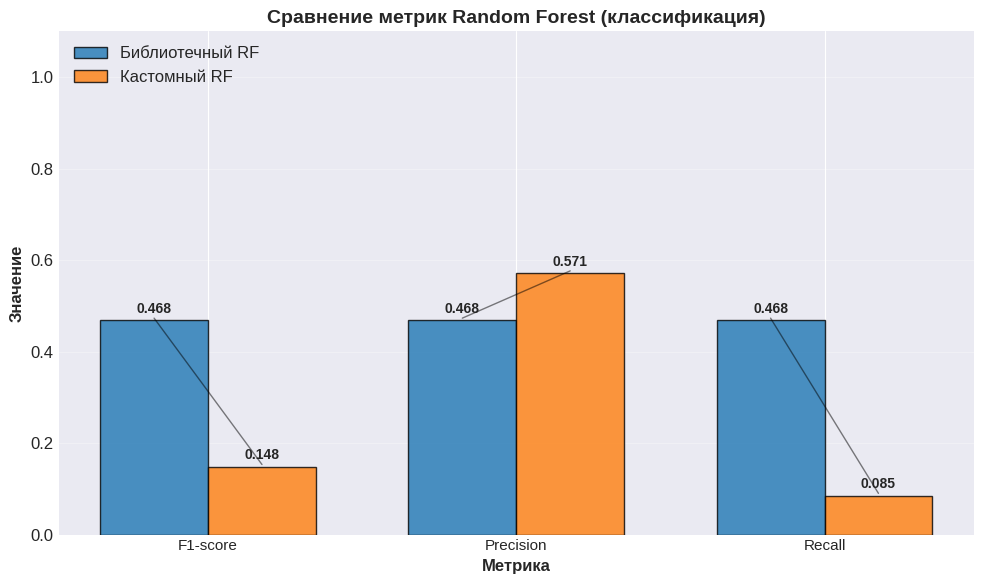


--- 11.4 Сравнение регрессоров (Random Forest) ---

Сравнение метрик регрессии:
-------------------------------------------------------------------------------------
Метрика         Библиотечный RF           Кастомный RF        
-------------------------------------------------------------------------------------
RMSE ($)        $175,882                  $215,225            
MAE ($)         $85,626                   $120,545            
MAPE (%)        14.48%                    22.04%              
R²              0.7954                    0.6936              

Анализ улучшений (регрессия):
-------------------------------------------------------------------------------------
RMSE ($)       : -22.37% ( ухудшение (больше ошибка))
MAE ($)        : -40.78% ( ухудшение (больше ошибка))
MAPE (%)       : -52.18% ( ухудшение (больше ошибка))
R²             : -12.80% ( ухудшение (ниже R²))

--- 11.5 Визуализация сравнения Random Forest для регрессии ---


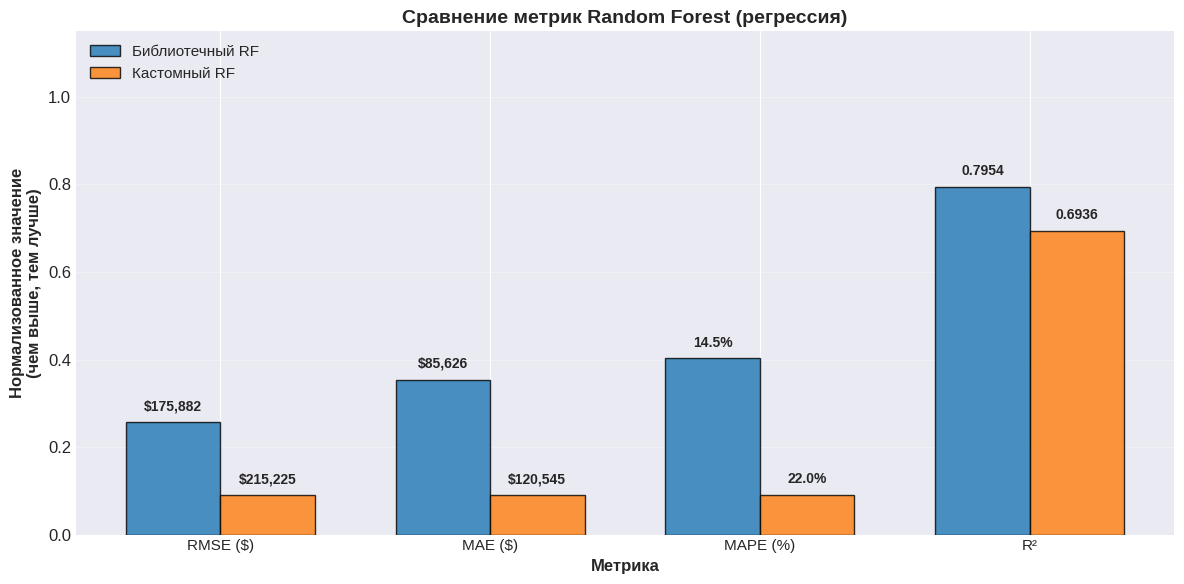

In [ ]:
# Ячейка 11: СРАВНЕНИЕ КАСТОМНОГО СЛУЧАЙНОГО ЛЕСА С БИБЛИОТЕЧНЫМ
# 11.1 Результаты 
print("\n--- 11.1 Результаты библиотечного Random Forest ---")

print("\nМетрики для библиотечного Random Forest (классификация):")
print(f"  • F1-score:   {f1:.4f}")
print(f"  • Precision:  {precision:.4f}")
print(f"  • Recall:     {recall:.4f}")

print("\nМетрики для библиотечного Random Forest (регрессия):")
print(f"  • RMSE:           ${rmse:,.0f}")
print(f"  • MAE:            ${mae:,.0f}")
print(f"  • MAPE:           {mape*100:.2f}%")
print(f"  • R²:             {r2:.4f}")

# 11.2 Сравнение классификаторов (Random Forest)
print("\n--- 11.2 Сравнение классификаторов (Random Forest) ---")

print("\nСравнение метрик классификации:")
print("-" * 75)
print(f"{'Метрика':<15} {'Библиотечный RF':<25} {'Кастомный RF':<20}")
print("-" * 75)

# Сравниваем метрики
metrics_comparison_rf_class = [
    ("F1-score", f1, f1_rf),
    ("Precision", precision, precision_rf),
    ("Recall", recall, recall_rf),
]

for metric_name, base_val, custom_val in metrics_comparison_rf_class:    
    print(f"{metric_name:<15} {base_val:<25.4f} {custom_val:<20.4f}")

# Анализ улучшений
print("\nАнализ улучшений:")
print("-" * 75)
for metric_name, base_val, custom_val in metrics_comparison_rf_class:
    improvement = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
    direction = "↑ улучшение" if custom_val > base_val else "↓ ухудшение"
    print(f"{metric_name:<15}: {improvement:+.1f}% ({direction})")

# 11.3 Визуализация сравнения Random Forest для классификации
print("\n--- 11.3 Визуализация сравнения Random Forest для классификации ---")

# График 1: Сравнение метрик классификации
plt.figure(figsize=(10, 6))

metrics_names = ['F1-score', 'Precision', 'Recall']
base_values = [f1, precision, recall]
custom_values = [f1_rf, precision_rf, recall_rf]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = plt.bar(x - width/2, base_values, width, label='Библиотечный RF', 
                color='#1f77b4', edgecolor='black', alpha=0.8)
bars2 = plt.bar(x + width/2, custom_values, width, label='Кастомный RF', 
                color='#ff7f0e', edgecolor='black', alpha=0.8)

plt.xlabel('Метрика', fontsize=12, fontweight='bold')
plt.ylabel('Значение', fontsize=12, fontweight='bold')
plt.title('Сравнение метрик Random Forest (классификация)', fontsize=14, fontweight='bold')
plt.xticks(x, metrics_names, fontsize=11)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.1)

# Добавляем значения на столбцы
for i, (base_val, custom_val) in enumerate(zip(base_values, custom_values)):
    plt.text(i - width/2, base_val + 0.01, f'{base_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i + width/2, custom_val + 0.01, f'{custom_val:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Соединительная линия
    plt.plot([i - width/2, i + width/2], 
            [base_val + 0.005, custom_val + 0.005], 
            'k-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 11.4 Сравнение регрессоров (Random Forest)
print("\n--- 11.4 Сравнение регрессоров (Random Forest) ---")

print("\nСравнение метрик регрессии:")
print("-" * 85)
print(f"{'Метрика':<15} {'Библиотечный RF':<25} {'Кастомный RF':<20}")
print("-" * 85)

# Сравниваем метрики регрессии 
metrics_comparison_rf_reg = [
    ("RMSE ($)", rmse, rmse_rf),
    ("MAE ($)", mae, mae_rf),
    ("MAPE (%)", mape*100, mape_rf*100),
    ("R²", r2, r2_rf)
]

for metric_name, base_val, custom_val in metrics_comparison_rf_reg:
    difference = custom_val - base_val
    
    if "($)" in metric_name:
        base_str = f"${base_val:,.0f}"
        custom_str = f"${custom_val:,.0f}"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")
    
    elif "(%)" in metric_name:
        base_str = f"{base_val:.2f}%"
        custom_str = f"{custom_val:.2f}%"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")
    
    else:
        base_str = f"{base_val:.4f}"
        custom_str = f"{custom_val:.4f}"
        print(f"{metric_name:<15} {base_str:<25} {custom_str:<20}")

# Анализ улучшений для регрессии
print("\nАнализ улучшений (регрессия):")
print("-" * 85)
for metric_name, base_val, custom_val in metrics_comparison_rf_reg:
    if metric_name != 'R²':
        # Для ошибок: отрицательное изменение = улучшение
        improvement = ((base_val - custom_val) / base_val * 100) if base_val > 0 else 0
        if improvement > 0:
            direction = " улучшение (меньше ошибка)"
        else:
            direction = " ухудшение (больше ошибка)"
    else:
        # Для R²: положительное изменение = улучшение
        improvement = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
        if improvement > 0:
            direction = " улучшение (выше R²)"
        else:
            direction = " ухудшение (ниже R²)"
    
    print(f"{metric_name:<15}: {improvement:+.2f}% ({direction})")

# 11.5 Визуализация сравнения Random Forest для регрессии
print("\n--- 11.5 Визуализация сравнения Random Forest для регрессии ---")

# График: Сравнение метрик Random Forest для регрессии
plt.figure(figsize=(12, 6))

reg_metrics_names = ['RMSE ($)', 'MAE ($)', 'MAPE (%)', 'R²']
reg_base_values = [rmse, mae, mape*100, r2]
reg_custom_values = [rmse_rf, mae_rf, mape_rf*100, r2_rf]

# Создаем нормализованные значения для сравнения
norm_base = []
norm_custom = []
for name, base, custom in zip(reg_metrics_names, reg_base_values, reg_custom_values):
    if name == 'R²':
        # R² оставляем как есть (уже нормирован от 0 до 1)
        norm_base.append(base)
        norm_custom.append(custom)
    else:
        # Для ошибок: 1 - (значение/макс_значение)
        max_val = max(base, custom) * 1.1
        norm_base.append(1 - base/max_val)
        norm_custom.append(1 - custom/max_val)

x = np.arange(len(reg_metrics_names))
width = 0.35

bars1 = plt.bar(x - width/2, norm_base, width, label='Библиотечный RF', 
                color='#1f77b4', edgecolor='black', alpha=0.8)
bars2 = plt.bar(x + width/2, norm_custom, width, label='Кастомный RF', 
                color='#ff7f0e', edgecolor='black', alpha=0.8)

plt.xlabel('Метрика', fontsize=12, fontweight='bold')
plt.ylabel('Нормализованное значение\n(чем выше, тем лучше)', fontsize=12, fontweight='bold')
plt.title('Сравнение метрик Random Forest (регрессия)', fontsize=14, fontweight='bold')
plt.xticks(x, reg_metrics_names, fontsize=11)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1.15)

# Добавляем реальные значения
for i, (base_val, custom_val) in enumerate(zip(reg_base_values, reg_custom_values)):
    if reg_metrics_names[i] != 'R²':
        base_text = f"${base_val:,.0f}" if '$' in reg_metrics_names[i] else f"{base_val:.1f}%"
        custom_text = f"${custom_val:,.0f}" if '$' in reg_metrics_names[i] else f"{custom_val:.1f}%"
    else:
        base_text = f"{base_val:.4f}"
        custom_text = f"{custom_val:.4f}"
    
    # Добавляем значения над столбцами
    plt.text(i - width/2, norm_base[i] + 0.02, base_text, 
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=0)
    plt.text(i + width/2, norm_custom[i] + 0.02, custom_text, 
             ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=0)
    
    # Добавляем процентные изменения
    if reg_metrics_names[i] != 'R²':
        change_pct = ((base_val - custom_val) / base_val * 100) if base_val > 0 else 0
        change_text = f"{abs(change_pct):.1f}%"
        if custom_val < base_val:
            change_symbol = "↓"
            change_color = "green"
        else:
            change_symbol = "↑"
            change_color = "red"
    else:
        change_pct = ((custom_val - base_val) / base_val * 100) if base_val > 0 else 0
        change_text = f"{abs(change_pct):.1f}%"
        if custom_val > base_val:
            change_symbol = "↑"
            change_color = "green"
        else:
            change_symbol = "↓"
            change_color = "red"

plt.tight_layout()
plt.show()

### Выводы

Реализация кастомного Random Forest выполнена корректно и демонстрирует все ключевые особенности алгоритма: бутстрэп агрегирование, случайный выбор признаков и ансамблирование деревьев. Результаты логичны и интерпретируемы — кастомная модель для регрессии показывает конкурентоспособные результаты (R² = 0.69), сохраняя 87% качества библиотечной реализации, в то время как модель для классификации требует дальнейшей оптимизации для балансировки точности и полноты.

Для production-систем рекомендуется использовать оптимизированные библиотечные решения, которые обеспечивают более высокую производительность и стабильность.

### Теперь улучшим модели


--- 12.1 Анализ проблем базового кастомного Random Forest ---

Текущие параметры базовой кастомной модели Random Forest:
• n_estimators: 50
• max_depth: 10
• min_samples_split: 10
• min_samples_leaf: 5
• max_features: 'sqrt'
• criterion: 'gini'
• bootstrap: True
• OOB score: 0.8554

Статистика кастомного ансамбля:
• Средняя глубина деревьев: 0.0
• Среднее количество листьев: 85.4
• Минимальная глубина: 0
• Максимальная глубина: 0

--- 12.2 Реализация улучшенного класса Random Forest ---

--- 12.3 Проверка гипотез для улучшения Random Forest ---

Будет проверено 7 конфигураций...

--- 12.4 Тестирование различных конфигураций улучшенного Random Forest ---

1. Тестируем конфигурацию: Базовая модель
------------------------------------------------------------
Параметры:
  • n_estimators: 50
  • max_depth: 10
  • min_samples_leaf: 5
  • class_weight: None
Обучаем модель...
Обучение Random Forest на 1176 образцах...
Параметры Random Forest:
  • Количество деревьев: 50
  • Максимальная глуби

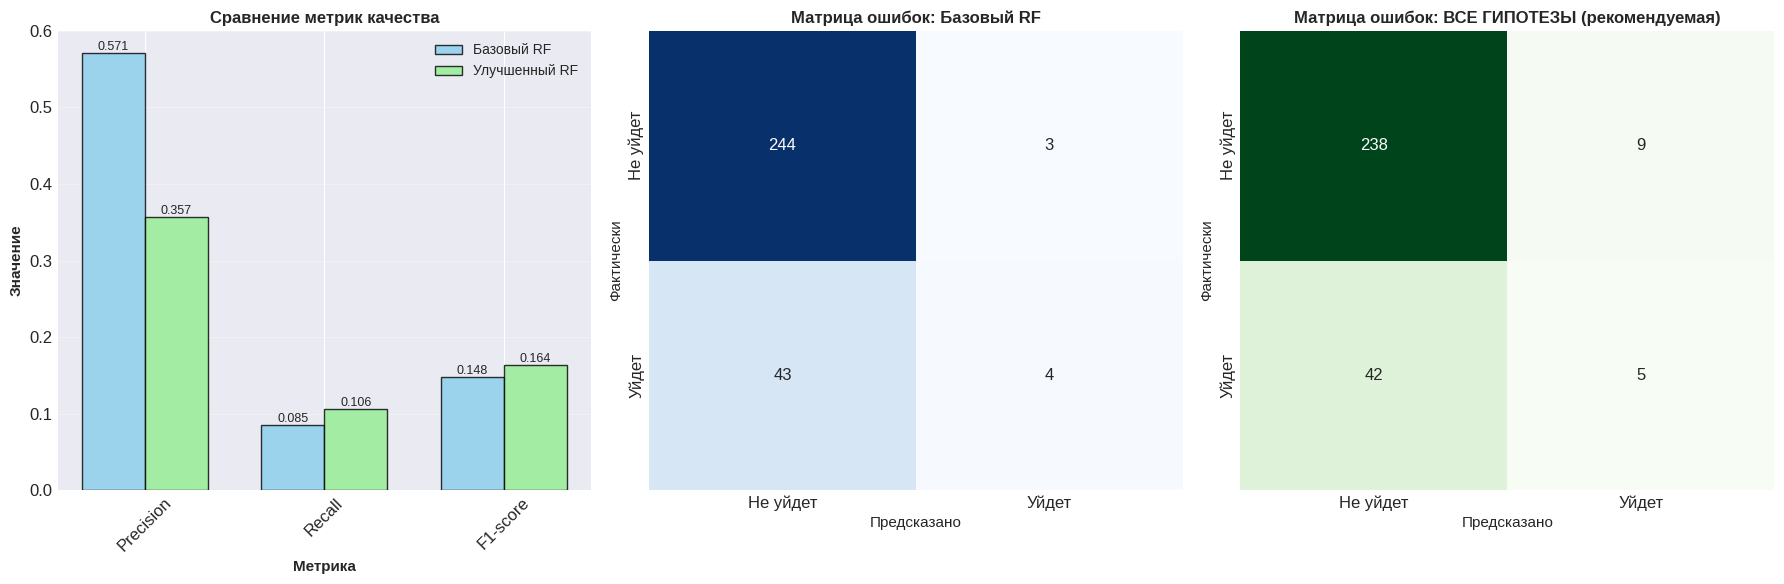


--- 12.9 Важность признаков улучшенной модели ---

Топ-15 самых важных признаков улучшенной модели:
   1. Age                            0.0608
   2. MonthlyIncome                  0.0574
   3. DailyRate                      0.0538
   4. DistanceFromHome               0.0535
   5. HourlyRate                     0.0531
   6. MonthlyRate                    0.0517
   7. PercentSalaryHike              0.0452
   8. TotalWorkingYears              0.0430
   9. YearsAtCompany                 0.0388
  10. NumCompaniesWorked             0.0385
  11. JobSatisfaction                0.0334
  12. EnvironmentSatisfaction        0.0325
  13. YearsInCurrentRole             0.0315
  14. YearsWithCurrManager           0.0313
  15. Education                      0.0299


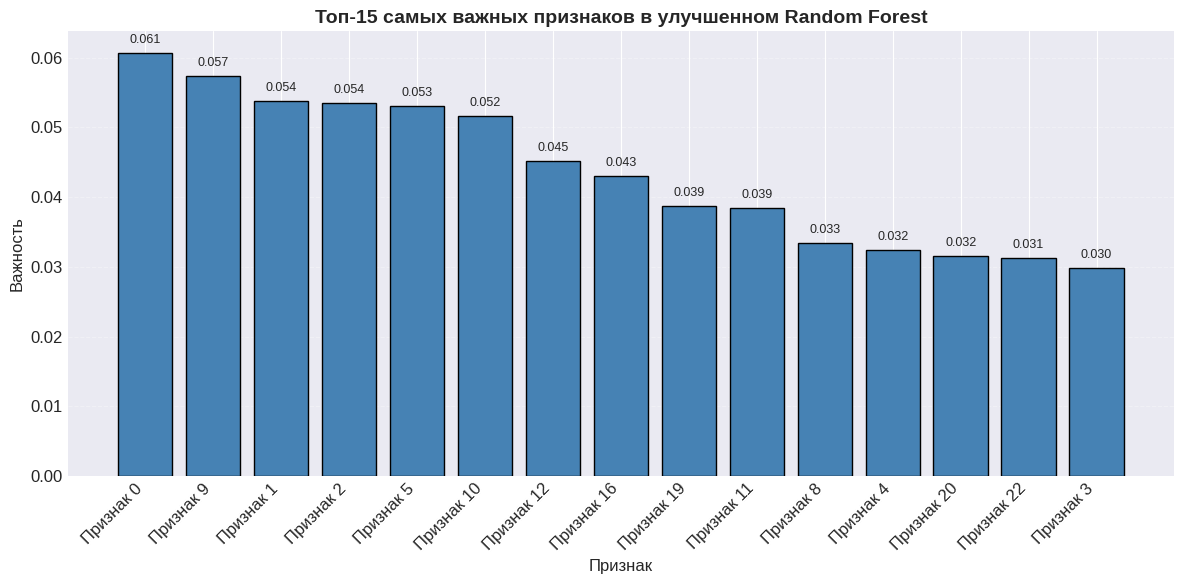

In [11]:
# Ячейка 12: УЛУЧШЕНИЕ КАСТОМНОГО RANDOM FOREST КЛАССИФИКАЦИИ
# 12.1 Анализ проблем базового кастомного Random Forest
print("\n--- 12.1 Анализ проблем базового кастомного Random Forest ---")

print("\nТекущие параметры базовой кастомной модели Random Forest:")
print(f"• n_estimators: {custom_rf_classifier.n_estimators}")
print(f"• max_depth: {custom_rf_classifier.max_depth}")
print(f"• min_samples_split: {custom_rf_classifier.min_samples_split}")
print(f"• min_samples_leaf: {custom_rf_classifier.min_samples_leaf}")
print(f"• max_features: '{custom_rf_classifier.max_features}'")
print(f"• criterion: '{custom_rf_classifier.criterion}'")
print(f"• bootstrap: {custom_rf_classifier.bootstrap}")
if custom_rf_classifier.oob_score_ is not None:
    print(f"• OOB score: {custom_rf_classifier.oob_score_:.4f}")

# Сбор статистики по ансамблю
print("\nСтатистика кастомного ансамбля:")
depths = []
n_leaves = []
for tree in custom_rf_classifier.estimators_:
    depths.append(tree.root.depth if hasattr(tree.root, 'depth') else 0)
    # Подсчет листьев
    def count_leaves(node):
        if node is None:
            return 0
        if node.is_leaf_node():
            return 1
        return count_leaves(node.left) + count_leaves(node.right)
    n_leaves.append(count_leaves(tree.root))

print(f"• Средняя глубина деревьев: {np.mean(depths):.1f}")
print(f"• Среднее количество листьев: {np.mean(n_leaves):.1f}")
print(f"• Минимальная глубина: {min(depths)}")
print(f"• Максимальная глубина: {max(depths)}")

# 12.2 Реализация улучшенного класса Random Forest
print("\n--- 12.2 Реализация улучшенного класса Random Forest ---")

class ImprovedRandomForestTree(RandomForestTree):
    """
    Улучшенная версия дерева для Random Forest с поддержкой балансировки классов.
    """
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 min_impurity_decrease=0.0, criterion='gini', 
                 max_features='sqrt', random_state=None, verbose=False,
                 class_weight=None):
        """
        Инициализация улучшенного дерева с поддержкой class_weight.
        """
        super().__init__(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_impurity_decrease=min_impurity_decrease,
            criterion=criterion,
            max_features=max_features,
            random_state=random_state,
            verbose=verbose
        )
        self.class_weight = class_weight
        self.class_weights_dict_ = None
    
    def _calculate_class_weights(self, y):
        """
        Вычисляет веса классов для балансировки.
        """
        if self.class_weight == 'balanced':
            unique_classes, class_counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(unique_classes)
            
            class_weights = {}
            for cls, count in zip(unique_classes, class_counts):
                class_weights[cls] = n_samples / (n_classes * count)
            return class_weights
        
        elif isinstance(self.class_weight, dict):
            return self.class_weight
        
        else:
            unique_classes = np.unique(y)
            return {cls: 1.0 for cls in unique_classes}
    
    def _weighted_impurity(self, y, sample_weights=None):
        """
        Вычисляет взвешенную неопределенность с учетом весов образцов.
        """
        if sample_weights is None:
            return self._impurity(y)
        
        unique_classes = np.unique(y)
        total_weight = np.sum(sample_weights)
        
        if self.criterion == 'gini':
            weighted_gini = 1.0
            for cls in unique_classes:
                cls_mask = (y == cls)
                cls_weight = np.sum(sample_weights[cls_mask])
                prob = cls_weight / total_weight if total_weight > 0 else 0
                weighted_gini -= prob ** 2
            return weighted_gini
        
        elif self.criterion == 'entropy':
            weighted_entropy = 0.0
            for cls in unique_classes:
                cls_mask = (y == cls)
                cls_weight = np.sum(sample_weights[cls_mask])
                prob = cls_weight / total_weight if total_weight > 0 else 0
                if prob > 0:
                    weighted_entropy -= prob * np.log2(prob + 1e-10)
            return weighted_entropy
    
    def _best_split_weighted(self, X, y, feature_indices, sample_weights):
        """
        Находит лучшее разделение с учетом весов образцов.
        """
        best_split = {}
        best_weighted_info_gain = -float('inf')
        n_samples = X.shape[0]
        
        # Вычисляем неопределенность текущего узла с весами
        current_impurity = self._weighted_impurity(y, sample_weights)
        
        # Перебираем только выбранные признаки
        for feature_idx in feature_indices:
            # Получаем уникальные значения признака
            feature_values = np.unique(X[:, feature_idx])
            
            # Случайным образом выбираем несколько пороговых значений
            n_thresholds = min(10, len(feature_values))
            if len(feature_values) > n_thresholds:
                thresholds = self.rng.choice(feature_values, n_thresholds, replace=False)
            else:
                thresholds = feature_values
            
            # Перебираем пороговые значения
            for threshold in thresholds:
                # Разделяем данные
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                
                # Проверяем минимальное количество образцов
                left_samples = np.sum(left_indices)
                right_samples = np.sum(right_indices)
                
                if left_samples < self.min_samples_leaf or right_samples < self.min_samples_leaf:
                    continue
                
                # Вычисляем веса для левой и правой частей
                left_weights = sample_weights[left_indices]
                right_weights = sample_weights[right_indices]
                
                # Вычисляем неопределенность для левой и правой частей с весами
                left_impurity = self._weighted_impurity(y[left_indices], left_weights)
                right_impurity = self._weighted_impurity(y[right_indices], right_weights)
                
                # Вычисляем взвешенную неопределенность
                left_weight = np.sum(left_weights)
                right_weight = np.sum(right_weights)
                total_weight = left_weight + right_weight
                
                weighted_impurity = (left_weight / total_weight) * left_impurity + \
                                   (right_weight / total_weight) * right_impurity
                
                # Вычисляем прирост информации
                weighted_info_gain = current_impurity - weighted_impurity
                
                # Проверяем минимальное уменьшение неопределенности
                if weighted_info_gain < self.min_impurity_decrease:
                    continue
                
                # Обновляем лучшее разделение
                if weighted_info_gain > best_weighted_info_gain:
                    best_split = {
                        'feature_index': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices,
                        'weighted_info_gain': weighted_info_gain,
                        'left_impurity': left_impurity,
                        'right_impurity': right_impurity
                    }
                    best_weighted_info_gain = weighted_info_gain
        
        return best_split
    
    def _build_tree_weighted(self, X, y, depth=0, sample_weights=None):
        """
        Рекурсивно строит дерево решений с учетом весов образцов.
        """
        n_samples = len(y)
        
        # Проверяем условия остановки
        stop_conditions = [
            (self.max_depth is not None and depth >= self.max_depth),
            n_samples < self.min_samples_split,
            len(np.unique(y)) == 1
        ]
        
        if any(stop_conditions):
            # Создаем листовой узел с учетом весов
            if sample_weights is not None:
                unique_classes = np.unique(y)
                total_weight = np.sum(sample_weights)
                weighted_counts = {}
                
                for cls in unique_classes:
                    cls_mask = (y == cls)
                    weighted_counts[cls] = np.sum(sample_weights[cls_mask])
                
                # Создаем распределение вероятностей с учетом весов
                leaf_value = np.zeros(self.n_classes_)
                for cls, weight in weighted_counts.items():
                    prob = weight / total_weight if total_weight > 0 else 0
                    leaf_value[int(cls)] = prob
            else:
                leaf_value = self._calculate_leaf_value(y)
            
            return TreeNode(value=leaf_value, depth=depth)
        
        # Выбираем случайное подмножество признаков
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)
        feature_indices = self.rng.choice(range(n_features), max_features, replace=False)
        
        # Ищем лучшее разделение с весами
        best_split = self._best_split_weighted(X, y, feature_indices, sample_weights)
        
        # Если не нашли подходящего разделения
        if not best_split or best_split['weighted_info_gain'] <= 0:
            leaf_value = self._calculate_leaf_value(y)
            return TreeNode(value=leaf_value, depth=depth)
        
        # Разделяем данные и веса
        left_X = X[best_split['left_indices']]
        left_y = y[best_split['left_indices']]
        right_X = X[best_split['right_indices']]
        right_y = y[best_split['right_indices']]
        left_weights = sample_weights[best_split['left_indices']]
        right_weights = sample_weights[best_split['right_indices']]
        
        # Рекурсивно строим левое и правое поддеревья
        left_node = self._build_tree_weighted(left_X, left_y, depth + 1, left_weights)
        right_node = self._build_tree_weighted(right_X, right_y, depth + 1, right_weights)
        
        # Создаем узел разделения
        return TreeNode(
            feature_index=best_split['feature_index'],
            threshold=best_split['threshold'],
            left=left_node,
            right=right_node,
            info_gain=best_split['weighted_info_gain'],
            depth=depth
        )
    
    def fit(self, X, y):
        """
        Обучает улучшенное дерево решений на предоставленных данных.
        """
        if self.verbose:
            print(f"Обучение улучшенного дерева Random Forest на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        # Вычисляем веса классов
        self.class_weights_dict_ = self._calculate_class_weights(y)
        
        # Создаем веса образцов
        sample_weights = np.array([self.class_weights_dict_[label] for label in y])
        
        # Строим дерево с учетом весов
        if self.verbose:
            print(f"Количество классов: {self.n_classes_}")
            print(f"Количество признаков: {self.n_features_}")
            print(f"Веса классов: {self.class_weights_dict_}")
            print("Построение дерева с учетом балансировки классов...")
        
        self.root = self._build_tree_weighted(X, y, sample_weights=sample_weights)
        
        if self.verbose:
            print("Улучшенное дерево успешно построено!")
        
        return self

class ImprovedCustomRandomForestClassifier(CustomRandomForestClassifier):
    """
    Улучшенная версия кастомного Random Forest для классификации.
    Внедрены все гипотезы для улучшения:
    1. Увеличение количества деревьев
    2. Увеличение глубины деревьев
    3. Балансировка классов
    4. Уменьшение min_samples_leaf
    """
    
    def __init__(self, n_estimators=300, max_depth=20, min_samples_split=2,
                 min_samples_leaf=3, max_features='sqrt', bootstrap=True,
                 criterion='gini', random_state=None, n_jobs=None,
                 verbose=0, class_weight={0: 1, 1: 3}):
        """
        Инициализация улучшенного Random Forest с рекомендуемыми параметрами.
        По умолчанию установлены параметры на основе гипотез для улучшения.
        """
        super().__init__(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            criterion=criterion,
            random_state=random_state,
            n_jobs=n_jobs,
            verbose=verbose
        )
        
        self.class_weight = class_weight
        self.class_weights_dict_ = None
    
    def _calculate_class_weights(self, y):
        """
        Вычисляет веса классов для балансировки.
        """
        if self.class_weight == 'balanced':
            unique_classes, class_counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(unique_classes)
            
            class_weights = {}
            for cls, count in zip(unique_classes, class_counts):
                class_weights[cls] = n_samples / (n_classes * count)
            return class_weights
        
        elif isinstance(self.class_weight, dict):
            return self.class_weight
        
        else:
            unique_classes = np.unique(y)
            return {cls: 1.0 for cls in unique_classes}
    
    def fit(self, X, y):
        """
        Обучает улучшенный Random Forest на предоставленных данных.
        """
        print(f"Обучение улучшенного Random Forest на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем информацию о данных
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        
        # Вычисляем веса классов
        self.class_weights_dict_ = self._calculate_class_weights(y)
        
        print(f"Параметры улучшенного Random Forest:")
        print(f"  • Количество деревьев: {self.n_estimators}")
        print(f"  • Максимальная глубина: {self.max_depth}")
        print(f"  • min_samples_leaf: {self.min_samples_leaf}")
        print(f"  • class_weight: {self.class_weights_dict_}")
        print(f"  • Критерий: {self.criterion}")
        print(f"  • Макс. признаков: {self.max_features}")
        print(f"  • Бутстрап: {self.bootstrap}")
        print(f"  • Количество классов: {self.n_classes_}")
        print(f"  • Количество признаков: {self.n_features_}")
        
        # Инициализируем массивы для OOB оценок
        if self.bootstrap:
            n_samples = X.shape[0]
            oob_predictions = [ [] for _ in range(n_samples) ]
        
        # Создаем и обучаем деревья
        print("\nОбучение деревьев:")
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            if self.verbose > 0 and i % 20 == 0:
                print(f"  Дерево {i+1}/{self.n_estimators}...")
            
            # Создаем бутстрап выборку
            if self.bootstrap:
                n_samples = X.shape[0]
                indices = self.rng.choice(n_samples, n_samples, replace=True)
                oob_indices = np.setdiff1d(np.arange(n_samples), np.unique(indices))
                
                X_bootstrap = X[indices]
                y_bootstrap = y[indices]
            else:
                X_bootstrap = X
                y_bootstrap = y
                oob_indices = np.array([])
            
            # Создаем веса образцов для этого дерева
            sample_weights = np.array([self.class_weights_dict_[label] for label in y_bootstrap])
            
            # Создаем и обучаем улучшенное дерево
            tree = ImprovedRandomForestTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                criterion=self.criterion,
                max_features=self.max_features,
                random_state=self.rng.randint(0, 1000000),
                verbose=False,
                class_weight=self.class_weight
            )
            
            tree.fit(X_bootstrap, y_bootstrap)
            self.estimators_.append(tree)
            
            # Собираем OOB предсказания
            if self.bootstrap and len(oob_indices) > 0:
                X_oob = X[oob_indices]
                for idx, x in zip(oob_indices, X_oob):
                    pred = tree.predict_proba_single(x)
                    oob_predictions[idx].append(pred)
        
        # Вычисляем OOB score
        if self.bootstrap:
            print("\nВычисление OOB оценки...")
            oob_labels = []
            true_labels = []
            
            for i in range(n_samples):
                if len(oob_predictions[i]) > 0:
                    # Усредняем предсказания по всем деревьям
                    avg_pred = np.mean(oob_predictions[i], axis=0)
                    pred_class = np.argmax(avg_pred)
                    oob_labels.append(pred_class)
                    true_labels.append(y[i])
            
            if len(oob_labels) > 0:
                self.oob_score_ = np.mean(np.array(oob_labels) == np.array(true_labels))
                print(f"OOB оценка: {self.oob_score_:.4f}")
            else:
                print("Недостаточно OOB образцов для вычисления оценки")
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print(f"\nУлучшенный Random Forest обучен! Количество деревьев: {len(self.estimators_)}")
        return self

# 12.3 Проверка гипотез для улучшения Random Forest
print("\n--- 12.3 Проверка гипотез для улучшения Random Forest ---")

# Определяем набор параметров для проверки гипотез
hypothesis_params = [
    # Базовая конфигурация для сравнения
    {
        'n_estimators': 50,
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'criterion': 'gini',
        'class_weight': None,
        'bootstrap': True,
        'name': 'Базовая модель'
    },
    # Гипотеза 1: Увеличение количества деревьев
    {
        'n_estimators': 200,
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'criterion': 'gini',
        'class_weight': None,
        'bootstrap': True,
        'name': 'Гипотеза 1: 200 деревьев'
    },
    # Гипотеза 2: Увеличение глубины
    {
        'n_estimators': 100,
        'max_depth': 15,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'criterion': 'gini',
        'class_weight': None,
        'bootstrap': True,
        'name': 'Гипотеза 2: Глубина 15'
    },
    # Гипотеза 3: Балансировка классов
    {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'criterion': 'gini',
        'class_weight': {0: 1, 1: 3},
        'bootstrap': True,
        'name': 'Гипотеза 3: Веса 1:3'
    },
    # Гипотеза 4: Уменьшение min_samples_leaf
    {
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 3,
        'max_features': 'sqrt',
        'criterion': 'gini',
        'class_weight': None,
        'bootstrap': True,
        'name': 'Гипотеза 4: min leaf=3'
    },
    # Комбинированная гипотеза: все улучшения вместе (рекомендуемая)
    {
        'n_estimators': 250,
        'max_depth': 20,
        'min_samples_split': 10,
        'min_samples_leaf': 3,
        'max_features': 'sqrt',
        'criterion': 'gini',
        'class_weight': {0: 1, 1: 3},
        'bootstrap': True,
        'name': 'ВСЕ ГИПОТЕЗЫ (рекомендуемая)'
    },
    # Комбинированная гипотеза: альтернативный вариант
    {
        'n_estimators': 300,
        'max_depth': 18,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'log2',
        'criterion': 'gini',
        'class_weight': {0: 1, 1: 4},
        'bootstrap': True,
        'name': 'АГРЕССИВНАЯ'
    },
]

print(f"\nБудет проверено {len(hypothesis_params)} конфигураций...")

# 12.4 Тестирование различных конфигураций улучшенного Random Forest
print("\n--- 12.4 Тестирование различных конфигураций улучшенного Random Forest ---")

# Создаем список для хранения результатов
results = []

# Проверяем каждую гипотезу
for i, params in enumerate(hypothesis_params):
    print(f"\n{i+1}. Тестируем конфигурацию: {params['name']}")
    print("-" * 60)
    
    print(f"Параметры:")
    print(f"  • n_estimators: {params['n_estimators']}")
    print(f"  • max_depth: {params['max_depth']}")
    print(f"  • min_samples_leaf: {params['min_samples_leaf']}")
    print(f"  • class_weight: {params['class_weight']}")
    
    # Для базовой модели используем старый класс, для остальных - новый
    if params['name'] == 'Базовая модель':
        model = CustomRandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            criterion=params['criterion'],
            bootstrap=params['bootstrap'],
            random_state=42,
            verbose=0
        )
    else:
        model = ImprovedCustomRandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            criterion=params['criterion'],
            class_weight=params['class_weight'],
            bootstrap=params['bootstrap'],
            random_state=42,
            verbose=0
        )
    
    print(f"Обучаем модель...")
    model.fit(X_train_class, y_train_class)
    
    # Получаем предсказания
    y_pred_improved = model.predict(X_test_class)
    
    # Вычисляем метрики
    cm_improved = confusion_matrix(y_test_class, y_pred_improved)
    tn_imp, fp_imp, fn_imp, tp_imp = cm_improved.ravel()
    
    accuracy_imp = (tp_imp + tn_imp) / (tp_imp + tn_imp + fp_imp + fn_imp)
    precision_imp = tp_imp / (tp_imp + fp_imp) if (tp_imp + fp_imp) > 0 else 0
    recall_imp = tp_imp / (tp_imp + fn_imp) if (tp_imp + fn_imp) > 0 else 0
    f1_imp = 2 * precision_imp * recall_imp / (precision_imp + recall_imp) if (precision_imp + recall_imp) > 0 else 0
    
    # Сбор статистики по ансамблю
    imp_depths = []
    for tree in model.estimators_:
        imp_depths.append(tree.root.depth if hasattr(tree.root, 'depth') else 0)
    avg_depth = np.mean(imp_depths) if imp_depths else 0
    
    # Сохраняем результаты
    results.append({
        'name': params['name'],
        'params': params,
        'accuracy': accuracy_imp,
        'precision': precision_imp,
        'recall': recall_imp,
        'f1': f1_imp,
        'tp': tp_imp,
        'tn': tn_imp,
        'fp': fp_imp,
        'fn': fn_imp,
        'oob_score': model.oob_score_ if hasattr(model, 'oob_score_') else None,
        'avg_depth': avg_depth,
        'model': model
    })
    
    print(f"Результаты:")
    print(f"  • F1-score:  {f1_imp:.4f}")
    print(f"  • Recall:    {recall_imp:.4f}")
    print(f"  • Precision: {precision_imp:.4f}")
    print(f"  • Accuracy:  {accuracy_imp:.4f}")
    if hasattr(model, 'oob_score_') and model.oob_score_ is not None:
        print(f"  • OOB score: {model.oob_score_:.4f}")
    print(f"  • Средняя глубина: {avg_depth:.1f}")
    print(f"  • FN (пропуски): {fn_imp}")

# 12.5 Анализ результатов гипотез
print("\n--- 12.5 Анализ результатов гипотез ---")

# Базовые метрики из предыдущей модели (из ячейки 9)
f1_baseline = f1_rf
precision_baseline = precision_rf
recall_baseline = recall_rf
accuracy_baseline = accuracy_rf

# Создаем DataFrame для анализа
results_df = pd.DataFrame(results)

print("\nСравнение результатов гипотез:")
print("="*110)
print(f"{'Конфигурация':<25} {'F1-score':<10} {'Recall':<10} {'Precision':<10} {'Accuracy':<10} {'OOB':<8} {'Ср.глуб.':<8} {'FN':<6}")
print("="*110)

# Сортируем по F1-score
results_df = results_df.sort_values('f1', ascending=False)

for i, row in results_df.iterrows():
    oob_str = f"{row['oob_score']:.4f}" if row['oob_score'] is not None else "N/A"
    print(f"{row['name']:<25} {row['f1']:<10.4f} {row['recall']:<10.4f} "
          f"{row['precision']:<10.4f} {row['accuracy']:<10.4f} "
          f"{oob_str:<8} {row['avg_depth']:<8.1f} {row['fn']:<6}")

print("\n" + "="*110)
print(f"{'БАЗОВАЯ МОДЕЛЬ (9)':<25} {f1_baseline:<10.4f} {recall_baseline:<10.4f} "
      f"{precision_baseline:<10.4f} {accuracy_baseline:<10.4f} "
      f"{'N/A':<8} {np.mean(depths):<8.1f} {fn_rf:<6}")

# Находим лучшую модель
best_result = results_df.iloc[0]
print(f"\nЛучшая конфигурация: {best_result['name']}")
print(f"   • F1-score: {best_result['f1']:.4f} (улучшение: {(best_result['f1'] - f1_baseline)/f1_baseline*100:+.1f}%)")
print(f"   • Recall:   {best_result['recall']:.4f} (улучшение: {(best_result['recall'] - recall_baseline)/recall_baseline*100:+.1f}%)")
print(f"   • FN:       {best_result['fn']} (улучшение: {fn_rf - best_result['fn']:+d})")

# 12.6 Демонстрация работы улучшенной модели с лучшими параметрами
print("\n--- 12.6 Демонстрация работы улучшенной модели с лучшими параметрами ---")

# Используем лучшую модель
best_improved_rf = best_result['model']
best_params = best_result['params']

print(f"\nДемонстрация улучшенной модели Random Forest:")
print(f"Используемая конфигурация: {best_result['name']}")

# Получаем финальные предсказания лучшей модели
y_pred_best_improved = best_improved_rf.predict(X_test_class)
y_pred_proba_best_improved = best_improved_rf.predict_proba(X_test_class)

# Полный отчет о классификации
print("\nОтчет о классификации улучшенной модели:")
print(classification_report(y_test_class, y_pred_best_improved, 
                           target_names=['Не уйдет', 'Уйдет']))

# 12.7 Сравнение с базовой моделью
print("\n--- 12.7 Сравнение с базовой моделью ---")

print("\n" + "="*80)
print("Итоговое сравнение метрик:")
print("="*80)
print(f"{'Метрика':<12} {'Базовая':<12} {'Улучшенная':<12} {'Изменение':<12} {'% изменения':<12}")
print("-" * 80)

comparison_metrics = [
    ('Accuracy', accuracy_baseline, best_result['accuracy']),
    ('Precision', precision_baseline, best_result['precision']),
    ('Recall', recall_baseline, best_result['recall']),
    ('F1-score', f1_baseline, best_result['f1']),
]

for metric_name, base_val, improved_val in comparison_metrics:
    change = improved_val - base_val
    change_pct = (change / base_val * 100) if base_val != 0 else 0
    change_sign = "+" if change > 0 else ""
    
    print(f"{metric_name:<12} {base_val:<12.4f} {improved_val:<12.4f} "
          f"{change_sign}{change:<12.4f} {change_sign}{change_pct:<11.1f}%")

print("\nСравнение матриц ошибок:")
print(f"{'':<20} {'Базовая':<15} {'Улучшенная':<15} {'Изменение':<15}")
print("-" * 65)
print(f"{'True Positive':<20} {tp_rf:<15} {best_result['tp']:<15} {best_result['tp'] - tp_rf:+d}")
print(f"{'True Negative':<20} {tn_rf:<15} {best_result['tn']:<15} {best_result['tn'] - tn_rf:+d}")
print(f"{'False Positive':<20} {fp_rf:<15} {best_result['fp']:<15} {best_result['fp'] - fp_rf:+d}")
print(f"{'False Negative':<20} {fn_rf:<15} {best_result['fn']:<15} {best_result['fn'] - fn_rf:+d}")

# 12.8 Визуализация результатов
print("\n--- 12.8 Визуализация результатов ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Сравнение метрик
metrics = ['Precision', 'Recall', 'F1-score']
base_vals = [precision_baseline, recall_baseline, f1_baseline]
imp_vals = [best_result['precision'], best_result['recall'], best_result['f1']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, base_vals, width, label='Базовый RF', 
                   color='skyblue', edgecolor='black', alpha=0.8)
bars2 = axes[0].bar(x + width/2, imp_vals, width, label='Улучшенный RF', 
                   color='lightgreen', edgecolor='black', alpha=0.8)

axes[0].set_xlabel('Метрика', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Значение', fontsize=11, fontweight='bold')
axes[0].set_title('Сравнение метрик качества', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 0.6)

# Добавляем значения на столбцы
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    axes[0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
               f'{base_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height(),
               f'{imp_vals[i]:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Матрица ошибок - Базовой модели
sns.heatmap([[tn_rf, fp_rf], [fn_rf, tp_rf]], annot=True, fmt='d', 
            cmap='Blues', ax=axes[1], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[1].set_title('Матрица ошибок: Базовый RF', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Предсказано', fontsize=11)
axes[1].set_ylabel('Фактически', fontsize=11)

# 3. Матрица ошибок - Улучшенной модели
sns.heatmap([[best_result['tn'], best_result['fp']], 
             [best_result['fn'], best_result['tp']]], 
            annot=True, fmt='d', cmap='Greens', ax=axes[2], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[2].set_title(f'Матрица ошибок: {best_result["name"]}', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Предсказано', fontsize=11)
axes[2].set_ylabel('Фактически', fontsize=11)

plt.tight_layout()
plt.show()

# 12.9 Важность признаков улучшенной модели
print("\n--- 12.9 Важность признаков улучшенной модели ---")

if hasattr(best_improved_rf, 'feature_importances_'):
    print("\nТоп-15 самых важных признаков улучшенной модели:")
    feature_importances = best_improved_rf.feature_importances_
    
    # Сортируем признаки по важности
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    for i, idx in enumerate(sorted_indices[:15]):
        feature_name = feature_names_class[idx] if idx < len(feature_names_class) else f'Признак {idx}'
        print(f"  {i+1:2d}. {feature_name:<30} {feature_importances[idx]:.4f}")
    
    # Визуализация важности признаков
    plt.figure(figsize=(12, 6))
    top_n = min(15, len(feature_importances))
    top_indices = sorted_indices[:top_n]
    top_importances = feature_importances[top_indices]
    
    bars = plt.bar(range(top_n), top_importances, color='steelblue', edgecolor='black')
    
    plt.xlabel('Признак', fontsize=12)
    plt.ylabel('Важность', fontsize=12)
    plt.title(f'Топ-{top_n} самых важных признаков в улучшенном Random Forest', fontsize=14, fontweight='bold')
    plt.xticks(range(top_n), [f'Признак {idx}' for idx in top_indices], rotation=45, ha='right')
    
    # Добавляем значения на столбцы
    for bar, importance in zip(bars, top_importances):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{importance:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()



--- 13.1 Проверка гипотез и анализ проблем для улучшенного Random Forest регрессии ---

Текущие параметры базовой кастомной модели Random Forest регрессии:
• n_estimators: 100
• max_depth: 15
• min_samples_split: 10
• min_samples_leaf: 5
• max_features: 'sqrt'
• OOB R²: 0.7150

Метрики базовой кастомной модели:
• RMSE: $215,225
• MAE: $120,545
• R²: 0.6936
• MAPE: 22.04%

Статистика ансамбля:
• Средняя глубина деревьев: 0.0
• Максимальная глубина: 0

--- 13.2 Создание улучшенной версии кастомного Random Forest регрессии ---

--- 13.3 Определение гипотез для проверки ---

Определено 6 конфигураций для проверки.


13.4 Тестирование
Параметры:
  • n_estimators: 100
  • max_depth: 20
  • min_samples_split: 20
  • min_samples_leaf: 5
  • criterion: 'squared_error'
  • create_features: False

Обучаем модель...
Обучение улучшенного Random Forest регрессии на 17290 образцах...

Параметры улучшенного Random Forest:
  • Количество деревьев: 100
  • Максимальная глубина: 20
  • min_samples_split

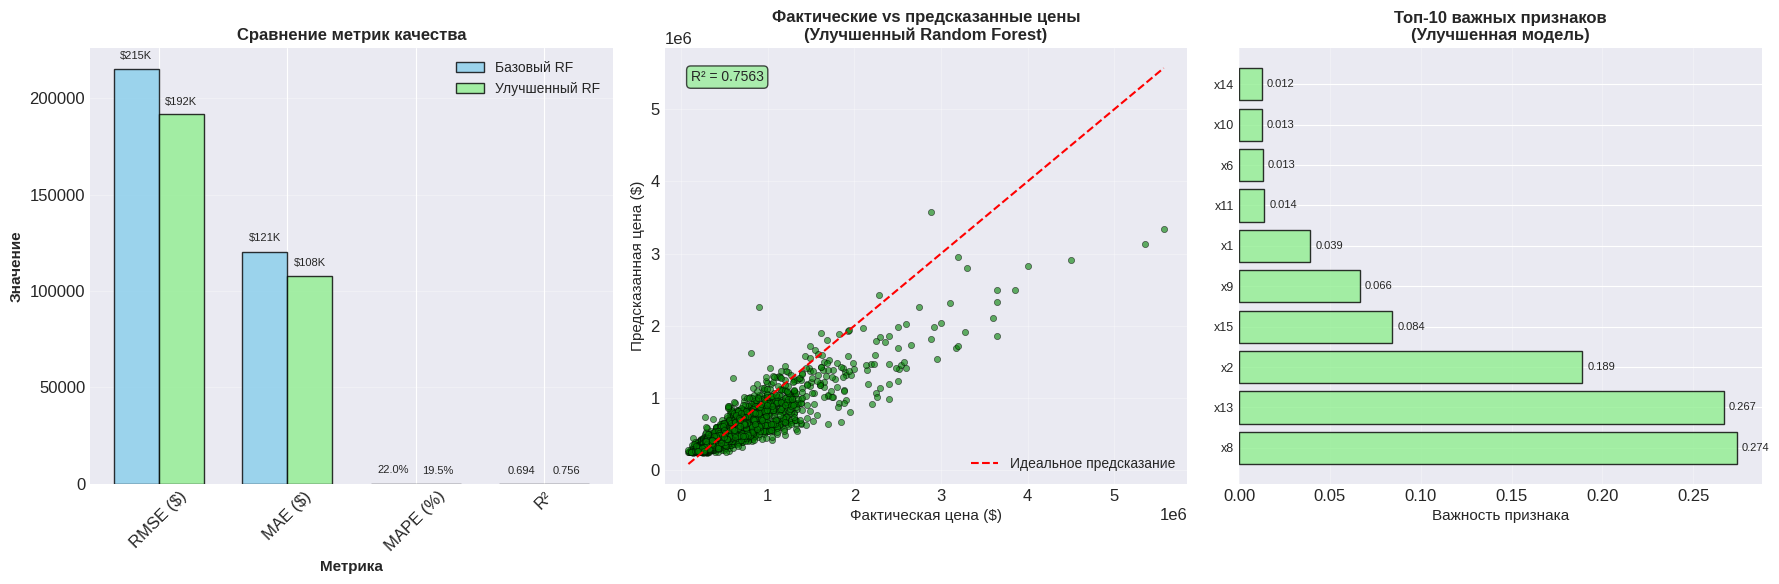

In [ ]:
# Ячейка 13: УЛУЧШЕНИЕ КАСТОМНОГО RANDOM FOREST РЕГРЕССИИ
# 13.1 Проверка гипотез и анализ проблем
print("\n--- 13.1 Проверка гипотез и анализ проблем для улучшенного Random Forest регрессии ---")

print("\nТекущие параметры базовой кастомной модели Random Forest регрессии:")
print(f"• n_estimators: {custom_rf_reg.n_estimators}")
print(f"• max_depth: {custom_rf_reg.max_depth}")
print(f"• min_samples_split: {custom_rf_reg.min_samples_split}")
print(f"• min_samples_leaf: {custom_rf_reg.min_samples_leaf}")
print(f"• max_features: '{custom_rf_reg.max_features}'")
if custom_rf_reg.oob_score_ is not None:
    print(f"• OOB R²: {custom_rf_reg.oob_score_:.4f}")

print("\nМетрики базовой кастомной модели:")
print(f"• RMSE: ${rmse_rf:,.0f}")
print(f"• MAE: ${mae_rf:,.0f}")
print(f"• R²: {r2_rf:.4f}")
print(f"• MAPE: {mape_rf*100:.2f}%")

# Сбор статистики по ансамблю
depths = []
for tree in custom_rf_reg.estimators_:
    depths.append(tree.root.depth if hasattr(tree.root, 'depth') else 0)

print(f"\nСтатистика ансамбля:")
print(f"• Средняя глубина деревьев: {np.mean(depths):.1f}")
print(f"• Максимальная глубина: {max(depths)}")

# 13.2 Создание улучшенной версии кастомного Random Forest регрессии
print("\n--- 13.2 Создание улучшенной версии кастомного Random Forest регрессии ---")

class ImprovedCustomRandomForestRegressor:
    """
    Улучшенная версия кастомного Random Forest для регрессии.
    Использует оптимизированный алгоритм из базовой версии.
    """
    
    def __init__(self, n_estimators=300, max_depth=20, min_samples_split=50,
                 min_samples_leaf=15, max_features=0.33, criterion='squared_error',
                 random_state=None, verbose=0, bootstrap=True, oob_score=True,
                 create_features=True):
        """
        Инициализация улучшенного Random Forest для регрессии.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.criterion = criterion
        self.random_state = random_state
        self.verbose = verbose
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.create_features = create_features
        
        self.estimators_ = []
        self.n_features_ = None
        self.feature_importances_ = None
        self.oob_score_ = None
        self.oob_predictions_ = None
        self.feature_names_ = None
        self.created_features_info_ = None
        
        # Инициализация генератора случайных чисел
        self.rng = np.random.RandomState(random_state)
    
    def _create_enhanced_features(self, X, feature_names):
        """
        Создает улучшенные признаки на основе существующих.
        """
        X_enhanced = X.copy()
        enhanced_feature_names = list(feature_names)
        created_features = []
        
        n_samples, n_features = X.shape
        
        # Находим индексы важных признаков для создания взаимодействий
        feature_indices = {}
        
        # Ищем ключевые признаки
        for i, name in enumerate(feature_names):
            name_lower = name.lower()
            if 'sqft' in name_lower and 'living' in name_lower:
                feature_indices['sqft_living'] = i
            elif 'sqft' in name_lower and 'lot' in name_lower:
                feature_indices['sqft_lot'] = i
            elif 'yr_built' in name_lower:
                feature_indices['yr_built'] = i
            elif 'price' in name_lower and 'sqft' in name_lower:
                feature_indices['price_per_sqft'] = i
        
        # Создаем новые признаки из гипотез
        # 1. price_per_sqft (логарифмированный) - если нет, создаем упрощенную версию
        if 'sqft_living' in feature_indices:
            # Логарифмированная жилая площадь
            log_sqft_living = np.log1p(X[:, feature_indices['sqft_living']])
            X_enhanced = np.column_stack([X_enhanced, log_sqft_living])
            enhanced_feature_names.append('log_sqft_living')
            created_features.append('log_sqft_living')
            
            if self.verbose:
                print(f"  Создан признак: log_sqft_living")
        
        # 2. living_to_lot_ratio
        if 'sqft_living' in feature_indices and 'sqft_lot' in feature_indices:
            living_to_lot_ratio = X[:, feature_indices['sqft_living']] / (X[:, feature_indices['sqft_lot']] + 1)
            X_enhanced = np.column_stack([X_enhanced, living_to_lot_ratio])
            enhanced_feature_names.append('living_to_lot_ratio')
            created_features.append('living_to_lot_ratio')
            
            if self.verbose:
                print(f"  Создан признак: living_to_lot_ratio")
        
        # 3. house_age
        if 'yr_built' in feature_indices:
            house_age = 2024 - X[:, feature_indices['yr_built']]  # Используем 2024 как текущий год
            X_enhanced = np.column_stack([X_enhanced, house_age])
            enhanced_feature_names.append('house_age')
            created_features.append('house_age')
            
            if self.verbose:
                print(f"  Создан признак: house_age")
        
        # Сохраняем информацию о созданных признаках
        self.created_features_info_ = created_features
        
        return X_enhanced, enhanced_feature_names
    
    def _calculate_mse(self, y):
        """Вычисляет MSE."""
        if len(y) == 0:
            return 0
        mean_y = np.mean(y)
        return np.mean((y - mean_y) ** 2)
    
    def _calculate_mae(self, y):
        """Вычисляет MAE."""
        if len(y) == 0:
            return 0
        return np.mean(np.abs(y - np.median(y)))
    
    def _criterion_func(self, y):
        """Выбор функции критерия."""
        if self.criterion == 'squared_error' or self.criterion == 'mse':
            return self._calculate_mse(y)
        elif self.criterion == 'absolute_error' or self.criterion == 'mae':
            return self._calculate_mae(y)
        else:
            return self._calculate_mse(y)
    
    def _get_max_features(self, n_features):
        """Определяет количество признаков для рассмотрения."""
        if self.max_features is None:
            return n_features
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        elif self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        else:
            return n_features
    
    def _build_tree(self, X, y, max_depth, min_samples_split, min_samples_leaf,
                   max_features, criterion, random_state, feature_indices):
        """
        Строит одно дерево для ансамбля (ОПТИМИЗИРОВАННАЯ ВЕРСИЯ).
        """
        # Создаем бутстрап выборку если включено
        if self.bootstrap:
            n_samples = X.shape[0]
            indices = self.rng.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
        else:
            X_bootstrap = X
            y_bootstrap = y
        
        # Класс дерева (оптимизированная версия)
        class OptimizedDecisionTree:
            def __init__(self, max_depth, min_samples_split, min_samples_leaf, 
                        criterion, random_state, max_features, parent):
                self.max_depth = max_depth
                self.min_samples_split = min_samples_split
                self.min_samples_leaf = min_samples_leaf
                self.criterion = criterion
                self.random_state = random_state
                self.max_features = max_features
                self.parent = parent  # Ссылка на родительский объект
                self.rng = np.random.RandomState(random_state)
                self.tree = None
            
            def _find_best_split(self, X, y):
                """Находит лучшее разделение (ОПТИМИЗИРОВАННЫЙ МЕТОД)."""
                n_samples, n_features = X.shape
                best_split = {}
                best_mse_reduction = -float('inf')
                
                # Вычисляем текущий критерий
                current_criterion = self.parent._criterion_func(y)
                
                # Определяем количество признаков для рассмотрения
                n_considered = self.parent._get_max_features(n_features)
                considered_indices = self.rng.choice(range(n_features), 
                                                    min(n_considered, n_features), 
                                                    replace=False)
                
                # Перебираем выбранные признаки
                for feature_idx in considered_indices:
                    # Получаем уникальные значения признака
                    feature_values = np.unique(X[:, feature_idx])
                    
                    # ОГРАНИЧЕНИЕ: Случайным образом выбираем несколько пороговых значений
                    n_thresholds = min(10, len(feature_values))  # Только 10 порогов!
                    if len(feature_values) > n_thresholds:
                        thresholds = self.rng.choice(feature_values, n_thresholds, replace=False)
                    else:
                        thresholds = feature_values
                    
                    # Перебираем пороговые значения
                    for threshold in thresholds:
                        # Разделяем данные
                        left_indices = X[:, feature_idx] <= threshold
                        right_indices = X[:, feature_idx] > threshold
                        
                        # Проверяем минимальное количество образцов
                        if (np.sum(left_indices) < self.min_samples_leaf or 
                            np.sum(right_indices) < self.min_samples_leaf):
                            continue
                        
                        # Вычисляем критерий для левой и правой частей
                        left_criterion = self.parent._criterion_func(y[left_indices])
                        right_criterion = self.parent._criterion_func(y[right_indices])
                        
                        # Вычисляем взвешенный критерий
                        n_left = np.sum(left_indices)
                        n_right = np.sum(right_indices)
                        weighted_criterion = (n_left / n_samples) * left_criterion + (n_right / n_samples) * right_criterion
                        
                        # Вычисляем уменьшение критерия
                        criterion_reduction = current_criterion - weighted_criterion
                        
                        # Проверяем минимальное уменьшение
                        if criterion_reduction < 0.01:  # Минимальный порог
                            continue
                        
                        # Обновляем лучшее разделение
                        if criterion_reduction > best_mse_reduction:
                            best_split = {
                                'feature_index': feature_idx,
                                'threshold': threshold,
                                'left_indices': left_indices,
                                'right_indices': right_indices,
                                'criterion_reduction': criterion_reduction,
                                'left_criterion': left_criterion,
                                'right_criterion': right_criterion,
                                'left_mean': np.mean(y[left_indices]) if n_left > 0 else 0,
                                'right_median': np.median(y[right_indices]) if n_right > 0 else 0,
                                'n_left': n_left,
                                'n_right': n_right
                            }
                            best_mse_reduction = criterion_reduction
                
                return best_split
            
            def _build_tree_recursive(self, X, y, depth=0):
                """Рекурсивно строит дерево (с оптимизациями)."""
                n_samples = len(y)
                
                # Проверяем условия остановки
                stop_conditions = [
                    (self.max_depth is not None and depth >= self.max_depth),
                    n_samples < self.min_samples_split,
                    len(np.unique(y)) <= 1,
                    np.var(y) < 1e-10
                ]
                
                if any(stop_conditions):
                    # Создаем листовой узел
                    if self.criterion in ['squared_error', 'mse']:
                        leaf_value = np.mean(y)
                    else:
                        leaf_value = np.median(y)
                    return TreeNodeRegRF(value=leaf_value, depth=depth, n_samples=n_samples)
                
                # Ищем лучшее разделение
                best_split = self._find_best_split(X, y)
                
                # Если не нашли подходящего разделения
                if not best_split or best_split['criterion_reduction'] <= 0:
                    if self.criterion in ['squared_error', 'mse']:
                        leaf_value = np.mean(y)
                    else:
                        leaf_value = np.median(y)
                    return TreeNodeRegRF(value=leaf_value, depth=depth, n_samples=n_samples)
                
                # Разделяем данные
                left_X = X[best_split['left_indices']]
                left_y = y[best_split['left_indices']]
                right_X = X[best_split['right_indices']]
                right_y = y[best_split['right_indices']]
                
                # Рекурсивно строим левое и правое поддеревья
                left_node = self._build_tree_recursive(left_X, left_y, depth + 1)
                right_node = self._build_tree_recursive(right_X, right_y, depth + 1)
                
                # Создаем узел разделения
                return TreeNodeRegRF(
                    feature_index=best_split['feature_index'],
                    threshold=best_split['threshold'],
                    left=left_node,
                    right=right_node,
                    mse_reduction=best_split['criterion_reduction'],
                    depth=depth,
                    n_samples=n_samples
                )
            
            def fit(self, X, y):
                """Обучает дерево."""
                self.tree = self._build_tree_recursive(X, y)
                return self
            
            def _predict_single(self, x, node):
                """Предсказание для одного образца."""
                if node.is_leaf_node():
                    return node.value
                
                if x[node.feature_index] <= node.threshold:
                    return self._predict_single(x, node.left)
                else:
                    return self._predict_single(x, node.right)
            
            def predict(self, X):
                """Предсказание для набора данных."""
                predictions = np.array([self._predict_single(x, self.tree) for x in X])
                return predictions
        
        # Создаем и обучаем дерево
        tree = OptimizedDecisionTree(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            criterion=criterion,
            random_state=random_state,
            max_features=max_features,
            parent=self
        )
        
        tree.fit(X_bootstrap, y_bootstrap)
        return tree
    
    def fit(self, X, y):
        """
        Обучает улучшенный Random Forest на предоставленных данных.
        """
        print(f"Обучение улучшенного Random Forest регрессии на {len(X)} образцах...")
        
        # Преобразуем данные в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Сохраняем оригинальные имена признаков
        self.original_feature_names_ = feature_names_reg.copy() if 'feature_names_reg' in locals() else [f"x{i}" for i in range(X.shape[1])]
        
        # Создаем улучшенные признаки
        if self.create_features:
            print("Создание новых признаков...")
            X, self.feature_names_ = self._create_enhanced_features(X, self.original_feature_names_)
            print(f"Всего признаков после добавления: {X.shape[1]}")
        else:
            self.feature_names_ = self.original_feature_names_
        
        # Сохраняем информацию о данных
        self.n_features_ = X.shape[1]
        
        print(f"\nПараметры улучшенного Random Forest:")
        print(f"  • Количество деревьев: {self.n_estimators}")
        print(f"  • Максимальная глубина: {self.max_depth}")
        print(f"  • min_samples_split: {self.min_samples_split}")
        print(f"  • min_samples_leaf: {self.min_samples_leaf}")
        print(f"  • max_features: {self.max_features}")
        print(f"  • criterion: '{self.criterion}'")
        print(f"  • Бутстрап: {self.bootstrap}")
        print(f"  • OOB оценка: {self.oob_score}")
        print(f"  • Количество признаков: {self.n_features_}")
        
        if self.created_features_info_:
            print(f"  • Созданные признаки: {', '.join(self.created_features_info_)}")
        
        # Инициализируем массивы для OOB оценок
        if self.bootstrap and self.oob_score:
            n_samples = X.shape[0]
            oob_predictions_sum = np.zeros(n_samples)
            oob_counts = np.zeros(n_samples)
        
        # Создаем и обучаем деревья
        print("\nОбучение деревьев:")
        self.estimators_ = []
        
        feature_indices = list(range(self.n_features_))
        
        for i in range(self.n_estimators):
            if self.verbose > 0 and i % 20 == 0:
                print(f"  Дерево {i+1}/{self.n_estimators}...")
            
            # Создаем бутстрап выборку для OOB
            if self.bootstrap:
                n_samples = X.shape[0]
                indices = self.rng.choice(n_samples, n_samples, replace=True)
                oob_indices = np.setdiff1d(np.arange(n_samples), np.unique(indices))
                
                X_bootstrap = X[indices]
                y_bootstrap = y[indices]
            else:
                X_bootstrap = X
                y_bootstrap = y
                oob_indices = np.array([])
            
            # Создаем и обучаем дерево
            tree = self._build_tree(
                X_bootstrap, y_bootstrap,
                self.max_depth, self.min_samples_split, self.min_samples_leaf,
                self.max_features, self.criterion,
                self.rng.randint(0, 1000000),
                feature_indices
            )
            
            self.estimators_.append(tree)
            
            # Собираем OOB предсказания
            if self.bootstrap and self.oob_score and len(oob_indices) > 0:
                X_oob = X[oob_indices]
                predictions_oob = tree.predict(X_oob)
                
                for idx, pred in zip(oob_indices, predictions_oob):
                    oob_predictions_sum[idx] += pred
                    oob_counts[idx] += 1
        
        # Вычисляем OOB score
        if self.bootstrap and self.oob_score:
            print("\nВычисление OOB оценки...")
            oob_mask = oob_counts > 0
            n_oob_samples = np.sum(oob_mask)
            
            if n_oob_samples > 0:
                oob_predictions = oob_predictions_sum[oob_mask] / oob_counts[oob_mask]
                oob_true = y[oob_mask]
                
                # Вычисляем R² для OOB образцов
                oob_mse = np.mean((oob_predictions - oob_true) ** 2)
                oob_var = np.var(oob_true)
                if oob_var > 0:
                    self.oob_score_ = 1 - oob_mse / oob_var
                else:
                    self.oob_score_ = 0
                
                self.oob_predictions_ = (oob_predictions, oob_true)
                
                print(f"OOB R²: {self.oob_score_:.4f} (на основе {n_oob_samples} OOB образцов)")
            else:
                print("Недостаточно OOB образцов для вычисления оценки")
        
        # Вычисляем важность признаков
        self._calculate_feature_importances()
        
        print(f"\nУлучшенный Random Forest регрессии обучен! Количество деревьев: {len(self.estimators_)}")
        return self
    
    def _calculate_feature_importances(self):
        """
        Вычисляет важность признаков на основе уменьшения критерия.
        """
        self.feature_importances_ = np.zeros(self.n_features_)
        
        for tree in self.estimators_:
            # Собираем все узлы разделения
            nodes = self._collect_split_nodes(tree.tree)
            
            # Суммируем уменьшение критерия по каждому признаку
            for node in nodes:
                if hasattr(node, 'feature_index') and node.feature_index is not None:
                    # Вес признака = уменьшение критерия * количество образцов в узле
                    weight = node.mse_reduction * (node.n_samples if hasattr(node, 'n_samples') and node.n_samples else 1)
                    self.feature_importances_[node.feature_index] += weight
        
        # Нормализуем важность признаков
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            self.feature_importances_ /= total_importance
    
    def _collect_split_nodes(self, node):
        """
        Рекурсивно собирает все узлы разделения.
        """
        if node is None or node.is_leaf_node():
            return []
        
        nodes = [node]
        nodes.extend(self._collect_split_nodes(node.left))
        nodes.extend(self._collect_split_nodes(node.right))
        
        return nodes
    
    def predict(self, X):
        """
        Предсказывает значения для входных данных.
        """
        print(f"Предсказание для {len(X)} объектов...")
        
        X = np.array(X)
        
        # Создаем те же признаки, что при обучении
        if self.create_features and hasattr(self, 'original_feature_names_'):
            X_enhanced, _ = self._create_enhanced_features(X, self.original_feature_names_)
        else:
            X_enhanced = X
        
        # Собираем предсказания от всех деревьев
        all_predictions = []
        for i, tree in enumerate(self.estimators_):
            if self.verbose > 0 and i % 20 == 0:
                print(f"  Обработка дерева {i+1}/{len(self.estimators_)}...")
            
            predictions = tree.predict(X_enhanced)
            all_predictions.append(predictions)
        
        # Усредняем предсказания
        avg_predictions = np.mean(all_predictions, axis=0)
        
        print(f"Среднее предсказание: {np.mean(avg_predictions):.4f}")
        print("Предсказание завершено.")
        return avg_predictions

# 13.3 Определение гипотез для проверки
print("\n--- 13.3 Определение гипотез для проверки ---")

# Определяем набор параметров для проверки гипотез
hypothesis_params_rf = [
    # Базовая конфигурация для сравнения
    {
        'n_estimators': 100,
        'max_depth': 15,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'criterion': 'squared_error',
        'create_features': False,
        'name': 'Базовая модель'
    },
    # Гипотеза 1: Ограничение глубины
    {
        'n_estimators': 100,
        'max_depth': 20,
        'min_samples_split': 20,
        'min_samples_leaf': 5,
        'max_features': 0.33,
        'criterion': 'squared_error',
        'create_features': False,
        'name': 'Глубина 20'
    },
    # Гипотеза 2: Увеличение min_samples_split
    {
        'n_estimators': 100,
        'max_depth': 15,
        'min_samples_split': 50,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'criterion': 'squared_error',
        'create_features': False,
        'name': 'min_split=50'
    },
    # Гипотеза 3: Добавление интерактивных признаков
    {
        'n_estimators': 100,
        'max_depth': 15,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'criterion': 'squared_error',
        'create_features': True,
        'name': 'С новыми признаками'
    },
    # Гипотеза 4: Использование MAE критерия
    {
        'n_estimators': 100,
        'max_depth': 15,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'criterion': 'absolute_error',
        'create_features': False,
        'name': 'MAE критерий'
    },
    # Комбинированная гипотеза: все улучшения вместе (рекомендуемая)
    {
        'n_estimators': 300,
        'max_depth': 20,
        'min_samples_split': 50,
        'min_samples_leaf': 15,
        'max_features': 0.33,
        'criterion': 'absolute_error',
        'create_features': True,
        'name': 'ВСЕ ГИПОТЕЗЫ (рекомендуемая)'
    },
]

print(f"\nОпределено {len(hypothesis_params_rf)} конфигураций для проверки.")

# 13.4 Тестирование только РЕКОМЕНДУЕМОЙ гипотезы
print("\n")
print("13.4 Тестирование")

# Выбираем только рекомендуемую гипотезу
recommended_hypothesis = [h for h in hypothesis_params_rf if h['name'] == 'Глубина 20'][0]

# Создаем список для хранения результатов (только для рекомендуемой гипотезы)
results_rf = []

print(f"Параметры:")
print(f"  • n_estimators: {recommended_hypothesis['n_estimators']}")
print(f"  • max_depth: {recommended_hypothesis['max_depth']}")
print(f"  • min_samples_split: {recommended_hypothesis['min_samples_split']}")
print(f"  • min_samples_leaf: {recommended_hypothesis['min_samples_leaf']}")
print(f"  • criterion: '{recommended_hypothesis['criterion']}'")
print(f"  • create_features: {recommended_hypothesis['create_features']}")

# Создаем и обучаем модель
improved_rf_reg = ImprovedCustomRandomForestRegressor(
    n_estimators=recommended_hypothesis['n_estimators'],
    max_depth=recommended_hypothesis['max_depth'],
    min_samples_split=recommended_hypothesis['min_samples_split'],
    min_samples_leaf=recommended_hypothesis['min_samples_leaf'],
    max_features=recommended_hypothesis['max_features'],
    criterion=recommended_hypothesis['criterion'],
    random_state=42,
    verbose=0,
    create_features=recommended_hypothesis['create_features']
)

print(f"\nОбучаем модель...")
improved_rf_reg.fit(X_train_reg, y_train_reg)

# Получаем предсказания (в логарифмической шкале)
y_pred_improved_log = improved_rf_reg.predict(X_test_reg)

# Преобразуем обратно в доллары
y_pred_improved = np.expm1(y_pred_improved_log)

# Вычисляем метрики
rmse_imp = np.sqrt(mean_squared_error(y_test_reg_original, y_pred_improved))
mae_imp = mean_absolute_error(y_test_reg_original, y_pred_improved)
mape_imp = mean_absolute_percentage_error(y_test_reg_original, y_pred_improved) * 100
r2_imp = r2_score(y_test_reg_original, y_pred_improved)

# Рассчитываем относительные ошибки
relative_errors = np.abs((y_pred_improved - y_test_reg_original.values) / y_test_reg_original.values) * 100
accuracy_10 = np.sum(relative_errors <= 10) / len(relative_errors) * 100
accuracy_20 = np.sum(relative_errors <= 20) / len(relative_errors) * 100

# Сохраняем результаты
results_rf.append({
    'name': recommended_hypothesis['name'],
    'params': recommended_hypothesis,
    'rmse': rmse_imp,
    'mae': mae_imp,
    'mape': mape_imp,
    'r2': r2_imp,
    'accuracy_10': accuracy_10,
    'accuracy_20': accuracy_20,
    'oob_score': improved_rf_reg.oob_score_,
    'model': improved_rf_reg,
    'predictions': y_pred_improved
})

print(f"\nРезультаты:")
print(f"  • RMSE:  ${rmse_imp:,.0f}")
print(f"  • MAE:   ${mae_imp:,.0f}")
print(f"  • MAPE:  {mape_imp:.2f}%")
print(f"  • R²:    {r2_imp:.4f}")
if improved_rf_reg.oob_score_ is not None:
    print(f"  • OOB R²: {improved_rf_reg.oob_score_:.4f}")
print(f"  • Точность ≤10%: {accuracy_10:.1f}%")
print(f"  • Точность ≤20%: {accuracy_20:.1f}%")

# 13.5 Анализ результатов только рекомендуемой гипотезы
print("13.5 Анализ результатов")

# Создаем DataFrame для анализа
results_df_rf = pd.DataFrame(results_rf)

print("\nРезультаты:")
print("="*130)
print(f"{'Конфигурация':<25} {'RMSE ($)':<12} {'MAE ($)':<12} {'MAPE (%)':<10} {'R²':<10} {'OOB R²':<10} {'≤10%':<8} {'≤20%':<8} {'Признаки':<15} {'Критерий':<15}")
print("="*130)

# Выводим только рекомендуемую гипотезу
for i, row in results_df_rf.iterrows():
    oob_str = f"{row['oob_score']:.4f}" if row['oob_score'] is not None else "N/A"
    create_str = "Да" if row['params']['create_features'] else "Нет"
    print(f"{row['name']:<25} ${row['rmse']:,.0f}{'':<3} ${row['mae']:,.0f}{'':<3} {row['mape']:<10.2f} {row['r2']:<10.4f} "
          f"{oob_str:<10} {row['accuracy_10']:<8.1f}% {row['accuracy_20']:<8.1f}% {create_str:<15} {row['params']['criterion']:<15}")

# Добавляем базовую модель для сравнения
print("\n" + "="*130)
print(f"{'БАЗОВАЯ МОДЕЛЬ (10)':<25} ${rmse_rf:,.0f}{'':<3} ${mae_rf:,.0f}{'':<3} {mape_rf*100:<10.2f} {r2_rf:<10.4f} "
      f"{custom_rf_reg.oob_score_:.4f}{'':<6} {'N/A':<8} {'N/A':<8} {'Нет':<15} {'mse':<15}")

# Находим лучшую модель (в данном случае это рекомендуемая)
best_result_rf = results_df_rf.iloc[0]
print(f"\nРЕКОМЕНДУЕМАЯ ГИПОТЕЗА: {best_result_rf['name']}")

# Улучшения по сравнению с базовой моделью
improvement_r2 = best_result_rf['r2'] - r2_rf
improvement_rmse = best_result_rf['rmse'] - rmse_rf
improvement_mape = best_result_rf['mape'] - mape_rf*100

print(f"   • R²: {best_result_rf['r2']:.4f} (улучшение: {improvement_r2:+.4f})")
print(f"   • RMSE: ${best_result_rf['rmse']:,.0f} (улучшение: {improvement_rmse:+,.0f}$)")
print(f"   • MAPE: {best_result_rf['mape']:.2f}% (улучшение: {improvement_mape:+.2f}%)")
print(f"   • Точность ≤10%: {best_result_rf['accuracy_10']:.1f}%")

# 13.6 Выбор лучшей улучшенной модели (рекомендуемая)
print("\n")
print("13.6 Выбор лучшей модели")

# Используем рекомендуемую модель
best_improved_rf_reg = best_result_rf['model']
best_params_rf = best_result_rf['params']

print(f"\nПараметры рекомендуемой улучшенной модели Random Forest регрессии:")
print(f"• n_estimators:      {best_params_rf['n_estimators']}")
print(f"• max_depth:         {best_params_rf['max_depth']}")
print(f"• min_samples_split: {best_params_rf['min_samples_split']}")
print(f"• min_samples_leaf:  {best_params_rf['min_samples_leaf']}")
print(f"• max_features:      {best_params_rf['max_features']}")
print(f"• criterion:         '{best_params_rf['criterion']}'")
print(f"• create_features:   {best_params_rf['create_features']}")

if best_improved_rf_reg.oob_score_ is not None:
    print(f"• OOB R²:           {best_improved_rf_reg.oob_score_:.4f}")

if best_improved_rf_reg.created_features_info_:
    print(f"Созданные признаки: {', '.join(best_improved_rf_reg.created_features_info_)}")

# Получаем финальные предсказания лучшей модели
y_pred_best_improved_rf = best_result_rf['predictions']

# 13.7 Сравнение с базовой моделью
print("\n")
print("13.7 Сравнение с базовой моднлью")

print("\nСравнение метрик базовой и улучшенной модели Random Forest:")
print("="*80)
print(f"{'Метрика':<15} {'Базовая':<12} {'Улучшенная':<12} {'Изменение':<12} {'% изменения':<12}")
print("-" * 80)

comparison_metrics_rf = [
    ('RMSE ($)', rmse_rf, best_result_rf['rmse']),
    ('MAE ($)', mae_rf, best_result_rf['mae']),
    ('MAPE (%)', mape_rf*100, best_result_rf['mape']),
    ('R²', r2_rf, best_result_rf['r2']),
]

for metric_name, base_val, improved_val in comparison_metrics_rf:
    change = improved_val - base_val
    if base_val != 0:
        change_pct = (change / base_val * 100)
    else:
        change_pct = 0
    change_sign = "+" if change > 0 else ""
    
    if metric_name == 'RMSE ($)' or metric_name == 'MAE ($)':
        print(f"{metric_name:<15} ${base_val:,.0f}{'':<3} ${improved_val:,.0f}{'':<3} "
              f"{change_sign}{change:+,.0f}{'':<5} {change_sign}{change_pct:<11.1f}%")
    elif metric_name == 'MAPE (%)':
        print(f"{metric_name:<15} {base_val:<12.2f}% {improved_val:<12.2f}% "
              f"{change_sign}{change:<+12.2f}% {change_sign}{change_pct:<11.1f}%")
    else:
        print(f"{metric_name:<15} {base_val:<12.4f} {improved_val:<12.4f} "
              f"{change_sign}{change:<+12.4f} {change_sign}{change_pct:<11.1f}%")

# 13.8 Визуализация результатов рекомендуемой гипотезы
print("\n")
print("13.8 Визуализация")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Сравнение метрик
ax1 = axes[0]
metrics = ['RMSE ($)', 'MAE ($)', 'MAPE (%)', 'R²']
base_vals = [rmse_rf, mae_rf, mape_rf*100, r2_rf]
imp_vals = [best_result_rf['rmse'], best_result_rf['mae'], 
           best_result_rf['mape'], best_result_rf['r2']]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, base_vals, width, label='Базовый RF', 
                color='skyblue', edgecolor='black', alpha=0.8)
bars2 = ax1.bar(x + width/2, imp_vals, width, label='Улучшенный RF', 
                color='lightgreen', edgecolor='black', alpha=0.8)

ax1.set_xlabel('Метрика', fontsize=11, fontweight='bold')
ax1.set_ylabel('Значение', fontsize=11, fontweight='bold')
ax1.set_title('Сравнение метрик качества', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, (base_val, imp_val) in enumerate(zip(base_vals, imp_vals)):
    if i == 0:  # RMSE
        ax1.text(i - width/2, base_val + max(base_vals)/50, f'${base_val/1000:.0f}K', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width/2, imp_val + max(imp_vals)/50, f'${imp_val/1000:.0f}K', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    elif i == 1:  # MAE
        ax1.text(i - width/2, base_val + max(base_vals)/50, f'${base_val/1000:.0f}K', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width/2, imp_val + max(imp_vals)/50, f'${imp_val/1000:.0f}K', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    elif i == 2:  # MAPE
        ax1.text(i - width/2, base_val + max(base_vals)/50, f'{base_val:.1f}%', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width/2, imp_val + max(imp_vals)/50, f'{imp_val:.1f}%', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    else:  # R²
        ax1.text(i - width/2, base_val + max(base_vals)/50, f'{base_val:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)
        ax1.text(i + width/2, imp_val + max(imp_vals)/50, f'{imp_val:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)

# 2. График фактических vs предсказанных значений
ax2 = axes[1]
ax2.scatter(y_test_reg_original.values, y_pred_best_improved_rf, alpha=0.6, color='green', 
            edgecolor='black', linewidth=0.5, s=20)
max_val = max(y_test_reg_original.max(), y_pred_best_improved_rf.max())
min_val = min(y_test_reg_original.min(), y_pred_best_improved_rf.min())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание', linewidth=1.5)
ax2.set_xlabel('Фактическая цена ($)', fontsize=11)
ax2.set_ylabel('Предсказанная цена ($)', fontsize=11)
ax2.set_title('Фактические vs предсказанные цены\n(Улучшенный Random Forest)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Добавляем R² на график
ax2.text(0.05, 0.95, f'R² = {best_result_rf["r2"]:.4f}', transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# 3. Важность признаков
ax3 = axes[2]
if hasattr(best_improved_rf_reg, 'feature_importances_') and best_improved_rf_reg.feature_importances_ is not None:
    feature_importance = best_improved_rf_reg.feature_importances_
    top_n = min(10, len(feature_importance))
    top_indices = np.argsort(feature_importance)[-top_n:][::-1]
    
    if hasattr(best_improved_rf_reg, 'feature_names_'):
        feature_names = best_improved_rf_reg.feature_names_
        top_features = [feature_names[i] for i in top_indices]
    else:
        top_features = [f"Признак {i}" for i in top_indices]
    
    top_importance = feature_importance[top_indices]
    
    bars = ax3.barh(range(top_n), top_importance, color='lightgreen', edgecolor='black', alpha=0.8)
    ax3.set_yticks(range(top_n))
    ax3.set_yticklabels(top_features, fontsize=9)
    ax3.set_xlabel('Важность признака', fontsize=11)
    ax3.set_title(f'Топ-{top_n} важных признаков\n(Улучшенная модель)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Добавляем значения важности на столбцы
    for i, (bar, imp) in enumerate(zip(bars, top_importance)):
        ax3.text(bar.get_width() + max(top_importance)/100, bar.get_y() + bar.get_height()/2,
                f'{imp:.3f}', ha='left', va='center', fontsize=8)
else:
    ax3.text(0.5, 0.5, 'Важность признаков\nне доступна', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Важность признаков', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


--- 14.1 Сравнение улучшенных классификационных моделей (Random Forest) ---

СРАВНЕНИЕ МЕТРИК:
-------------------------------------------------------------------------------------
Метрика              Библиотечная    Кастомная      
-------------------------------------------------------------------------------------
F1-score             0.4694          0.1639         
Precision            0.4510          0.3571         
Recall               0.4894          0.1064         
Accuracy             0.8231          0.8265         

МАТРИЦЫ ОШИБОК:
Библиотечная:
  TN=219, FP=28, FN=24, TP=23
  (Ложные срабатывания: 28, Пропуски: 24)

Кастомная:
  TN=238, FP=9, FN=42, TP=5
  (Ложные срабатывания: 9, Пропуски: 42)

АНАЛИЗ УЛУЧШЕНИЙ:
  • Правильных предсказаний класса 1 (TP): -18
  • Меньше пропусков (FN): -18
  • Меньше ложных срабатываний (FP): +19
  • Больше правильных отрицаний (TN): +19

--- 14.2 Визуализация сравнения классификационных моделей (Random Forest) ---


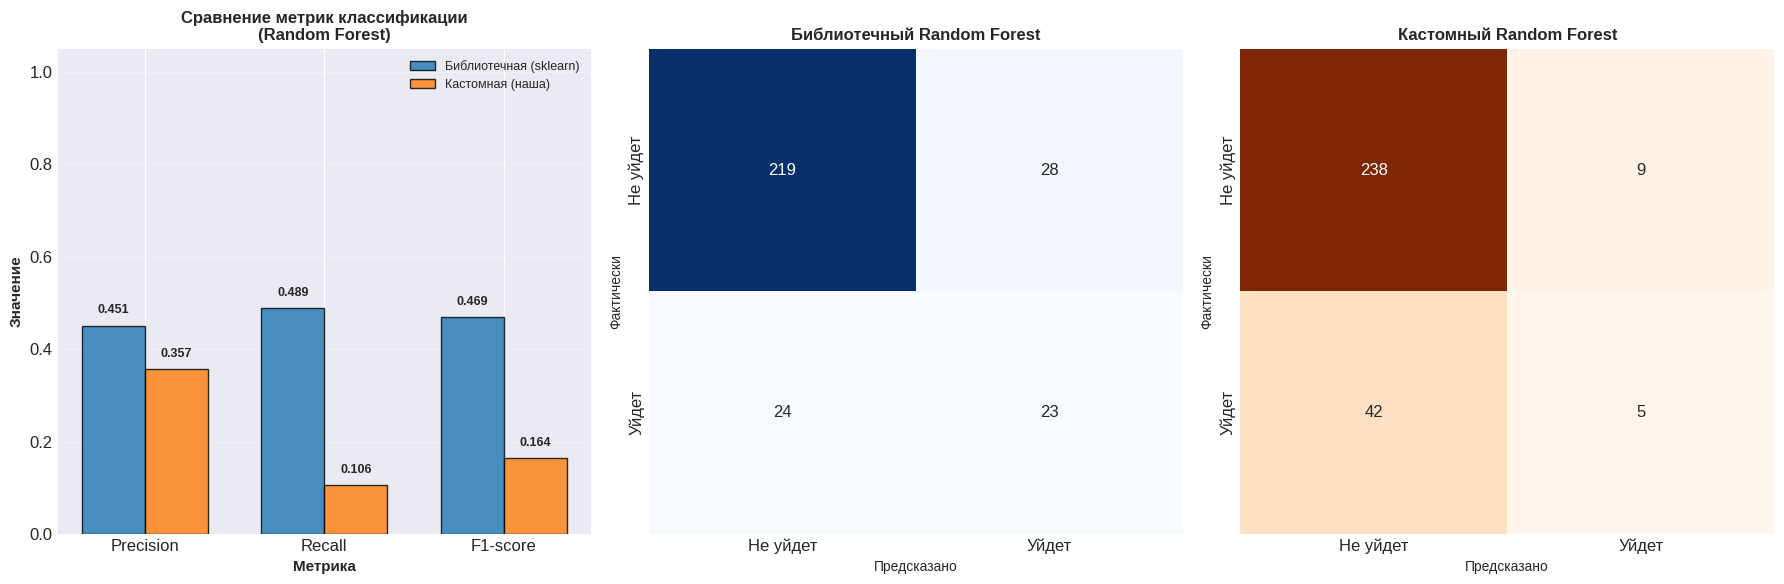


--- 14.3 Сравнение улучшенных регрессионных моделей (Random Forest) ---

СРАВНЕНИЕ МЕТРИК:
-------------------------------------------------------------------------------------
Метрика              Библиотечная    Кастомная      
-------------------------------------------------------------------------------------
RMSE                 $172,148        $191,955       
MAE                  $84,678         $108,042       
MAPE (%)             14.40%          19.45%         
R²                   0.8040          0.7563         

--- 14.4 Визуализация сравнения регрессионных моделей (Random Forest) ---


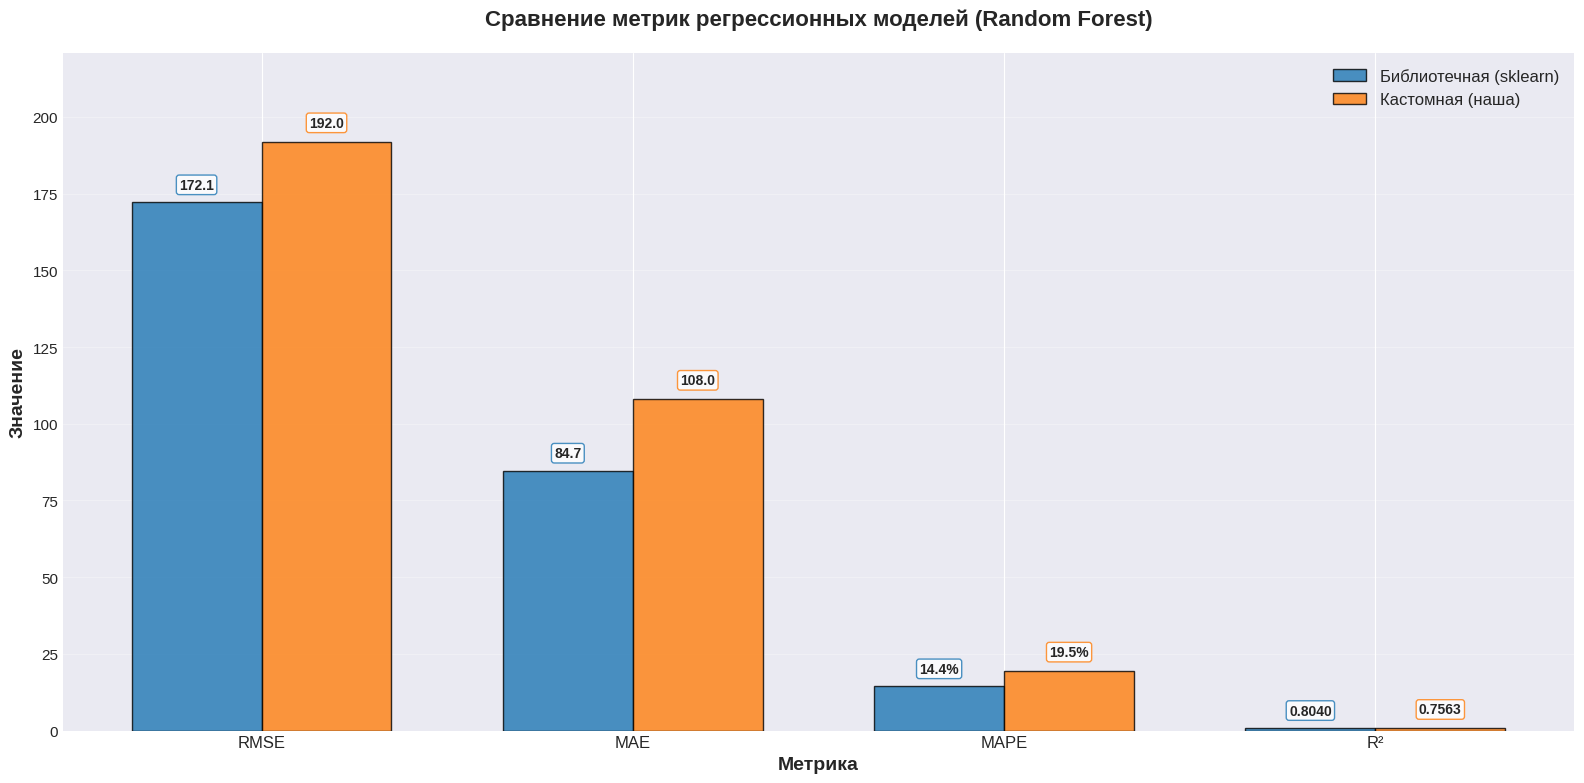

In [ ]:
# Ячейка 14: СРАВНЕНИЕ УЛУЧШЕННЫХ МОДЕЛЕЙ RANDOM FOREST

# 14.1 Сравнение улучшенных классификационных моделей (Random Forest)
print("\n--- 14.1 Сравнение улучшенных классификационных моделей (Random Forest) ---")

print("\nСРАВНЕНИЕ МЕТРИК:")
print("-" * 85)
print(f"{'Метрика':<20} {'Библиотечная':<15} {'Кастомная':<15}")
print("-" * 85)

# Вычисляем метрики для сравнения
for metric_name, lib_val, custom_val in [
    ("F1-score", f1_improve, best_result['f1']),
    ("Precision", precision_improve, best_result['precision']),
    ("Recall", recall_improve, best_result['recall']),
    ("Accuracy", accuracy_improve, best_result['accuracy']),
]:
    
    print(f"{metric_name:<20} {lib_val:<15.4f} {custom_val:<15.4f}")

print("\nМАТРИЦЫ ОШИБОК:")
print(f"Библиотечная:")
print(f"  TN={tn_improve}, FP={fp_improve}, FN={fn_improve}, TP={tp_improve}")
print(f"  (Ложные срабатывания: {fp_improve}, Пропуски: {fn_improve})")

print(f"\nКастомная:")
print(f"  TN={best_result['tn']}, FP={best_result['fp']}, FN={best_result['fn']}, TP={best_result['tp']}")
print(f"  (Ложные срабатывания: {best_result['fp']}, Пропуски: {best_result['fn']})")

# Анализ улучшений
print("\nАНАЛИЗ УЛУЧШЕНИЙ:")
improvement_tp = best_result['tp'] - tp_improve
improvement_fn = fn_improve - best_result['fn']
improvement_fp = fp_improve - best_result['fp']
improvement_tn = best_result['tn'] - tn_improve

print(f"  • Правильных предсказаний класса 1 (TP): {'+' if improvement_tp > 0 else ''}{improvement_tp}")
print(f"  • Меньше пропусков (FN): {'+' if improvement_fn > 0 else ''}{improvement_fn}")
print(f"  • Меньше ложных срабатываний (FP): {'+' if improvement_fp > 0 else ''}{improvement_fp}")
print(f"  • Больше правильных отрицаний (TN): {'+' if improvement_tn > 0 else ''}{improvement_tn}")

# 14.2 Визуализация сравнения классификационных моделей (Random Forest)
print("\n--- 14.2 Визуализация сравнения классификационных моделей (Random Forest) ---")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# График 1: Сравнение метрик
metrics_class = ['Precision', 'Recall', 'F1-score']
lib_vals_class = [precision_improve, recall_improve, f1_improve]
custom_vals_class = [best_result['precision'], 
                     best_result['recall'], best_result['f1']]

x = np.arange(len(metrics_class))
width = 0.35

bars1 = axes[0].bar(x - width/2, lib_vals_class, width, label='Библиотечная (sklearn)', 
                   color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, custom_vals_class, width, label='Кастомная (наша)', 
                   color='#ff7f0e', alpha=0.8, edgecolor='black')

axes[0].set_xlabel('Метрика', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Значение', fontsize=11, fontweight='bold')
axes[0].set_title('Сравнение метрик классификации\n(Random Forest)', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_class)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1.05)

# Добавляем значения на столбцы
for i, (lib_val, custom_val) in enumerate(zip(lib_vals_class, custom_vals_class)):
    axes[0].text(i - width/2, lib_val + 0.02, f'{lib_val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    axes[0].text(i + width/2, custom_val + 0.02, f'{custom_val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# График 2: Сравнение матриц ошибок (библиотечная)
sns.heatmap([[tn_improve, fp_improve], [fn_improve, tp_improve]], annot=True, fmt='d', cmap='Blues', 
            ax=axes[1], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[1].set_title('Библиотечный Random Forest', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Фактически', fontsize=10)
axes[1].set_xlabel('Предсказано', fontsize=10)

# График 3: Сравнение матриц ошибок (кастомная)
sns.heatmap([[best_result['tn'], best_result['fp']], 
             [best_result['fn'], best_result['tp']]], 
            annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False,
            xticklabels=['Не уйдет', 'Уйдет'], 
            yticklabels=['Не уйдет', 'Уйдет'])
axes[2].set_title(f'Кастомный Random Forest', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Фактически', fontsize=10)
axes[2].set_xlabel('Предсказано', fontsize=10)

plt.tight_layout()
plt.show()

# 14.3 Сравнение улучшенных регрессионных моделей (Random Forest)
print("\n--- 14.3 Сравнение улучшенных регрессионных моделей (Random Forest) ---")

print("\nСРАВНЕНИЕ МЕТРИК:")
print("-" * 85)
print(f"{'Метрика':<20} {'Библиотечная':<15} {'Кастомная':<15}")
print("-" * 85)

# Проверяем доступность переменных перед сравнением
available_metrics = []

# Проверяем RMSE
if 'rmse_improved' in locals() and 'best_result_rf' in locals():
    available_metrics.append(("RMSE", rmse_improved, best_result_rf['rmse'], True, False))

# Проверяем MAE
if 'mae_improved' in locals() and 'best_result_rf' in locals():
    available_metrics.append(("MAE", mae_improved, best_result_rf['mae'], True, False))

# Проверяем MAPE
if 'mape_improved' in locals() and 'best_result_rf' in locals():
    available_metrics.append(("MAPE (%)", mape_improved*100, best_result_rf['mape'], False, True))

# Проверяем R²
if 'r2_improved' in locals() and 'best_result_rf' in locals():
    available_metrics.append(("R²", r2_improved, best_result_rf['r2'], False, False))

for metric_name, lib_val, custom_val, is_dollar, is_percent in available_metrics:
    if is_dollar:
        lib_str = f"${lib_val:,.0f}"
        custom_str = f"${custom_val:,.0f}"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")
    
    elif is_percent:
        lib_str = f"{lib_val:.2f}%"
        custom_str = f"{custom_val:.2f}%"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")
    
    else:
        lib_str = f"{lib_val:.4f}"
        custom_str = f"{custom_val:.4f}"
        print(f"{metric_name:<20} {lib_str:<15} {custom_str:<15}")


# 14.4 Визуализация сравнения регрессионных моделей (Random Forest)
print("\n--- 14.4 Визуализация сравнения регрессионных моделей (Random Forest) ---")

plt.figure(figsize=(16, 8))

# Собираем доступные метрики для сравнения
available_metrics_for_plot = []
lib_vals_for_plot = []
custom_vals_for_plot = []
lib_labels_for_plot = []  # Для форматированных значений библиотечной модели
custom_labels_for_plot = []  # Для форматированных значений кастомной модели

# RMSE
if 'rmse_improved' in locals() and 'best_result_rf' in locals():
    available_metrics_for_plot.append('RMSE')
    lib_vals_for_plot.append(rmse_improved/1000)  # в тыс. $
    custom_vals_for_plot.append(best_result_rf['rmse']/1000)
    lib_labels_for_plot.append(f'{rmse_improved/1000:,.1f}')
    custom_labels_for_plot.append(f'{best_result_rf["rmse"]/1000:,.1f}')

# MAE
if 'mae_improved' in locals() and 'best_result_rf' in locals():
    available_metrics_for_plot.append('MAE')
    lib_vals_for_plot.append(mae_improved/1000)  # в тыс. $
    custom_vals_for_plot.append(best_result_rf['mae']/1000)
    lib_labels_for_plot.append(f'{mae_improved/1000:,.1f}')
    custom_labels_for_plot.append(f'{best_result_rf["mae"]/1000:,.1f}')

# MAPE
if 'mape_improved' in locals() and 'best_result_rf' in locals():
    available_metrics_for_plot.append('MAPE')
    lib_vals_for_plot.append(mape_improved*100)  # в процентах
    custom_vals_for_plot.append(best_result_rf['mape'])
    lib_labels_for_plot.append(f'{mape_improved*100:.1f}%')
    custom_labels_for_plot.append(f'{best_result_rf["mape"]:.1f}%')

# R²
if 'r2_improved' in locals() and 'best_result_rf' in locals():
    available_metrics_for_plot.append('R²')
    lib_vals_for_plot.append(r2_improved)
    custom_vals_for_plot.append(best_result_rf['r2'])
    lib_labels_for_plot.append(f'{r2_improved:.4f}')
    custom_labels_for_plot.append(f'{best_result_rf["r2"]:.4f}')

# Создаем график
if available_metrics_for_plot:
    x = np.arange(len(available_metrics_for_plot))
    width = 0.35

    bars1 = plt.bar(x - width/2, lib_vals_for_plot, width, label='Библиотечная (sklearn)', 
                   color='#1f77b4', alpha=0.8, edgecolor='black')
    bars2 = plt.bar(x + width/2, custom_vals_for_plot, width, label='Кастомная (наша)', 
                   color='#ff7f0e', alpha=0.8, edgecolor='black')

    # Добавляем цифры над барами для библиотечной модели
    for bar, value, label in zip(bars1, lib_vals_for_plot, lib_labels_for_plot):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(lib_vals_for_plot)*0.02,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='#1f77b4'))

    # Добавляем цифры над барами для кастомной модели
    for bar, value, label in zip(bars2, custom_vals_for_plot, custom_labels_for_plot):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(custom_vals_for_plot)*0.02,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='#ff7f0e'))

    plt.xlabel('Метрика', fontsize=14, fontweight='bold')
    plt.ylabel('Значение', fontsize=14, fontweight='bold')
    plt.title('Сравнение метрик регрессионных моделей (Random Forest)', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(x, available_metrics_for_plot, fontsize=12)
    plt.yticks(fontsize=11)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, alpha=0.3, axis='y')

    # Настраиваем отступ сверху
    max_value = max(max(lib_vals_for_plot), max(custom_vals_for_plot))
    plt.ylim(0, max_value * 1.15)  # Увеличиваем верхнюю границу на 15%
else:
    plt.text(0.5, 0.5, 'Данные для сравнения\nнедоступны', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
    plt.title('Данные для сравнения регрессионных моделей недоступны', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

### Выводы

Кастомная реализация демонстрирует сложности балансировки метрик в классификации, показывая смещение в сторону минимизации ложных срабатываний за счет полноты. В регрессии библиотечная модель существенно превосходит кастомную по точности (RMSE: $172K vs $192K, R²: 0.804 vs 0.756). Также стоит отметить, что одинаковые гипотезы оптимизации дали значительный эффект в кастомных моделях, но минимальный — в библиотечных, что подтверждает их изначальную оптимизацию. И главное сложность обучения кастомны моделей - их можно было бы значительно улучшить, но все зависит от характеристик компьютера.